<a href="https://colab.research.google.com/github/AyushGupta51379/COMP_5331_Project_Fake_News_Detection/blob/master/pixel_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload datasets to google drive and mount it on Colab

In [1]:
import torch                       # pytorch
import torch.nn as nn              # pytorch for neural network
import torch.nn.functional as F
from torchvision import datasets, transforms # for loading and transform images to tensor
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt    # to plot graph
import time
from tqdm import tqdm
from datetime import datetime

In [2]:
  
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/drive')
# ls 'drive/My Drive/

!unzip 'drive/My Drive/MM17-WeiboRumorSet.zip'

clear_output()
print("unzipping details have been cleared.")

unzipping details have been cleared.


# Read all images, resize images into (image_height,image_width), convert into tensor type

Reference/Tutorial
- A Beginner’s Tutorial on Building an AI Image Classifier using PyTorch **(from data loading, processing to training and evaluation)**
   - https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7

In [3]:
# mainfolder = 'drive/My Drive/COMP5331 Fall 2020/MM17-WeiboRumorSet/'
mainfolder = 'MM17-WeiboRumorSet/'
image_height = 224
image_width  = 224
mytransform = transforms.Compose([transforms.Resize((image_height,image_width), interpolation=Image.NEAREST),   # to resize our source images
                                  transforms.ToTensor()])                                      # then convert into tensors 

dataset = datasets.ImageFolder(mainfolder, transform= mytransform) 
# NOTE: The path should point to a place with subfolders (which contain images inside).
#  It will report bugs if there is no subfolder.
# print(type(dataset))
print('Total no. of images: ', len(dataset))

print(round(len(dataset)*0.5))

# 80% train, 20% test
train_set, val_set = torch.utils.data.random_split(dataset, [round(len(dataset)*0.8), round(len(dataset)*0.2)])
print('Total no. of train set images: ', len(train_set))
print('Total no. of test set images: ', len(val_set))

labels = dataset.class_to_idx # the dataset saves the subfolder's name as the labels
# print(labels) 
# print(type(labels))

classes = list(labels.keys()) # convert dict keys into list
print('classes:', classes)


#  function to view one image
def image_show(np_image):
  plt.figure(figsize = (5,5))
  plt.imshow(np_image) # it should be a numpy array
  plt.show()

Total no. of images:  13249
6624
Total no. of train set images:  10599
Total no. of test set images:  2650
classes: ['nonrumor_images', 'rumor_images', 'tweets']


# Pixel-domain Network

`nn.Conv2d(in_channels, out_channels, kernel_size, ...)`
  - It seems we have to specify the in_channels *manually*

`nn.MaxPool2d(kernel_size, ...`

*   kernel_size = 3 --> 3 x 3
- Max pooling: The maximum pixel value is selected. Batch size and channel size are not changed.  
'the output value of the layer with input size (N, C, H, W), output $(N, C, H_{out}, W_{out})$'
- Min pooling: The minimum pixel value of the batch is selected.
- Average pooling: The average value of all the pixels in the batch is selected.

`nn.Linear(in_features, out_features, ...`

---
**Reference/Tutorial**
- Understand how kernels work in Conv2d and pooling
  -  https://stats.stackexchange.com/questions/296679/what-does-kernel-size-mean#:~:text=Deep%20neural%20networks%2C%20more%20concretely,layer%2C%20are%20the%20convolutional%20filters.

- Convolution Neural Network (CNN)
  -  https://towardsdatascience.com/convolutional-neural-network-17fb77e76c05#:~:text=Fully%20Connected%20Layer%20is%20simply,into%20the%20fully%20connected%20layer.
- What do the fully connected layers do in CNN?
  -  https://stats.stackexchange.com/questions/182102/what-do-the-fully-connected-layers-do-in-cnns/182122
- GRU with Pytorch
  - https://blog.floydhub.com/gru-with-pytorch/

In [4]:
class CNN(nn.Module):
    def __init__(self, image_height, image_width):
        super(CNN, self).__init__()

        # NOTE:
        # 1. Before each ReLu, a BatchNorm2d layer is added to accelerate convergence (also did by the authors of the paper)

        # Conv Model 1
        self.conv_M1 = nn.Sequential(nn.Conv2d( 3, 32, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(32),  # (N,  3, 128, 128) --> (N, 32, 128, 128); add padding = 1 for kernel size = 3 to avoid changing output size
                                     nn.Conv2d(32, 32, 1), nn.ReLU(),   nn.BatchNorm2d(32),             # (N, 32, 128, 128) --> (N, 32, 128, 128);
                                     nn.MaxPool2d(2))                                                   # (N,  3, 128, 128) --> (N, 32,  64,  64);
                                     
        # Conv Model 2
        self.conv_M2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(64),  # (N, 32, 64, 64) --> (N, 64, 64, 64)
                                     nn.Conv2d(64, 64, 1), nn.ReLU(), nn.BatchNorm2d(64),               # (N, 64, 64, 64) --> (N, 64, 64, 64)
                                     nn.MaxPool2d(2))                                                   # (N, 64, 64, 64) --> (N, 64, 32, 32)

        # Conv Model 3
        self.conv_M3 = nn.Sequential(nn.Conv2d(64, 64, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(64),  # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.Conv2d(64, 64, 1), nn.ReLU(), nn.BatchNorm2d(64),               # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.MaxPool2d(2))                                                   # (N, 64, 32, 32) --> (N, 64, 16, 16)

        # Conv Model 4
        self.conv_M4 = nn.Sequential(nn.Conv2d( 64, 128, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(128), # (N,  64, 16, 16) --> (N, 128, 16, 16)
                                     nn.Conv2d(128, 128, 1), nn.ReLU(), nn.BatchNorm2d(128),              # (N, 128, 16, 16) --> (N, 128, 16, 16)
                                     nn.MaxPool2d(2))                                                     # (N, 128, 16, 16) --> (N, 128,  8,  8)
        
        #===== For each branch =====%
        # Note:
        # 1. Flatten convolution layer before FC layer, the input column size = 64 neurons * pooled output size
        # 2. Since image_height and image_width are fed from outside, we need to ensure the type to int after division, otherwise gives bugs.
        # 3. Need to add a dropout layer with a prob of 0.5 after FC layer (see the reference paper)
        # 4. Before each FC layer, a BatchNorm2d layer is added to accelerate convergence

        self.conv_br1 = nn.Sequential(nn.Conv2d(32, 64, 1),
                                      nn.Flatten(1, -1),    # flatten from the 2nd dim (1) to the last dim (-1)
                                      nn.BatchNorm1d(int(64*image_height*image_width/2/2)),
                                      nn.Linear(int(64*image_height*image_width/2/2), 64),
                                      nn.Dropout(0.5))

        self.conv_br2 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(1, -1),     
                                      nn.BatchNorm1d(int(64*image_height*image_width/4/4)),         
                                      nn.Linear(int(64*image_height*image_width/4/4), 64),
                                      nn.Dropout(0.5))

        self.conv_br3 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(1, -1),    
                                      nn.BatchNorm1d(int(64*image_height*image_width/8/8)),
                                      nn.Linear(int(64*image_height*image_width/8/8), 64),
                                      nn.Dropout(0.5))

        self.conv_br4 = nn.Sequential(nn.Conv2d(128, 64, 1),
                                      nn.Flatten(1, -1),              
                                      nn.BatchNorm1d(int(64*image_height*image_width/16/16)),
                                      nn.Linear(int(64*image_height*image_width/16/16), 64),
                                      nn.Dropout(0.5))

        # FC layer to 2 classes (fake or real) with Softmax to compute prob along the dimension of concatenated features (64*4 = 256)
        self.fc = nn.Sequential(nn.BatchNorm1d(256),
                                nn.Linear(256, 2),
                                nn.Dropout(0.5))    
                                        #nn.Softmax(dim=1)) # AG: no need for softmax if we use cross entropy loss function, which will also offer prob.
                                                            # Now the loss in the training part converges!!
    
    def forward(self, x):
        out1 = self.conv_M1(x)      # Branch 1
        out2 = self.conv_M2(out1)   # Branch 2
        out3 = self.conv_M3(out2)   # Branch 3
        out4 = self.conv_M4(out3)   # Branch 4

        v1 = self.conv_br1(out1)
        v2 = self.conv_br2(out2)
        v3 = self.conv_br3(out3)
        v4 = self.conv_br4(out4)

        v_cat = torch.cat((v1, v2, v3, v4), dim=1)

        # print("\n v1 size:", v1.shape)
        # print("\n v2 size:", v2.shape)
        # print("\n v3 size:", v3.shape)
        # print("\n v4 size:", v4.shape)
        # print("\n v_cat size:", v_cat.shape)

        p = self.fc(v_cat)

        return v1, v2, v3, v4, v_cat, p



# Notes about nn.GRU 

---

- input of shape (seq_len, batch, input_size)
- h_0 of shape (num_layers * num_directions, batch, hidden_size)
  - **Question: How should this "seq_len" be in our case??? v1 has only the shape of (batch, input_size)**

- output of shape (seq_len, batch, num_directions * hidden_size)
- h_n of shape (num_layers * num_directions, batch, hidden_size)


# Below is how I interpret the architecture of the Bi-GRU network stated in the paper
- Two layers of GRU for each branch, and almost each of the GRU needs a hidden state from another GRU
- So we have to start from the GRU in the 4th branch to obtain the h4, and then feed it into GRU with v3, and similarly for the rest.
- Since we have to feed a hidden state into the GRU, we set num_layer = 1 and bidirection = False in nn.GRU


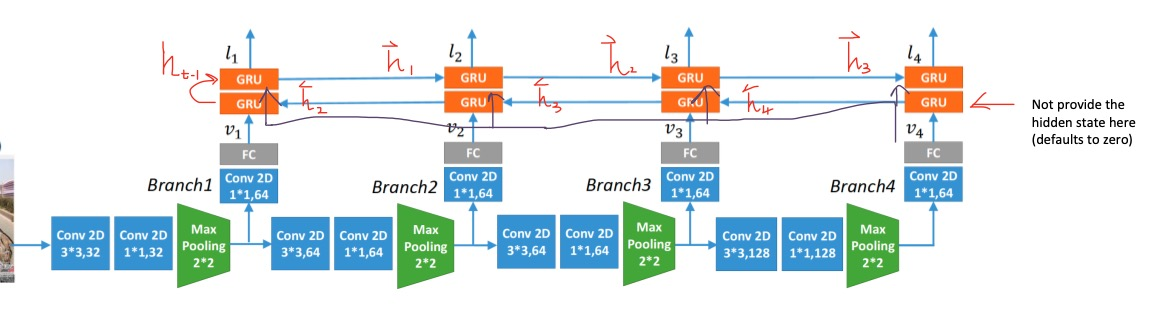

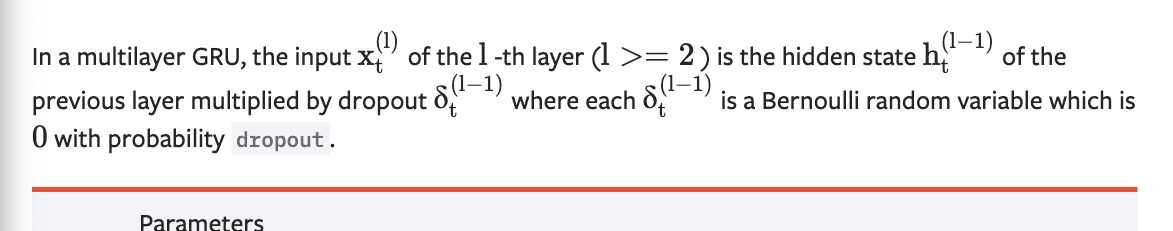

# Pytorch Tutorial: Training on GRU. the previous class is redefined

- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [5]:
class CNN_BiGRU(CNN):
    def __init__(self, image_height, image_width, hidden_size, num_layers):
        super(CNN_BiGRU, self).__init__(image_height, image_width)

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The Bi-GRU with 1 layer in Bi-directions (forward layer + backward layer)
        self.bigru = nn.GRU(input_size = 64, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, bidirectional=True)

        self.flatten = nn.Flatten(1, -1)
        self.bn = nn.BatchNorm1d(4*2*hidden_size)
        self.fc = nn.Linear(4*2*hidden_size, 2) # 4 -> sequence_length, *2 because we set bidirectional = True

    def forward(self, x):
        _, _, _, _, v_cat, _ = super().forward(x)
        # print(v1.shape)
        # v1 = v1.unsqueeze(0) # add an extra dimension to feed into the gru model (N, 64) --> (1, N, 64)
        # v2 = v2.unsqueeze(0)
        # v3 = v3.unsqueeze(0)
        # v4 = v4.unsqueeze(0)
        # v_cat = torch.cat((v1, v2, v3, v4), dim=0) # (1, N, 64) --> (4, N, 64)

        # v_cat = v_cat.permute(1,0,2) # (4, N, 64) --> (N, 4, 64) since we set batch_first = True
        # print(v_cat.shape)

        input = v_cat.reshape(-1, 64, 4).permute(0, 2, 1)   # 64 is hard coded
        out, h = self.bigru(input)  # hidden  default is a 0 tensor

        L_cat = self.flatten(out) # (N, 4, num_directions*hidden_size)

        out = self.fc(self.bn(L_cat)) # (N, 4*num_directions*hidden_size)

        return L_cat, out
        

In [6]:
class CNN_GRU(CNN):
    def __init__(self, image_height, image_width):
        super(CNN_GRU, self).__init__(image_height, image_width)
        # if input size = (batch_size(N),  channels = 3,  image height = 128, image width = 128)

        # The 4 GRUs in layer 1
        self.gru1_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru2_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru3_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru4_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)

        # The 4 GRUs in layer 2
        self.gru1_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru2_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru3_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru4_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)

        self.gru_simple = nn.GRU(input_size=64, hidden_size=32, num_layers=2, bidirectional=True)

        self.relu = nn.ReLU()

        self.bn = nn.BatchNorm1d(4*2*32)
        self.fc = nn.Sequential(nn.Linear(4*2*32, 2))
                                            # nn.LogSoftmax(dim=1)) # AG: no need for softmax if we use cross entropy loss function, which will also offer prob.
                                                            # Now the loss in the training part converges!!

    def forward(self, x):
        v1, v2, v3, v4, v_cat, _ = super().forward(x)
        
        v1 = v1.unsqueeze(0) # add an extra dimension to feed into the gru model (4, 64) --> (1, 4, 64)
        v2 = v2.unsqueeze(0)
        v3 = v3.unsqueeze(0)
        v4 = v4.unsqueeze(0)

        # backward GRU (1st layer) which reads from v4 to v1 
        out4_layer1, h4_backward = self.gru4_1(v4)
        out3_layer1, h3_backward = self.gru3_1(v3, h4_backward)
        out2_layer1, h2_backward = self.gru2_1(v2, h3_backward)
        out1_layer1, h1_backward = self.gru1_1(v1, h2_backward)

        # print('h4_backward=',h4_backward)
        # print('h3_backward=',h3_backward)

        # print(out4_layer1.shape)   # --> (1, N, 32)
        # print(h1_backward.shape)   # --> (1, N, 32)


        # forward GRU (2nd layer) which reads from v1 to v4 
        out1_layer2, h1_forward = self.gru1_2(h1_backward)
        out2_layer2, h2_forward = self.gru2_2(h2_backward, h1_backward)
        out3_layer2, h3_forward = self.gru3_2(h3_backward, h2_backward)
        out4_layer2, h4_forward = self.gru4_2(h4_backward, h3_backward)

        # out1_layer2, h1_forward = self.gru1_2(out1_layer1, h1_backward)
        # out2_layer2, h2_forward = self.gru2_2(out2_layer1, h1_backward)
        # out3_layer2, h3_forward = self.gru3_2(out3_layer1, h2_backward)
        # out4_layer2, h4_forward = self.gru4_2(out4_layer1, h3_backward)

        # print('h1_forward=',h1_forward)
        # print('h2_forward=',h2_forward)

        # print(out1_layer2.shape)  # --> (1, N, 32)
        # print(h1_forward.shape)   # --> (1, N, 32)

        # concatenating the forward hidden state and the backward hidden state along the feature dimension --> (1, N, 64)
        L1 = torch.squeeze(torch.cat((h1_forward, h1_backward), dim=2)) # --> (N, 64)
        L2 = torch.squeeze(torch.cat((h2_forward, h2_backward), dim=2))
        L3 = torch.squeeze(torch.cat((h3_forward, h3_backward), dim=2))
        L4 = torch.squeeze(torch.cat((h4_forward, h4_backward), dim=2))

        # print("\n L1 size:", L1.shape)
        # print("\n L2 size:", L2.shape)
        # print("\n L3 size:", L3.shape)
        # print("\n L4 size:", L4.shape)

        L_cat = torch.cat((L1, L2, L3, L4), dim=1)

        # print("\n L_cat size:", L_cat.shape)
        
        p = self.fc(self.bn(L_cat))

        return L1, L2, L3, L4, L_cat, p


    # def init_hidden(self, batch_size):

    #     weight = next(self.parameters()).data
    #     hidden = weight.new(1, batch_size, 32).zero_().to(device)
    #     return hidden


In [7]:
#Code:
from sklearn.metrics import accuracy_score # normal accuracy
from sklearn.metrics import balanced_accuracy_score # used in case of imbalanced data sets, average of recall, from 0 to 1
from sklearn.metrics import confusion_matrix # division of performance on the multilabels
from sklearn.metrics import cohen_kappa_score # compares model against random prediction, from -1 to 1
from sklearn.metrics import classification_report # for multilabel classification, gives precision, recall, f score, support, more

def print_metrics(y_true, y_pred, target_names):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced Accuracy:" , balanced_accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Cohen Kappa Score:", cohen_kappa_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# Loading data and training

In [20]:
# Hyper-parameters
hidden_size = 32  # for GRU
num_layers = 1    # for GRU
learning_rate = 0.0001
batch_size = 32
MAXepoch = 300
resumetraining = False

# Load training and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, drop_last=True) 
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, drop_last=True)

# Which model to use?
modelname = ['CNN', 'CNN_BiGRU', 'CNN_GRU']
m = 1

if m == 0:
  model = CNN(image_height, image_width)
elif m == 1:
  model = CNN_BiGRU(image_height, image_width, hidden_size, num_layers)
elif m == 2:
  model = CNN_GRU(image_height, image_width)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

model.to(device) # initialize the model on device

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # This criterion combines LogSoftmax and NLLLoss in one single class.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


resume_epoch = 0
# Resume the last trained model?
if resumetraining == True:
  # load the model checkpoint
  PATH = ('drive/My Drive/Colab Notebooks/trained_models/' + modelname[m] + "_MAXepoch" + str(MAXepoch)
          + "_batch" + str(batch_size) + "_lr" + str(learning_rate) + ".pth")
  print('Loading from ', PATH)

  checkpoint = torch.load(PATH)
  # load model weights state_dict
  model.load_state_dict(checkpoint['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  resume_epoch = checkpoint['epoch']
  # load the criterion
  criterion = checkpoint['loss']
  print('Trained model loss function loaded...')
  print('\n===== Resuming the Last Training from Epoch %d ... =====' %(resume_epoch))

else:
  print('\n===== Start a New Training ... =====')
  

# print('\n===== Start Training over one image (testing the model) ... =====')
# train_data, labels = next(iter(train_loader))
# # plot training images
# np_image = train_data[0,:,:,:].cpu().numpy() #converting tensor --> numpy
# np_image = np.transpose(np_image, (1,2,0))
# image_show(np_image)

for epoch in range(MAXepoch - resume_epoch):
  count = 0
  samples = 0
  correct = 0
  train_running_loss = 0
  t0 = time.time()

  epoch = epoch + resume_epoch
  # Training
  for count, (train_data, labels) in tqdm(enumerate(train_loader), total=int(len(train_set)/train_loader.batch_size), miniters = 10):
    # if count == 11:
    #   break

    train_data =  train_data.to(device)
    labels = labels.to(device)

    # Forward pass
    if m == 0 or m == 2:
      _, _, _, _, _, outputs = model(train_data) # outputs.shape = (N, 2)
    elif m == 1:
      _, outputs = model(train_data) # outputs.shape = (N, 2)

    loss = criterion(outputs, labels)
    train_running_loss += loss.item() # to compute mean loss later.

    # Backward and optimize
    optimizer.zero_grad() 
    loss.backward()

    if m == 1 or m == 2: # Clipping gradients for GRU/LSTM/RNN to avoid exploding gradients!
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) 

    optimizer.step()

    _, predicted = torch.max(outputs.data, dim=1) # returns indices of the largest prob. --> the predicted label
    samples += labels.size(0)
    correct += (predicted == labels).sum().item()

    if (count+1) % 10 == 0:
        accuracy = 100 * correct / samples
        print(modelname[m], ': Epoch: %d/%d  Train Loss: %5f  Train Accuracy: %5f' %(epoch+1, MAXepoch, loss.item(), accuracy))

  # Time the training
  t1 = time.time()
  print("Training Time: %10.3f mins" %((t1-t0)/60))

  if (epoch+1) % 2 == 0 or epoch+1 == 1:
    # Validating
    model.eval()  # Toggle on evaluation mode to disable dropout/batchnorm layers when doing validation!!
    val_running_loss = 0.0
    val_running_correct = 0
    preds_all = np.array([])
    labels_all = np.array([])
    with torch.no_grad():
        print('\n===== Start Validating ... =====')
        for count, (val_data, labels) in enumerate(val_loader):
            val_data = val_data.to(device)
            labels = labels.to(device)

            if m == 0 or m == 2:
              _, _, _, _, _, outputs = model(val_data) # outputs.shape = (N, 2)
            elif m == 1:
              _, outputs = model(val_data) # outputs.shape = (N, 2)

            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == labels).sum().item()
        
            # For classficiation report later
            preds_all = np.concatenate([preds_all, preds.cpu().int()]) # convert to cpu int type, and then concatenate 
            labels_all = np.concatenate([labels_all,   labels.cpu().int()])   

        val_loss = val_running_loss/len(val_loader.dataset)
        val_accuracy = 100. * val_running_correct/len(val_loader.dataset)   

    print(modelname[m], ': Epoch: %d/%d  Val Loss: %5f  Val Accuracy: %5f' %(epoch+1, MAXepoch, val_loss, val_accuracy))
    model.train() # Toggle on the training mode to enable back the dropout/batchnorm layers for training!!

    # Print classification report
    y_pred = preds_all
    y_true = labels_all
    target_names = ['non-rumor', 'rumor']
    print_metrics(y_true, y_pred, target_names)

    # Save model checkpoint
    print('!!! The trained model is saved !!!')
    PATH = ('drive/My Drive/Colab Notebooks/trained_models/' + modelname[m] + "_MAXepoch" + str(MAXepoch)
            + "_batch" + str(batch_size) + "_lr" + str(learning_rate) + ".pth")
    torch.save({
          'epoch': epoch+1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': criterion,
          }, PATH)

  # Early stopper
  train_mean_loss =  /int(len(train_set)/train_loader.batch_size)
  print('train_mean_loss: ', train_mean_loss)
  if train_mean_loss < 0.1:
    print('Training is stopped at Epoch %d as loss is already very low (%5f)!' %(epoch+1, train_mean_loss))
    break
  
print('\n===== Finished Training & Validating =====')








  0%|          | 0/331 [00:00<?, ?it/s]


===== Start a New Training ... =====









  3%|▎         | 10/331 [00:05<02:47,  1.92it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.676458  Train Accuracy: 56.250000








 79%|███████▊  | 260/331 [02:33<00:37,  1.88it/s]






  6%|▌         | 20/331 [00:10<02:42,  1.91it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.776476  Train Accuracy: 57.031250









  9%|▉         | 30/331 [00:15<02:38,  1.90it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.516508  Train Accuracy: 57.083333









 12%|█▏        | 40/331 [00:21<02:33,  1.89it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.693500  Train Accuracy: 56.953125









 15%|█▌        | 50/331 [00:26<02:30,  1.87it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.734574  Train Accuracy: 54.750000









 18%|█▊        | 60/331 [00:31<02:23,  1.89it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.643369  Train Accuracy: 55.312500









 21%|██        | 70/331 [00:36<02:17,  1.90it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.538815  Train Accuracy: 55.848214









 24%|██▍       | 80/331 [00:42<02:13,  1.88it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.800752  Train Accuracy: 55.859375









 27%|██▋       | 90/331 [00:47<02:07,  1.88it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.635286  Train Accuracy: 55.972222









 30%|███       | 100/331 [00:52<02:02,  1.89it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.768815  Train Accuracy: 56.031250









 33%|███▎      | 110/331 [00:58<01:56,  1.90it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.588962  Train Accuracy: 56.136364









 36%|███▋      | 120/331 [01:03<01:53,  1.87it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.557282  Train Accuracy: 56.093750









 39%|███▉      | 130/331 [01:08<01:46,  1.88it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.707267  Train Accuracy: 56.466346









 42%|████▏     | 140/331 [01:14<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.714301  Train Accuracy: 56.607143









 45%|████▌     | 150/331 [01:19<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.613361  Train Accuracy: 56.791667









 48%|████▊     | 160/331 [01:25<01:32,  1.85it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.715645  Train Accuracy: 56.894531









 51%|█████▏    | 170/331 [01:30<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.768960  Train Accuracy: 56.911765









 54%|█████▍    | 180/331 [01:35<01:20,  1.86it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.586974  Train Accuracy: 56.857639









 57%|█████▋    | 190/331 [01:41<01:16,  1.86it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.651774  Train Accuracy: 57.105263









 60%|██████    | 200/331 [01:46<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.531007  Train Accuracy: 57.578125









 63%|██████▎   | 210/331 [01:52<01:05,  1.85it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.689160  Train Accuracy: 57.857143









 66%|██████▋   | 220/331 [01:57<00:59,  1.85it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.661899  Train Accuracy: 58.053977









 69%|██████▉   | 230/331 [02:02<00:54,  1.86it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.697240  Train Accuracy: 58.179348









 73%|███████▎  | 240/331 [02:08<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.592454  Train Accuracy: 58.307292









 76%|███████▌  | 250/331 [02:13<00:43,  1.84it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.775311  Train Accuracy: 58.312500









 79%|███████▊  | 260/331 [02:19<00:38,  1.86it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.532353  Train Accuracy: 58.269231









 82%|████████▏ | 270/331 [02:24<00:33,  1.84it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.620681  Train Accuracy: 58.402778









 85%|████████▍ | 280/331 [02:29<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.633754  Train Accuracy: 58.258929









 88%|████████▊ | 290/331 [02:35<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.543117  Train Accuracy: 58.491379









 91%|█████████ | 300/331 [02:40<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.714923  Train Accuracy: 58.562500









 94%|█████████▎| 310/331 [02:45<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.732053  Train Accuracy: 58.659274









 97%|█████████▋| 320/331 [02:51<00:05,  1.88it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.676114  Train Accuracy: 58.671875









100%|█████████▉| 330/331 [02:56<00:00,  1.88it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.696470  Train Accuracy: 58.759470


100%|██████████| 331/331 [02:57<00:00,  1.87it/s]


Training Time:      2.952 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 1/300  Val Loss: 0.018577  Val Accuracy: 65.698113
Accuracy: 0.6634908536585366
Balanced Accuracy: 0.6603236897022835
Confusion Matrix:
 [[ 691  384]
 [ 499 1050]]
Cohen Kappa Score: 0.315483653681393
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.58      0.64      0.61      1075
       rumor       0.73      0.68      0.70      1549

    accuracy                           0.66      2624
   macro avg       0.66      0.66      0.66      2624
weighted avg       0.67      0.66      0.67      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.674729633907537









  3%|▎         | 10/331 [00:05<02:48,  1.90it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.689479  Train Accuracy: 62.500000









  6%|▌         | 20/331 [00:10<02:46,  1.87it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.638105  Train Accuracy: 62.187500









  9%|▉         | 30/331 [00:16<02:43,  1.84it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.624517  Train Accuracy: 61.666667









 12%|█▏        | 40/331 [00:21<02:37,  1.85it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.519663  Train Accuracy: 62.578125









 15%|█▌        | 50/331 [00:27<02:35,  1.81it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.570850  Train Accuracy: 62.125000









 18%|█▊        | 60/331 [00:33<02:28,  1.82it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.686686  Train Accuracy: 62.187500









 21%|██        | 70/331 [00:38<02:22,  1.83it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.735506  Train Accuracy: 62.455357









 24%|██▍       | 80/331 [00:43<02:17,  1.83it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.606283  Train Accuracy: 62.343750









 27%|██▋       | 90/331 [00:49<02:09,  1.86it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.583368  Train Accuracy: 62.743056









 30%|███       | 100/331 [00:54<02:03,  1.88it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.548294  Train Accuracy: 62.968750









 33%|███▎      | 110/331 [00:59<01:57,  1.88it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.809723  Train Accuracy: 62.329545









 36%|███▋      | 120/331 [01:05<01:54,  1.84it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.494310  Train Accuracy: 62.708333









 39%|███▉      | 130/331 [01:10<01:49,  1.83it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.690963  Train Accuracy: 62.740385









 42%|████▏     | 140/331 [01:16<01:44,  1.83it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.666534  Train Accuracy: 62.723214









 45%|████▌     | 150/331 [01:21<01:37,  1.85it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.533946  Train Accuracy: 62.833333









 48%|████▊     | 160/331 [01:26<01:32,  1.86it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.732232  Train Accuracy: 62.812500









 51%|█████▏    | 170/331 [01:32<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.568767  Train Accuracy: 62.904412









 54%|█████▍    | 180/331 [01:37<01:20,  1.88it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.554933  Train Accuracy: 63.142361









 57%|█████▋    | 190/331 [01:42<01:15,  1.87it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.733964  Train Accuracy: 63.092105









 60%|██████    | 200/331 [01:48<01:09,  1.87it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.650330  Train Accuracy: 63.093750









 63%|██████▎   | 210/331 [01:53<01:03,  1.91it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.680326  Train Accuracy: 62.693452









 66%|██████▋   | 220/331 [01:58<00:58,  1.90it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.656441  Train Accuracy: 62.571023









 69%|██████▉   | 230/331 [02:04<00:54,  1.87it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.631622  Train Accuracy: 62.459239









 73%|███████▎  | 240/331 [02:09<00:49,  1.84it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.639053  Train Accuracy: 62.630208









 76%|███████▌  | 250/331 [02:14<00:43,  1.85it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.575205  Train Accuracy: 62.750000









 79%|███████▊  | 260/331 [02:20<00:38,  1.87it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.645977  Train Accuracy: 62.704327









 82%|████████▏ | 270/331 [02:25<00:32,  1.89it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.624997  Train Accuracy: 62.685185









 85%|████████▍ | 280/331 [02:30<00:26,  1.89it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.613246  Train Accuracy: 62.712054









 88%|████████▊ | 290/331 [02:35<00:21,  1.90it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.568892  Train Accuracy: 62.801724









 91%|█████████ | 300/331 [02:41<00:16,  1.89it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.546211  Train Accuracy: 62.833333









 94%|█████████▎| 310/331 [02:46<00:11,  1.89it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.590411  Train Accuracy: 62.812500









 97%|█████████▋| 320/331 [02:51<00:05,  1.90it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.622113  Train Accuracy: 62.929688









100%|█████████▉| 330/331 [02:57<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 2/300  Train Loss: 0.598152  Train Accuracy: 63.077652


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.961 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 2/300  Val Loss: 0.018242  Val Accuracy: 66.943396
Accuracy: 0.6760670731707317
Balanced Accuracy: 0.6675303074305108
Confusion Matrix:
 [[ 668  410]
 [ 440 1106]]
Cohen Kappa Score: 0.33365519285280654
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.60      0.62      0.61      1078
       rumor       0.73      0.72      0.72      1546

    accuracy                           0.68      2624
   macro avg       0.67      0.67      0.67      2624
weighted avg       0.68      0.68      0.68      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.6318726192068117









  3%|▎         | 10/331 [00:05<02:50,  1.88it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.768458  Train Accuracy: 65.937500









  6%|▌         | 20/331 [00:10<02:45,  1.87it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.750482  Train Accuracy: 63.437500









  9%|▉         | 30/331 [00:16<02:46,  1.81it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.627124  Train Accuracy: 63.020833









 12%|█▏        | 40/331 [00:22<02:41,  1.80it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.593984  Train Accuracy: 64.531250









 15%|█▌        | 50/331 [00:27<02:35,  1.80it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.690332  Train Accuracy: 63.562500









 18%|█▊        | 60/331 [00:33<02:28,  1.83it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.695919  Train Accuracy: 63.750000









 21%|██        | 70/331 [00:38<02:22,  1.83it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.657772  Train Accuracy: 63.616071









 24%|██▍       | 80/331 [00:43<02:16,  1.84it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.607142  Train Accuracy: 63.945312









 27%|██▋       | 90/331 [00:49<02:09,  1.86it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.647918  Train Accuracy: 64.131944









 30%|███       | 100/331 [00:54<02:02,  1.88it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.553533  Train Accuracy: 64.468750









 33%|███▎      | 110/331 [00:59<01:58,  1.87it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.608118  Train Accuracy: 64.318182









 36%|███▋      | 120/331 [01:05<01:52,  1.88it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.642239  Train Accuracy: 64.296875









 39%|███▉      | 130/331 [01:10<01:46,  1.89it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.652178  Train Accuracy: 64.230769









 42%|████▏     | 140/331 [01:15<01:40,  1.89it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.672975  Train Accuracy: 64.308036









 45%|████▌     | 150/331 [01:20<01:35,  1.89it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.554840  Train Accuracy: 64.458333









 48%|████▊     | 160/331 [01:26<01:32,  1.85it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.656504  Train Accuracy: 64.257812









 51%|█████▏    | 170/331 [01:31<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.593138  Train Accuracy: 64.466912









 54%|█████▍    | 180/331 [01:37<01:21,  1.86it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.578216  Train Accuracy: 64.791667









 57%|█████▋    | 190/331 [01:42<01:15,  1.86it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.614249  Train Accuracy: 64.967105









 60%|██████    | 200/331 [01:48<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.525924  Train Accuracy: 65.093750









 63%|██████▎   | 210/331 [01:53<01:05,  1.85it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.577386  Train Accuracy: 65.282738









 66%|██████▋   | 220/331 [01:58<00:59,  1.88it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.587014  Train Accuracy: 65.241477









 69%|██████▉   | 230/331 [02:04<00:54,  1.87it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.646064  Train Accuracy: 65.434783









 73%|███████▎  | 240/331 [02:09<00:48,  1.86it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.540173  Train Accuracy: 65.664062









 76%|███████▌  | 250/331 [02:14<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.637464  Train Accuracy: 65.700000









 79%|███████▊  | 260/331 [02:20<00:37,  1.87it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.553704  Train Accuracy: 66.021635









 82%|████████▏ | 270/331 [02:25<00:32,  1.85it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.640871  Train Accuracy: 65.949074









 85%|████████▍ | 280/331 [02:31<00:27,  1.83it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.536292  Train Accuracy: 65.837054









 88%|████████▊ | 290/331 [02:36<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.484010  Train Accuracy: 65.948276









 91%|█████████ | 300/331 [02:41<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.669662  Train Accuracy: 65.968750









 94%|█████████▎| 310/331 [02:47<00:11,  1.87it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.668375  Train Accuracy: 65.897177









 97%|█████████▋| 320/331 [02:52<00:05,  1.88it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.534898  Train Accuracy: 65.878906









100%|█████████▉| 330/331 [02:57<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 3/300  Train Loss: 0.471040  Train Accuracy: 65.899621


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.973 mins
train_mean_loss:  0.6068308031090797









  3%|▎         | 10/331 [00:05<02:51,  1.87it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.692783  Train Accuracy: 64.062500









  6%|▌         | 20/331 [00:10<02:46,  1.87it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.525334  Train Accuracy: 65.468750









  9%|▉         | 30/331 [00:16<02:43,  1.84it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.503720  Train Accuracy: 67.083333









 12%|█▏        | 40/331 [00:21<02:37,  1.85it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.681982  Train Accuracy: 66.796875









 15%|█▌        | 50/331 [00:26<02:30,  1.87it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.613665  Train Accuracy: 67.375000









 18%|█▊        | 60/331 [00:32<02:23,  1.89it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.645611  Train Accuracy: 67.604167









 21%|██        | 70/331 [00:37<02:18,  1.88it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.546270  Train Accuracy: 67.500000









 24%|██▍       | 80/331 [00:42<02:14,  1.87it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.585931  Train Accuracy: 67.421875









 27%|██▋       | 90/331 [00:48<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.500428  Train Accuracy: 67.256944









 30%|███       | 100/331 [00:53<02:04,  1.85it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.552874  Train Accuracy: 67.750000









 33%|███▎      | 110/331 [00:59<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.522398  Train Accuracy: 68.039773









 36%|███▋      | 120/331 [01:04<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.485782  Train Accuracy: 68.359375









 39%|███▉      | 130/331 [01:09<01:48,  1.85it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.597358  Train Accuracy: 68.269231









 42%|████▏     | 140/331 [01:15<01:43,  1.85it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.668932  Train Accuracy: 68.013393









 45%|████▌     | 150/331 [01:20<01:37,  1.87it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.583612  Train Accuracy: 68.083333









 48%|████▊     | 160/331 [01:25<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.411124  Train Accuracy: 68.339844









 51%|█████▏    | 170/331 [01:31<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.537337  Train Accuracy: 68.290441









 54%|█████▍    | 180/331 [01:36<01:21,  1.86it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.676764  Train Accuracy: 68.541667









 57%|█████▋    | 190/331 [01:42<01:15,  1.86it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.620301  Train Accuracy: 68.338816









 60%|██████    | 200/331 [01:47<01:10,  1.85it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.664781  Train Accuracy: 68.406250









 63%|██████▎   | 210/331 [01:52<01:04,  1.88it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.510854  Train Accuracy: 68.422619









 66%|██████▋   | 220/331 [01:57<00:58,  1.89it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.567520  Train Accuracy: 68.636364









 69%|██████▉   | 230/331 [02:03<00:53,  1.87it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.619240  Train Accuracy: 68.654891









 73%|███████▎  | 240/331 [02:08<00:48,  1.88it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.576890  Train Accuracy: 68.697917









 76%|███████▌  | 250/331 [02:14<00:43,  1.88it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.658421  Train Accuracy: 68.575000









 79%|███████▊  | 260/331 [02:19<00:37,  1.89it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.568525  Train Accuracy: 68.701923









 82%|████████▏ | 270/331 [02:24<00:32,  1.88it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.417040  Train Accuracy: 68.657407









 85%|████████▍ | 280/331 [02:29<00:27,  1.89it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.693398  Train Accuracy: 68.593750









 88%|████████▊ | 290/331 [02:35<00:22,  1.85it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.632540  Train Accuracy: 68.642241









 91%|█████████ | 300/331 [02:40<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.540402  Train Accuracy: 68.750000









 94%|█████████▎| 310/331 [02:46<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.529014  Train Accuracy: 68.790323









 97%|█████████▋| 320/331 [02:51<00:05,  1.84it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.574343  Train Accuracy: 68.710938









100%|█████████▉| 330/331 [02:57<00:00,  1.84it/s]

CNN_BiGRU : Epoch: 4/300  Train Loss: 0.615457  Train Accuracy: 68.768939


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.963 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 4/300  Val Loss: 0.016768  Val Accuracy: 71.018868
Accuracy: 0.7172256097560976
Balanced Accuracy: 0.7097603006861923
Confusion Matrix:
 [[ 720  358]
 [ 384 1162]]
Cohen Kappa Score: 0.4179946815633908
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.65      0.67      0.66      1078
       rumor       0.76      0.75      0.76      1546

    accuracy                           0.72      2624
   macro avg       0.71      0.71      0.71      2624
weighted avg       0.72      0.72      0.72      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.5775740969577224









  3%|▎         | 10/331 [00:05<02:56,  1.82it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.555388  Train Accuracy: 70.000000









  6%|▌         | 20/331 [00:11<02:51,  1.82it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.607238  Train Accuracy: 70.937500









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.463790  Train Accuracy: 70.729167









 12%|█▏        | 40/331 [00:22<02:40,  1.81it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.552185  Train Accuracy: 70.234375









 15%|█▌        | 50/331 [00:27<02:33,  1.83it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.559859  Train Accuracy: 71.125000









 18%|█▊        | 60/331 [00:32<02:28,  1.83it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.564602  Train Accuracy: 71.250000









 21%|██        | 70/331 [00:38<02:22,  1.83it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.532917  Train Accuracy: 71.250000









 24%|██▍       | 80/331 [00:43<02:16,  1.84it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.624312  Train Accuracy: 71.601562









 27%|██▋       | 90/331 [00:49<02:11,  1.84it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.529576  Train Accuracy: 71.180556









 30%|███       | 100/331 [00:54<02:06,  1.82it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.644852  Train Accuracy: 70.718750









 33%|███▎      | 110/331 [01:00<02:00,  1.83it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.509696  Train Accuracy: 71.051136









 36%|███▋      | 120/331 [01:05<01:55,  1.83it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.564119  Train Accuracy: 70.885417









 39%|███▉      | 130/331 [01:10<01:49,  1.84it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.578622  Train Accuracy: 70.865385









 42%|████▏     | 140/331 [01:16<01:44,  1.83it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.510743  Train Accuracy: 71.227679









 45%|████▌     | 150/331 [01:21<01:38,  1.84it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.639239  Train Accuracy: 70.916667









 48%|████▊     | 160/331 [01:27<01:33,  1.82it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.547167  Train Accuracy: 71.035156









 51%|█████▏    | 170/331 [01:32<01:28,  1.83it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.474332  Train Accuracy: 70.974265









 54%|█████▍    | 180/331 [01:38<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.532509  Train Accuracy: 70.937500









 57%|█████▋    | 190/331 [01:43<01:15,  1.87it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.511449  Train Accuracy: 71.052632









 60%|██████    | 200/331 [01:48<01:10,  1.85it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.638901  Train Accuracy: 70.812500









 63%|██████▎   | 210/331 [01:54<01:04,  1.87it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.580309  Train Accuracy: 70.877976









 66%|██████▋   | 220/331 [01:59<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.571880  Train Accuracy: 70.667614









 69%|██████▉   | 230/331 [02:04<00:53,  1.87it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.613619  Train Accuracy: 70.570652









 73%|███████▎  | 240/331 [02:09<00:48,  1.89it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.452284  Train Accuracy: 70.520833









 76%|███████▌  | 250/331 [02:15<00:42,  1.88it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.384644  Train Accuracy: 70.737500









 79%|███████▊  | 260/331 [02:20<00:37,  1.87it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.566848  Train Accuracy: 70.733173









 82%|████████▏ | 270/331 [02:26<00:32,  1.87it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.667516  Train Accuracy: 70.682870









 85%|████████▍ | 280/331 [02:31<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.401038  Train Accuracy: 70.859375









 88%|████████▊ | 290/331 [02:36<00:22,  1.85it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.607947  Train Accuracy: 70.851293









 91%|█████████ | 300/331 [02:42<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.561881  Train Accuracy: 70.812500









 94%|█████████▎| 310/331 [02:47<00:11,  1.87it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.528547  Train Accuracy: 70.756048









 97%|█████████▋| 320/331 [02:53<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.427561  Train Accuracy: 70.839844









100%|█████████▉| 330/331 [02:58<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 5/300  Train Loss: 0.326793  Train Accuracy: 70.842803


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.983 mins
train_mean_loss:  0.5585257803565425









  3%|▎         | 10/331 [00:05<02:58,  1.80it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.435631  Train Accuracy: 73.125000









  6%|▌         | 20/331 [00:10<02:51,  1.82it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.533051  Train Accuracy: 72.500000









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.493472  Train Accuracy: 72.291667









 12%|█▏        | 40/331 [00:21<02:39,  1.83it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.517139  Train Accuracy: 72.265625









 15%|█▌        | 50/331 [00:27<02:31,  1.85it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.518654  Train Accuracy: 72.000000









 18%|█▊        | 60/331 [00:32<02:26,  1.85it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.559644  Train Accuracy: 71.666667









 21%|██        | 70/331 [00:37<02:21,  1.84it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.427608  Train Accuracy: 70.937500









 24%|██▍       | 80/331 [00:43<02:17,  1.83it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.483456  Train Accuracy: 70.664062









 27%|██▋       | 90/331 [00:48<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.496805  Train Accuracy: 71.145833









 30%|███       | 100/331 [00:54<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.639292  Train Accuracy: 71.062500









 33%|███▎      | 110/331 [00:59<01:58,  1.87it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.613867  Train Accuracy: 71.363636









 36%|███▋      | 120/331 [01:04<01:54,  1.84it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.499137  Train Accuracy: 71.718750









 39%|███▉      | 130/331 [01:10<01:48,  1.85it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.535087  Train Accuracy: 71.971154









 42%|████▏     | 140/331 [01:15<01:43,  1.85it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.341886  Train Accuracy: 72.321429









 45%|████▌     | 150/331 [01:21<01:38,  1.85it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.565898  Train Accuracy: 72.312500









 48%|████▊     | 160/331 [01:26<01:33,  1.83it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.633076  Train Accuracy: 72.304688









 51%|█████▏    | 170/331 [01:32<01:28,  1.83it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.630969  Train Accuracy: 72.279412









 54%|█████▍    | 180/331 [01:37<01:21,  1.84it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.521483  Train Accuracy: 72.256944









 57%|█████▋    | 190/331 [01:42<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.445051  Train Accuracy: 72.434211









 60%|██████    | 200/331 [01:48<01:09,  1.87it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.426324  Train Accuracy: 72.312500









 63%|██████▎   | 210/331 [01:53<01:04,  1.87it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.558254  Train Accuracy: 72.217262









 66%|██████▋   | 220/331 [01:59<01:00,  1.84it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.411236  Train Accuracy: 72.144886









 69%|██████▉   | 230/331 [02:04<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.541786  Train Accuracy: 72.078804









 73%|███████▎  | 240/331 [02:09<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.444238  Train Accuracy: 72.135417









 76%|███████▌  | 250/331 [02:15<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.540988  Train Accuracy: 72.150000









 79%|███████▊  | 260/331 [02:20<00:38,  1.85it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.465344  Train Accuracy: 72.187500









 82%|████████▏ | 270/331 [02:25<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.561738  Train Accuracy: 72.106481









 85%|████████▍ | 280/331 [02:31<00:26,  1.89it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.503462  Train Accuracy: 72.131696









 88%|████████▊ | 290/331 [02:36<00:21,  1.88it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.614208  Train Accuracy: 72.209052









 91%|█████████ | 300/331 [02:41<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.461900  Train Accuracy: 72.145833









 94%|█████████▎| 310/331 [02:47<00:11,  1.88it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.537968  Train Accuracy: 72.227823









 97%|█████████▋| 320/331 [02:52<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.646293  Train Accuracy: 72.099609









100%|█████████▉| 330/331 [02:57<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 6/300  Train Loss: 0.457198  Train Accuracy: 72.130682


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]


Training Time:      2.974 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 6/300  Val Loss: 0.015970  Val Accuracy: 73.358491
Accuracy: 0.7408536585365854
Balanced Accuracy: 0.7317155102861034
Confusion Matrix:
 [[ 734  345]
 [ 335 1210]]
Cohen Kappa Score: 0.4640796527955068
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.69      0.68      0.68      1079
       rumor       0.78      0.78      0.78      1545

    accuracy                           0.74      2624
   macro avg       0.73      0.73      0.73      2624
weighted avg       0.74      0.74      0.74      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.5364487339542712









  3%|▎         | 10/331 [00:05<02:51,  1.87it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.517637  Train Accuracy: 73.437500









  6%|▌         | 20/331 [00:10<02:46,  1.87it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.457796  Train Accuracy: 73.125000









  9%|▉         | 30/331 [00:16<02:42,  1.86it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.606243  Train Accuracy: 72.500000









 12%|█▏        | 40/331 [00:21<02:38,  1.84it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.559390  Train Accuracy: 74.531250









 15%|█▌        | 50/331 [00:27<02:32,  1.84it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.543956  Train Accuracy: 75.062500









 18%|█▊        | 60/331 [00:32<02:25,  1.86it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.568201  Train Accuracy: 74.791667









 21%|██        | 70/331 [00:37<02:19,  1.87it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.511530  Train Accuracy: 74.464286









 24%|██▍       | 80/331 [00:42<02:12,  1.90it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.492273  Train Accuracy: 74.335938









 27%|██▋       | 90/331 [00:48<02:07,  1.89it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.536326  Train Accuracy: 73.958333









 30%|███       | 100/331 [00:53<02:02,  1.88it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.566065  Train Accuracy: 73.875000









 33%|███▎      | 110/331 [00:58<01:57,  1.88it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.407243  Train Accuracy: 74.176136









 36%|███▋      | 120/331 [01:04<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.458372  Train Accuracy: 74.453125









 39%|███▉      | 130/331 [01:09<01:48,  1.85it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.476437  Train Accuracy: 74.375000









 42%|████▏     | 140/331 [01:15<01:43,  1.84it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.532876  Train Accuracy: 74.375000









 45%|████▌     | 150/331 [01:20<01:37,  1.86it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.630827  Train Accuracy: 73.833333









 48%|████▊     | 160/331 [01:25<01:30,  1.88it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.484348  Train Accuracy: 73.691406









 51%|█████▏    | 170/331 [01:31<01:26,  1.85it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.504185  Train Accuracy: 73.492647









 54%|█████▍    | 180/331 [01:36<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.615177  Train Accuracy: 73.385417









 57%|█████▋    | 190/331 [01:42<01:17,  1.83it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.437050  Train Accuracy: 73.223684









 60%|██████    | 200/331 [01:47<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.643658  Train Accuracy: 73.281250









 63%|██████▎   | 210/331 [01:53<01:06,  1.83it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.624537  Train Accuracy: 73.229167









 66%|██████▋   | 220/331 [01:58<01:00,  1.84it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.631379  Train Accuracy: 73.125000









 69%|██████▉   | 230/331 [02:03<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.457038  Train Accuracy: 73.288043









 73%|███████▎  | 240/331 [02:09<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.558713  Train Accuracy: 73.372396









 76%|███████▌  | 250/331 [02:14<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.971640  Train Accuracy: 73.225000









 79%|███████▊  | 260/331 [02:20<00:38,  1.84it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.475380  Train Accuracy: 73.245192









 82%|████████▏ | 270/331 [02:25<00:32,  1.85it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.472140  Train Accuracy: 73.391204









 85%|████████▍ | 280/331 [02:30<00:27,  1.86it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.562311  Train Accuracy: 73.448661









 88%|████████▊ | 290/331 [02:36<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.533008  Train Accuracy: 73.415948









 91%|█████████ | 300/331 [02:41<00:16,  1.85it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.428144  Train Accuracy: 73.541667









 94%|█████████▎| 310/331 [02:47<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.639240  Train Accuracy: 73.467742









 97%|█████████▋| 320/331 [02:52<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.439056  Train Accuracy: 73.544922









100%|█████████▉| 330/331 [02:58<00:00,  1.83it/s]

CNN_BiGRU : Epoch: 7/300  Train Loss: 0.508562  Train Accuracy: 73.617424


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.979 mins
train_mean_loss:  0.5194861246019692









  3%|▎         | 10/331 [00:05<02:53,  1.85it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.564503  Train Accuracy: 72.187500









  6%|▌         | 20/331 [00:11<02:50,  1.82it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.579771  Train Accuracy: 72.031250









  9%|▉         | 30/331 [00:16<02:42,  1.85it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.396236  Train Accuracy: 73.333333









 12%|█▏        | 40/331 [00:21<02:34,  1.88it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.470671  Train Accuracy: 73.750000









 15%|█▌        | 50/331 [00:26<02:29,  1.88it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.570651  Train Accuracy: 74.312500









 18%|█▊        | 60/331 [00:32<02:24,  1.87it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.551361  Train Accuracy: 74.010417









 21%|██        | 70/331 [00:37<02:20,  1.86it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.489926  Train Accuracy: 73.750000









 24%|██▍       | 80/331 [00:43<02:18,  1.82it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.561321  Train Accuracy: 73.789062









 27%|██▋       | 90/331 [00:48<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.620130  Train Accuracy: 73.541667









 30%|███       | 100/331 [00:54<02:05,  1.84it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.356751  Train Accuracy: 73.468750









 33%|███▎      | 110/331 [00:59<02:00,  1.83it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.502883  Train Accuracy: 73.551136









 36%|███▋      | 120/331 [01:05<01:55,  1.83it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.484043  Train Accuracy: 74.062500









 39%|███▉      | 130/331 [01:10<01:50,  1.82it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.534354  Train Accuracy: 74.110577









 42%|████▏     | 140/331 [01:15<01:44,  1.83it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.626398  Train Accuracy: 74.375000









 45%|████▌     | 150/331 [01:21<01:38,  1.85it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.448710  Train Accuracy: 74.416667









 48%|████▊     | 160/331 [01:26<01:32,  1.85it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.532845  Train Accuracy: 74.453125









 51%|█████▏    | 170/331 [01:31<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.525520  Train Accuracy: 74.485294









 54%|█████▍    | 180/331 [01:37<01:20,  1.88it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.450481  Train Accuracy: 74.565972









 57%|█████▋    | 190/331 [01:42<01:15,  1.86it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.606603  Train Accuracy: 74.703947









 60%|██████    | 200/331 [01:47<01:09,  1.89it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.594977  Train Accuracy: 74.625000









 63%|██████▎   | 210/331 [01:53<01:04,  1.88it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.478762  Train Accuracy: 74.598214









 66%|██████▋   | 220/331 [01:58<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.573523  Train Accuracy: 74.531250









 69%|██████▉   | 230/331 [02:04<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.522234  Train Accuracy: 74.633152









 73%|███████▎  | 240/331 [02:09<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.417648  Train Accuracy: 74.557292









 76%|███████▌  | 250/331 [02:14<00:43,  1.85it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.374429  Train Accuracy: 74.537500









 79%|███████▊  | 260/331 [02:20<00:38,  1.85it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.436610  Train Accuracy: 74.675481









 82%|████████▏ | 270/331 [02:25<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.571625  Train Accuracy: 74.733796









 85%|████████▍ | 280/331 [02:31<00:27,  1.86it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.693482  Train Accuracy: 74.821429









 88%|████████▊ | 290/331 [02:36<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.616385  Train Accuracy: 74.892241









 91%|█████████ | 300/331 [02:41<00:16,  1.88it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.466652  Train Accuracy: 74.760417









 94%|█████████▎| 310/331 [02:47<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.645880  Train Accuracy: 74.586694









 97%|█████████▋| 320/331 [02:52<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.579676  Train Accuracy: 74.541016









100%|█████████▉| 330/331 [02:57<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 8/300  Train Loss: 0.458859  Train Accuracy: 74.431818


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]


Training Time:      2.971 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 8/300  Val Loss: 0.015569  Val Accuracy: 74.339623
Accuracy: 0.7507621951219512
Balanced Accuracy: 0.7375635249594521
Confusion Matrix:
 [[ 714  360]
 [ 294 1256]]
Cohen Kappa Score: 0.47965302439308377
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.71      0.66      0.69      1074
       rumor       0.78      0.81      0.79      1550

    accuracy                           0.75      2624
   macro avg       0.74      0.74      0.74      2624
weighted avg       0.75      0.75      0.75      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.5118306060391971









  3%|▎         | 10/331 [00:05<02:53,  1.85it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.397981  Train Accuracy: 78.437500









  6%|▌         | 20/331 [00:10<02:49,  1.84it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.519011  Train Accuracy: 76.406250









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.452091  Train Accuracy: 76.354167









 12%|█▏        | 40/331 [00:22<02:40,  1.81it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.383209  Train Accuracy: 76.406250









 15%|█▌        | 50/331 [00:27<02:34,  1.82it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.403636  Train Accuracy: 76.937500









 18%|█▊        | 60/331 [00:32<02:27,  1.84it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.478200  Train Accuracy: 76.510417









 21%|██        | 70/331 [00:38<02:21,  1.85it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.577222  Train Accuracy: 76.294643









 24%|██▍       | 80/331 [00:43<02:14,  1.86it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.392191  Train Accuracy: 76.132812









 27%|██▋       | 90/331 [00:48<02:07,  1.89it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.590819  Train Accuracy: 76.250000









 30%|███       | 100/331 [00:53<02:02,  1.89it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.508504  Train Accuracy: 76.312500









 33%|███▎      | 110/331 [00:59<01:57,  1.88it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.336498  Train Accuracy: 76.534091









 36%|███▋      | 120/331 [01:04<01:50,  1.91it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.629951  Train Accuracy: 76.276042









 39%|███▉      | 130/331 [01:09<01:45,  1.90it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.555850  Train Accuracy: 76.346154









 42%|████▏     | 140/331 [01:15<01:42,  1.86it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.543673  Train Accuracy: 76.316964









 45%|████▌     | 150/331 [01:20<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.384087  Train Accuracy: 76.312500









 48%|████▊     | 160/331 [01:25<01:31,  1.88it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.399782  Train Accuracy: 76.289062









 51%|█████▏    | 170/331 [01:31<01:25,  1.89it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.592121  Train Accuracy: 76.084559









 54%|█████▍    | 180/331 [01:36<01:20,  1.88it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.501070  Train Accuracy: 76.093750









 57%|█████▋    | 190/331 [01:41<01:15,  1.86it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.348732  Train Accuracy: 76.003289









 60%|██████    | 200/331 [01:47<01:10,  1.85it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.516070  Train Accuracy: 75.703125









 63%|██████▎   | 210/331 [01:53<01:06,  1.83it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.500501  Train Accuracy: 75.669643









 66%|██████▋   | 220/331 [01:58<01:00,  1.84it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.479978  Train Accuracy: 75.625000









 69%|██████▉   | 230/331 [02:03<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.592572  Train Accuracy: 75.489130









 73%|███████▎  | 240/331 [02:09<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.510547  Train Accuracy: 75.442708









 76%|███████▌  | 250/331 [02:14<00:43,  1.85it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.442789  Train Accuracy: 75.350000









 79%|███████▊  | 260/331 [02:19<00:37,  1.88it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.614751  Train Accuracy: 75.240385









 82%|████████▏ | 270/331 [02:24<00:32,  1.88it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.488908  Train Accuracy: 75.300926









 85%|████████▍ | 280/331 [02:30<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.504814  Train Accuracy: 75.189732









 88%|████████▊ | 290/331 [02:35<00:21,  1.88it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.521298  Train Accuracy: 75.172414









 91%|█████████ | 300/331 [02:41<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.477070  Train Accuracy: 75.083333









 94%|█████████▎| 310/331 [02:46<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.506636  Train Accuracy: 75.090726









 97%|█████████▋| 320/331 [02:51<00:05,  1.87it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.619374  Train Accuracy: 75.302734









100%|█████████▉| 330/331 [02:57<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 9/300  Train Loss: 0.361662  Train Accuracy: 75.340909


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.960 mins
train_mean_loss:  0.49932214662747804









  3%|▎         | 10/331 [00:05<02:56,  1.82it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.497297  Train Accuracy: 80.000000









  6%|▌         | 20/331 [00:10<02:48,  1.85it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.517172  Train Accuracy: 76.718750









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.364104  Train Accuracy: 77.291667









 12%|█▏        | 40/331 [00:21<02:38,  1.83it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.357273  Train Accuracy: 77.812500









 15%|█▌        | 50/331 [00:26<02:31,  1.86it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.433649  Train Accuracy: 77.562500









 18%|█▊        | 60/331 [00:32<02:25,  1.86it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.377489  Train Accuracy: 77.291667









 21%|██        | 70/331 [00:37<02:20,  1.86it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.608920  Train Accuracy: 77.053571









 24%|██▍       | 80/331 [00:43<02:14,  1.86it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.398393  Train Accuracy: 77.617188









 27%|██▋       | 90/331 [00:48<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.389680  Train Accuracy: 77.222222









 30%|███       | 100/331 [00:53<02:03,  1.86it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.557257  Train Accuracy: 77.031250









 33%|███▎      | 110/331 [00:59<01:57,  1.88it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.391437  Train Accuracy: 76.988636









 36%|███▋      | 120/331 [01:04<01:51,  1.90it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.387322  Train Accuracy: 76.927083









 39%|███▉      | 130/331 [01:09<01:46,  1.89it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.539466  Train Accuracy: 76.802885









 42%|████▏     | 140/331 [01:14<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.448085  Train Accuracy: 76.651786









 45%|████▌     | 150/331 [01:20<01:39,  1.82it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.487761  Train Accuracy: 76.625000









 48%|████▊     | 160/331 [01:26<01:33,  1.84it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.892170  Train Accuracy: 76.210938









 51%|█████▏    | 170/331 [01:31<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.362985  Train Accuracy: 76.305147









 54%|█████▍    | 180/331 [01:36<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.425982  Train Accuracy: 76.284722









 57%|█████▋    | 190/331 [01:42<01:15,  1.86it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.466097  Train Accuracy: 76.299342









 60%|██████    | 200/331 [01:47<01:10,  1.87it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.484779  Train Accuracy: 76.234375









 63%|██████▎   | 210/331 [01:52<01:04,  1.88it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.607234  Train Accuracy: 76.354167









 66%|██████▋   | 220/331 [01:58<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.569877  Train Accuracy: 76.264205









 69%|██████▉   | 230/331 [02:03<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.420709  Train Accuracy: 76.236413









 73%|███████▎  | 240/331 [02:08<00:48,  1.87it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.381892  Train Accuracy: 76.328125









 76%|███████▌  | 250/331 [02:14<00:43,  1.87it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.444571  Train Accuracy: 76.375000









 79%|███████▊  | 260/331 [02:19<00:37,  1.87it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.550474  Train Accuracy: 76.213942









 82%|████████▏ | 270/331 [02:25<00:32,  1.85it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.532609  Train Accuracy: 76.180556









 85%|████████▍ | 280/331 [02:30<00:27,  1.83it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.530137  Train Accuracy: 76.026786









 88%|████████▊ | 290/331 [02:35<00:21,  1.88it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.396740  Train Accuracy: 76.045259









 91%|█████████ | 300/331 [02:40<00:16,  1.89it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.402470  Train Accuracy: 76.156250









 94%|█████████▎| 310/331 [02:46<00:11,  1.90it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.479940  Train Accuracy: 76.078629









 97%|█████████▋| 320/331 [02:51<00:05,  1.91it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.558548  Train Accuracy: 76.103516









100%|█████████▉| 330/331 [02:56<00:00,  1.91it/s]

CNN_BiGRU : Epoch: 10/300  Train Loss: 0.418929  Train Accuracy: 76.164773


100%|██████████| 331/331 [02:57<00:00,  1.87it/s]


Training Time:      2.951 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 10/300  Val Loss: 0.015024  Val Accuracy: 74.830189
Accuracy: 0.7557164634146342
Balanced Accuracy: 0.7422926372750802
Confusion Matrix:
 [[ 720  361]
 [ 280 1263]]
Cohen Kappa Score: 0.4900828971813018
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.72      0.67      0.69      1081
       rumor       0.78      0.82      0.80      1543

    accuracy                           0.76      2624
   macro avg       0.75      0.74      0.74      2624
weighted avg       0.75      0.76      0.75      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.48574583957202483









  3%|▎         | 10/331 [00:05<02:56,  1.82it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.477572  Train Accuracy: 80.000000









  6%|▌         | 20/331 [00:11<02:51,  1.81it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.512399  Train Accuracy: 79.531250









  9%|▉         | 30/331 [00:16<02:48,  1.79it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.448794  Train Accuracy: 78.645833









 12%|█▏        | 40/331 [00:22<02:43,  1.78it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.417511  Train Accuracy: 77.812500









 15%|█▌        | 50/331 [00:28<02:38,  1.77it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.373731  Train Accuracy: 77.812500









 18%|█▊        | 60/331 [00:33<02:30,  1.80it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.465926  Train Accuracy: 77.500000









 21%|██        | 70/331 [00:38<02:22,  1.83it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.474287  Train Accuracy: 76.964286









 24%|██▍       | 80/331 [00:44<02:16,  1.84it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.517707  Train Accuracy: 76.875000









 27%|██▋       | 90/331 [00:49<02:10,  1.84it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.463908  Train Accuracy: 77.222222









 30%|███       | 100/331 [00:54<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.431670  Train Accuracy: 76.812500









 33%|███▎      | 110/331 [01:00<02:00,  1.84it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.407015  Train Accuracy: 76.732955









 36%|███▋      | 120/331 [01:05<01:53,  1.87it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.524529  Train Accuracy: 76.875000









 39%|███▉      | 130/331 [01:10<01:46,  1.89it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.574523  Train Accuracy: 77.091346









 42%|████▏     | 140/331 [01:15<01:40,  1.90it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.574081  Train Accuracy: 76.897321









 45%|████▌     | 150/331 [01:21<01:34,  1.91it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.624947  Train Accuracy: 76.854167









 48%|████▊     | 160/331 [01:26<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.468581  Train Accuracy: 77.187500









 51%|█████▏    | 170/331 [01:32<01:27,  1.84it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.519352  Train Accuracy: 77.316176









 54%|█████▍    | 180/331 [01:37<01:20,  1.87it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.422393  Train Accuracy: 77.274306









 57%|█████▋    | 190/331 [01:42<01:15,  1.86it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.456680  Train Accuracy: 77.434211









 60%|██████    | 200/331 [01:48<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.556822  Train Accuracy: 77.562500









 63%|██████▎   | 210/331 [01:53<01:04,  1.88it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.514865  Train Accuracy: 77.678571









 66%|██████▋   | 220/331 [01:58<00:58,  1.88it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.528445  Train Accuracy: 77.670455









 69%|██████▉   | 230/331 [02:04<00:53,  1.88it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.612414  Train Accuracy: 77.459239









 73%|███████▎  | 240/331 [02:09<00:48,  1.87it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.570196  Train Accuracy: 77.434896









 76%|███████▌  | 250/331 [02:15<00:44,  1.84it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.326736  Train Accuracy: 77.412500









 79%|███████▊  | 260/331 [02:20<00:38,  1.84it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.505436  Train Accuracy: 77.391827









 82%|████████▏ | 270/331 [02:26<00:33,  1.84it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.503618  Train Accuracy: 77.314815









 85%|████████▍ | 280/331 [02:31<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.437156  Train Accuracy: 77.354911









 88%|████████▊ | 290/331 [02:36<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.635319  Train Accuracy: 77.273707









 91%|█████████ | 300/331 [02:41<00:16,  1.90it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.421230  Train Accuracy: 77.104167









 94%|█████████▎| 310/331 [02:46<00:11,  1.90it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.358652  Train Accuracy: 77.086694









 97%|█████████▋| 320/331 [02:51<00:05,  1.93it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.380976  Train Accuracy: 77.031250









100%|█████████▉| 330/331 [02:57<00:00,  1.90it/s]

CNN_BiGRU : Epoch: 11/300  Train Loss: 0.445121  Train Accuracy: 76.931818


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.966 mins
train_mean_loss:  0.4745467514069779









  3%|▎         | 10/331 [00:05<02:51,  1.87it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.574649  Train Accuracy: 77.187500









  6%|▌         | 20/331 [00:10<02:44,  1.89it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.396396  Train Accuracy: 79.687500









  9%|▉         | 30/331 [00:16<02:41,  1.87it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.380402  Train Accuracy: 79.375000









 12%|█▏        | 40/331 [00:21<02:33,  1.89it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.731693  Train Accuracy: 78.281250









 15%|█▌        | 50/331 [00:26<02:27,  1.90it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.454167  Train Accuracy: 78.687500









 18%|█▊        | 60/331 [00:31<02:22,  1.90it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.359831  Train Accuracy: 78.489583









 21%|██        | 70/331 [00:37<02:18,  1.88it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.504831  Train Accuracy: 78.392857









 24%|██▍       | 80/331 [00:42<02:11,  1.91it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.543887  Train Accuracy: 78.320312









 27%|██▋       | 90/331 [00:47<02:07,  1.90it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.595037  Train Accuracy: 77.951389









 30%|███       | 100/331 [00:52<02:01,  1.90it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.515684  Train Accuracy: 77.781250









 33%|███▎      | 110/331 [00:58<01:56,  1.90it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.442794  Train Accuracy: 77.784091









 36%|███▋      | 120/331 [01:03<01:51,  1.89it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.454668  Train Accuracy: 77.500000









 39%|███▉      | 130/331 [01:08<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.479234  Train Accuracy: 77.355769









 42%|████▏     | 140/331 [01:14<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.340334  Train Accuracy: 77.254464









 45%|████▌     | 150/331 [01:19<01:37,  1.86it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.486181  Train Accuracy: 77.229167









 48%|████▊     | 160/331 [01:24<01:30,  1.89it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.529741  Train Accuracy: 77.304688









 51%|█████▏    | 170/331 [01:30<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.364692  Train Accuracy: 77.444853









 54%|█████▍    | 180/331 [01:35<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.467730  Train Accuracy: 77.447917









 57%|█████▋    | 190/331 [01:41<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.398925  Train Accuracy: 77.664474









 60%|██████    | 200/331 [01:46<01:10,  1.87it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.361897  Train Accuracy: 77.656250









 63%|██████▎   | 210/331 [01:51<01:05,  1.85it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.530156  Train Accuracy: 77.604167









 66%|██████▋   | 220/331 [01:57<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.435823  Train Accuracy: 77.826705









 69%|██████▉   | 230/331 [02:02<00:54,  1.84it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.534641  Train Accuracy: 77.921196









 73%|███████▎  | 240/331 [02:07<00:48,  1.86it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.277018  Train Accuracy: 77.903646









 76%|███████▌  | 250/331 [02:13<00:43,  1.88it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.410214  Train Accuracy: 77.925000









 79%|███████▊  | 260/331 [02:18<00:37,  1.88it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.540658  Train Accuracy: 78.028846









 82%|████████▏ | 270/331 [02:23<00:32,  1.89it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.533527  Train Accuracy: 78.009259









 85%|████████▍ | 280/331 [02:29<00:27,  1.88it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.524167  Train Accuracy: 77.968750









 88%|████████▊ | 290/331 [02:34<00:21,  1.89it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.396097  Train Accuracy: 78.092672









 91%|█████████ | 300/331 [02:39<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.431876  Train Accuracy: 78.062500









 94%|█████████▎| 310/331 [02:45<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.400378  Train Accuracy: 78.084677









 97%|█████████▋| 320/331 [02:50<00:06,  1.83it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.661204  Train Accuracy: 77.998047









100%|█████████▉| 330/331 [02:56<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 12/300  Train Loss: 0.597462  Train Accuracy: 77.916667


100%|██████████| 331/331 [02:56<00:00,  1.87it/s]


Training Time:      2.946 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 12/300  Val Loss: 0.014661  Val Accuracy: 75.886792
Accuracy: 0.7663871951219512
Balanced Accuracy: 0.7502869753993642
Confusion Matrix:
 [[ 711  365]
 [ 248 1300]]
Cohen Kappa Score: 0.5090120119460134
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.74      0.66      0.70      1076
       rumor       0.78      0.84      0.81      1548

    accuracy                           0.77      2624
   macro avg       0.76      0.75      0.75      2624
weighted avg       0.76      0.77      0.76      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.4631765015715919









  3%|▎         | 10/331 [00:05<02:50,  1.88it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.372165  Train Accuracy: 77.187500









  6%|▌         | 20/331 [00:10<02:47,  1.85it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.339493  Train Accuracy: 76.406250









  9%|▉         | 30/331 [00:16<02:44,  1.84it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.422086  Train Accuracy: 75.416667









 12%|█▏        | 40/331 [00:22<02:41,  1.80it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.343143  Train Accuracy: 76.093750









 15%|█▌        | 50/331 [00:27<02:34,  1.82it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.681932  Train Accuracy: 76.562500









 18%|█▊        | 60/331 [00:32<02:27,  1.84it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.353122  Train Accuracy: 76.406250









 21%|██        | 70/331 [00:38<02:21,  1.84it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.451884  Train Accuracy: 75.982143









 24%|██▍       | 80/331 [00:44<02:18,  1.81it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.396744  Train Accuracy: 76.093750









 27%|██▋       | 90/331 [00:49<02:12,  1.81it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.299541  Train Accuracy: 76.909722









 30%|███       | 100/331 [00:54<02:05,  1.84it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.326725  Train Accuracy: 77.093750









 33%|███▎      | 110/331 [01:00<01:58,  1.86it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.429855  Train Accuracy: 77.414773









 36%|███▋      | 120/331 [01:05<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.366858  Train Accuracy: 77.421875









 39%|███▉      | 130/331 [01:10<01:48,  1.86it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.490154  Train Accuracy: 77.283654









 42%|████▏     | 140/331 [01:16<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.421079  Train Accuracy: 77.410714









 45%|████▌     | 150/331 [01:21<01:36,  1.88it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.594033  Train Accuracy: 77.354167









 48%|████▊     | 160/331 [01:26<01:30,  1.88it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.630680  Train Accuracy: 77.324219









 51%|█████▏    | 170/331 [01:31<01:24,  1.89it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.337207  Train Accuracy: 77.555147









 54%|█████▍    | 180/331 [01:37<01:19,  1.89it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.445654  Train Accuracy: 77.638889









 57%|█████▋    | 190/331 [01:42<01:15,  1.88it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.501913  Train Accuracy: 77.680921









 60%|██████    | 200/331 [01:47<01:09,  1.89it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.552321  Train Accuracy: 77.593750









 63%|██████▎   | 210/331 [01:53<01:03,  1.89it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.371440  Train Accuracy: 77.648810









 66%|██████▋   | 220/331 [01:58<00:59,  1.88it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.497527  Train Accuracy: 77.585227









 69%|██████▉   | 230/331 [02:03<00:53,  1.89it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.406894  Train Accuracy: 77.404891









 73%|███████▎  | 240/331 [02:09<00:48,  1.86it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.624725  Train Accuracy: 77.500000









 76%|███████▌  | 250/331 [02:14<00:43,  1.88it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.610455  Train Accuracy: 77.550000









 79%|███████▊  | 260/331 [02:19<00:37,  1.88it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.360414  Train Accuracy: 77.656250









 82%|████████▏ | 270/331 [02:25<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.400407  Train Accuracy: 77.696759









 85%|████████▍ | 280/331 [02:30<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.495970  Train Accuracy: 77.600446









 88%|████████▊ | 290/331 [02:35<00:21,  1.88it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.459990  Train Accuracy: 77.629310









 91%|█████████ | 300/331 [02:41<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.571840  Train Accuracy: 77.677083









 94%|█████████▎| 310/331 [02:46<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.398251  Train Accuracy: 77.711694









 97%|█████████▋| 320/331 [02:52<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.411243  Train Accuracy: 77.832031









100%|█████████▉| 330/331 [02:57<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 13/300  Train Loss: 0.306534  Train Accuracy: 77.916667


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.966 mins
train_mean_loss:  0.4587212794226822









  3%|▎         | 10/331 [00:05<02:50,  1.88it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.324736  Train Accuracy: 78.437500









  6%|▌         | 20/331 [00:10<02:45,  1.87it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.296567  Train Accuracy: 77.343750









  9%|▉         | 30/331 [00:16<02:40,  1.87it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.400474  Train Accuracy: 78.333333









 12%|█▏        | 40/331 [00:21<02:36,  1.85it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.654512  Train Accuracy: 77.968750









 15%|█▌        | 50/331 [00:26<02:31,  1.85it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.460967  Train Accuracy: 77.875000









 18%|█▊        | 60/331 [00:32<02:26,  1.85it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.392581  Train Accuracy: 77.864583









 21%|██        | 70/331 [00:37<02:22,  1.84it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.471219  Train Accuracy: 78.035714









 24%|██▍       | 80/331 [00:43<02:15,  1.86it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.436889  Train Accuracy: 78.281250









 27%|██▋       | 90/331 [00:48<02:09,  1.87it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.317270  Train Accuracy: 78.958333









 30%|███       | 100/331 [00:53<02:03,  1.87it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.342386  Train Accuracy: 78.531250









 33%|███▎      | 110/331 [00:58<01:56,  1.90it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.382544  Train Accuracy: 78.778409









 36%|███▋      | 120/331 [01:04<01:53,  1.87it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.240779  Train Accuracy: 78.906250









 39%|███▉      | 130/331 [01:09<01:49,  1.84it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.291818  Train Accuracy: 78.870192









 42%|████▏     | 140/331 [01:15<01:43,  1.85it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.489870  Train Accuracy: 78.794643









 45%|████▌     | 150/331 [01:20<01:37,  1.85it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.373806  Train Accuracy: 78.750000









 48%|████▊     | 160/331 [01:25<01:31,  1.88it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.556777  Train Accuracy: 78.789062









 51%|█████▏    | 170/331 [01:31<01:25,  1.87it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.324609  Train Accuracy: 78.860294









 54%|█████▍    | 180/331 [01:36<01:20,  1.88it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.452369  Train Accuracy: 78.368056









 57%|█████▋    | 190/331 [01:42<01:15,  1.87it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.450615  Train Accuracy: 78.355263









 60%|██████    | 200/331 [01:47<01:10,  1.87it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.398846  Train Accuracy: 78.562500









 63%|██████▎   | 210/331 [01:52<01:05,  1.86it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.489892  Train Accuracy: 78.452381









 66%|██████▋   | 220/331 [01:58<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.516318  Train Accuracy: 78.508523









 69%|██████▉   | 230/331 [02:03<00:54,  1.86it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.397318  Train Accuracy: 78.532609









 73%|███████▎  | 240/331 [02:08<00:48,  1.88it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.502783  Train Accuracy: 78.567708









 76%|███████▌  | 250/331 [02:14<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.401511  Train Accuracy: 78.562500









 79%|███████▊  | 260/331 [02:19<00:38,  1.85it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.372864  Train Accuracy: 78.497596









 82%|████████▏ | 270/331 [02:24<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.506892  Train Accuracy: 78.530093









 85%|████████▍ | 280/331 [02:30<00:27,  1.86it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.302595  Train Accuracy: 78.593750









 88%|████████▊ | 290/331 [02:35<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.460561  Train Accuracy: 78.642241









 91%|█████████ | 300/331 [02:41<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.562659  Train Accuracy: 78.458333









 94%|█████████▎| 310/331 [02:46<00:11,  1.84it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.410079  Train Accuracy: 78.508065









 97%|█████████▋| 320/331 [02:52<00:05,  1.84it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.230009  Train Accuracy: 78.642578









100%|█████████▉| 330/331 [02:57<00:00,  1.84it/s]

CNN_BiGRU : Epoch: 14/300  Train Loss: 0.595233  Train Accuracy: 78.617424


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]


Training Time:      2.968 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 14/300  Val Loss: 0.014806  Val Accuracy: 77.094340
Accuracy: 0.7785823170731707
Balanced Accuracy: 0.7710969957782008
Confusion Matrix:
 [[ 786  292]
 [ 289 1257]]
Cohen Kappa Score: 0.5424224706852689
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.73      0.73      0.73      1078
       rumor       0.81      0.81      0.81      1546

    accuracy                           0.78      2624
   macro avg       0.77      0.77      0.77      2624
weighted avg       0.78      0.78      0.78      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.44651881188964554









  3%|▎         | 10/331 [00:05<02:55,  1.82it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.528925  Train Accuracy: 75.625000









  6%|▌         | 20/331 [00:10<02:50,  1.82it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.303558  Train Accuracy: 77.500000









  9%|▉         | 30/331 [00:16<02:45,  1.82it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.425098  Train Accuracy: 78.229167









 12%|█▏        | 40/331 [00:22<02:41,  1.81it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.399460  Train Accuracy: 78.125000









 15%|█▌        | 50/331 [00:27<02:35,  1.81it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.450814  Train Accuracy: 77.562500









 18%|█▊        | 60/331 [00:33<02:29,  1.81it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.448335  Train Accuracy: 77.552083









 21%|██        | 70/331 [00:38<02:23,  1.82it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.522120  Train Accuracy: 78.035714









 24%|██▍       | 80/331 [00:43<02:16,  1.84it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.401910  Train Accuracy: 78.671875









 27%|██▋       | 90/331 [00:49<02:11,  1.83it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.335910  Train Accuracy: 78.958333









 30%|███       | 100/331 [00:54<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.352391  Train Accuracy: 78.781250









 33%|███▎      | 110/331 [00:59<01:58,  1.86it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.421897  Train Accuracy: 78.721591









 36%|███▋      | 120/331 [01:05<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.366246  Train Accuracy: 78.750000









 39%|███▉      | 130/331 [01:10<01:46,  1.88it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.265984  Train Accuracy: 78.725962









 42%|████▏     | 140/331 [01:15<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.485537  Train Accuracy: 78.638393









 45%|████▌     | 150/331 [01:21<01:37,  1.87it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.451581  Train Accuracy: 78.875000









 48%|████▊     | 160/331 [01:26<01:31,  1.86it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.583534  Train Accuracy: 78.867188









 51%|█████▏    | 170/331 [01:32<01:27,  1.84it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.400672  Train Accuracy: 78.823529









 54%|█████▍    | 180/331 [01:37<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.381887  Train Accuracy: 78.767361









 57%|█████▋    | 190/331 [01:42<01:15,  1.88it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.282344  Train Accuracy: 78.815789









 60%|██████    | 200/331 [01:48<01:10,  1.87it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.471264  Train Accuracy: 78.656250









 63%|██████▎   | 210/331 [01:54<01:06,  1.82it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.431155  Train Accuracy: 78.675595









 66%|██████▋   | 220/331 [01:59<00:59,  1.86it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.351383  Train Accuracy: 78.806818









 69%|██████▉   | 230/331 [02:04<00:54,  1.84it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.489717  Train Accuracy: 78.668478









 73%|███████▎  | 240/331 [02:09<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.442172  Train Accuracy: 78.710938









 76%|███████▌  | 250/331 [02:15<00:43,  1.84it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.556921  Train Accuracy: 78.550000









 79%|███████▊  | 260/331 [02:20<00:37,  1.87it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.592612  Train Accuracy: 78.665865









 82%|████████▏ | 270/331 [02:26<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.295891  Train Accuracy: 78.622685









 85%|████████▍ | 280/331 [02:31<00:27,  1.85it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.420892  Train Accuracy: 78.783482









 88%|████████▊ | 290/331 [02:37<00:22,  1.84it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.503721  Train Accuracy: 78.685345









 91%|█████████ | 300/331 [02:42<00:16,  1.88it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.411665  Train Accuracy: 78.854167









 94%|█████████▎| 310/331 [02:47<00:11,  1.90it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.359148  Train Accuracy: 79.002016









 97%|█████████▋| 320/331 [02:52<00:05,  1.89it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.328385  Train Accuracy: 78.964844









100%|█████████▉| 330/331 [02:57<00:00,  1.88it/s]

CNN_BiGRU : Epoch: 15/300  Train Loss: 0.509602  Train Accuracy: 78.910985


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.975 mins
train_mean_loss:  0.443300622827697









  3%|▎         | 10/331 [00:05<02:55,  1.83it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.370879  Train Accuracy: 78.437500









  6%|▌         | 20/331 [00:10<02:50,  1.83it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.410634  Train Accuracy: 78.437500









  9%|▉         | 30/331 [00:16<02:41,  1.86it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.472567  Train Accuracy: 78.854167









 12%|█▏        | 40/331 [00:21<02:36,  1.87it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.419940  Train Accuracy: 78.359375









 15%|█▌        | 50/331 [00:26<02:29,  1.88it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.321612  Train Accuracy: 79.312500









 18%|█▊        | 60/331 [00:31<02:23,  1.89it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.453591  Train Accuracy: 79.531250









 21%|██        | 70/331 [00:37<02:19,  1.87it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.451736  Train Accuracy: 79.151786









 24%|██▍       | 80/331 [00:42<02:15,  1.85it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.433645  Train Accuracy: 78.789062









 27%|██▋       | 90/331 [00:48<02:09,  1.87it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.606692  Train Accuracy: 78.923611









 30%|███       | 100/331 [00:53<02:03,  1.87it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.378591  Train Accuracy: 79.031250









 33%|███▎      | 110/331 [00:58<01:56,  1.89it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.359083  Train Accuracy: 79.034091









 36%|███▋      | 120/331 [01:03<01:51,  1.89it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.690202  Train Accuracy: 79.010417









 39%|███▉      | 130/331 [01:09<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.316667  Train Accuracy: 79.254808









 42%|████▏     | 140/331 [01:14<01:43,  1.85it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.501666  Train Accuracy: 78.950893









 45%|████▌     | 150/331 [01:20<01:37,  1.86it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.372297  Train Accuracy: 78.895833









 48%|████▊     | 160/331 [01:25<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.433560  Train Accuracy: 78.964844









 51%|█████▏    | 170/331 [01:30<01:25,  1.88it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.336046  Train Accuracy: 79.301471









 54%|█████▍    | 180/331 [01:36<01:20,  1.89it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.487823  Train Accuracy: 79.184028









 57%|█████▋    | 190/331 [01:41<01:14,  1.89it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.463427  Train Accuracy: 79.194079









 60%|██████    | 200/331 [01:46<01:08,  1.91it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.559820  Train Accuracy: 79.203125









 63%|██████▎   | 210/331 [01:51<01:03,  1.92it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.523827  Train Accuracy: 79.151786









 66%|██████▋   | 220/331 [01:57<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.471583  Train Accuracy: 79.247159









 69%|██████▉   | 230/331 [02:02<00:55,  1.84it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.430312  Train Accuracy: 79.320652









 73%|███████▎  | 240/331 [02:08<00:49,  1.83it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.387999  Train Accuracy: 79.322917









 76%|███████▌  | 250/331 [02:13<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.339354  Train Accuracy: 79.225000









 79%|███████▊  | 260/331 [02:18<00:37,  1.88it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.537438  Train Accuracy: 79.302885









 82%|████████▏ | 270/331 [02:24<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.344231  Train Accuracy: 79.236111









 85%|████████▍ | 280/331 [02:29<00:26,  1.89it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.456518  Train Accuracy: 79.196429









 88%|████████▊ | 290/331 [02:34<00:21,  1.88it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.394268  Train Accuracy: 79.224138









 91%|█████████ | 300/331 [02:40<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.634802  Train Accuracy: 79.177083









 94%|█████████▎| 310/331 [02:45<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.412497  Train Accuracy: 79.304435









 97%|█████████▋| 320/331 [02:51<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.498560  Train Accuracy: 79.375000









100%|█████████▉| 330/331 [02:56<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 16/300  Train Loss: 0.601703  Train Accuracy: 79.242424


100%|██████████| 331/331 [02:57<00:00,  1.87it/s]


Training Time:      2.953 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 16/300  Val Loss: 0.014564  Val Accuracy: 77.169811
Accuracy: 0.7793445121951219
Balanced Accuracy: 0.7682929610670066
Confusion Matrix:
 [[ 761  316]
 [ 263 1284]]
Cohen Kappa Score: 0.540627358399288
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.74      0.71      0.72      1077
       rumor       0.80      0.83      0.82      1547

    accuracy                           0.78      2624
   macro avg       0.77      0.77      0.77      2624
weighted avg       0.78      0.78      0.78      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.4350689709906852









  3%|▎         | 10/331 [00:05<02:43,  1.96it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.476221  Train Accuracy: 77.812500









  6%|▌         | 20/331 [00:10<02:40,  1.93it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.306671  Train Accuracy: 80.000000









  9%|▉         | 30/331 [00:16<02:41,  1.86it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.350640  Train Accuracy: 79.166667









 12%|█▏        | 40/331 [00:21<02:37,  1.84it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.344046  Train Accuracy: 78.750000









 15%|█▌        | 50/331 [00:27<02:34,  1.82it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.426696  Train Accuracy: 78.625000









 18%|█▊        | 60/331 [00:33<02:30,  1.80it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.561399  Train Accuracy: 78.958333









 21%|██        | 70/331 [00:38<02:22,  1.83it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.314995  Train Accuracy: 79.375000









 24%|██▍       | 80/331 [00:43<02:15,  1.85it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.432890  Train Accuracy: 79.531250









 27%|██▋       | 90/331 [00:49<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.323198  Train Accuracy: 79.618056









 30%|███       | 100/331 [00:54<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.411629  Train Accuracy: 79.718750









 33%|███▎      | 110/331 [00:59<01:57,  1.89it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.336826  Train Accuracy: 79.573864









 36%|███▋      | 120/331 [01:05<01:53,  1.87it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.352366  Train Accuracy: 79.505208









 39%|███▉      | 130/331 [01:10<01:46,  1.90it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.649981  Train Accuracy: 79.399038









 42%|████▏     | 140/331 [01:15<01:40,  1.90it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.577626  Train Accuracy: 79.419643









 45%|████▌     | 150/331 [01:20<01:35,  1.90it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.369495  Train Accuracy: 79.333333









 48%|████▊     | 160/331 [01:25<01:30,  1.90it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.425515  Train Accuracy: 79.199219









 51%|█████▏    | 170/331 [01:31<01:25,  1.88it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.374510  Train Accuracy: 79.430147









 54%|█████▍    | 180/331 [01:36<01:19,  1.90it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.410112  Train Accuracy: 79.427083









 57%|█████▋    | 190/331 [01:41<01:13,  1.91it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.485183  Train Accuracy: 79.391447









 60%|██████    | 200/331 [01:47<01:09,  1.89it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.384947  Train Accuracy: 79.546875









 63%|██████▎   | 210/331 [01:52<01:04,  1.88it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.333267  Train Accuracy: 79.791667









 66%|██████▋   | 220/331 [01:57<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.513927  Train Accuracy: 79.659091









 69%|██████▉   | 230/331 [02:03<00:54,  1.84it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.472188  Train Accuracy: 79.728261









 73%|███████▎  | 240/331 [02:08<00:48,  1.87it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.353121  Train Accuracy: 79.557292









 76%|███████▌  | 250/331 [02:13<00:43,  1.88it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.517198  Train Accuracy: 79.662500









 79%|███████▊  | 260/331 [02:19<00:37,  1.90it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.384878  Train Accuracy: 79.771635









 82%|████████▏ | 270/331 [02:24<00:32,  1.88it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.498778  Train Accuracy: 79.768519









 85%|████████▍ | 280/331 [02:29<00:27,  1.88it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.496878  Train Accuracy: 79.776786









 88%|████████▊ | 290/331 [02:34<00:21,  1.90it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.475913  Train Accuracy: 79.827586









 91%|█████████ | 300/331 [02:40<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.275038  Train Accuracy: 79.968750









 94%|█████████▎| 310/331 [02:45<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.343675  Train Accuracy: 80.030242









 97%|█████████▋| 320/331 [02:51<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.363847  Train Accuracy: 80.039062









100%|█████████▉| 330/331 [02:56<00:00,  1.84it/s]

CNN_BiGRU : Epoch: 17/300  Train Loss: 0.442985  Train Accuracy: 80.132576


100%|██████████| 331/331 [02:57<00:00,  1.87it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.956 mins
train_mean_loss:  0.42674057617828565









  3%|▎         | 10/331 [00:05<02:47,  1.91it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.466936  Train Accuracy: 82.187500









  6%|▌         | 20/331 [00:10<02:42,  1.92it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.384951  Train Accuracy: 81.875000









  9%|▉         | 30/331 [00:15<02:37,  1.91it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.279196  Train Accuracy: 81.770833









 12%|█▏        | 40/331 [00:21<02:32,  1.90it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.295262  Train Accuracy: 81.484375









 15%|█▌        | 50/331 [00:26<02:26,  1.92it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.725009  Train Accuracy: 80.812500









 18%|█▊        | 60/331 [00:31<02:21,  1.92it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.391105  Train Accuracy: 80.468750









 21%|██        | 70/331 [00:36<02:17,  1.89it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.403972  Train Accuracy: 80.580357









 24%|██▍       | 80/331 [00:41<02:11,  1.91it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.437965  Train Accuracy: 80.703125









 27%|██▋       | 90/331 [00:47<02:08,  1.88it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.471023  Train Accuracy: 80.520833









 30%|███       | 100/331 [00:52<02:03,  1.88it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.497993  Train Accuracy: 80.218750









 33%|███▎      | 110/331 [00:58<01:59,  1.84it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.431378  Train Accuracy: 80.170455









 36%|███▋      | 120/331 [01:03<01:54,  1.85it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.407408  Train Accuracy: 79.843750









 39%|███▉      | 130/331 [01:09<01:48,  1.86it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.391912  Train Accuracy: 80.120192









 42%|████▏     | 140/331 [01:14<01:42,  1.87it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.321689  Train Accuracy: 80.178571









 45%|████▌     | 150/331 [01:19<01:36,  1.88it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.339758  Train Accuracy: 80.270833









 48%|████▊     | 160/331 [01:25<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.384498  Train Accuracy: 80.468750









 51%|█████▏    | 170/331 [01:30<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.277723  Train Accuracy: 80.643382









 54%|█████▍    | 180/331 [01:36<01:22,  1.84it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.459700  Train Accuracy: 80.538194









 57%|█████▋    | 190/331 [01:41<01:15,  1.87it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.384060  Train Accuracy: 80.592105









 60%|██████    | 200/331 [01:46<01:10,  1.87it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.380451  Train Accuracy: 80.593750









 63%|██████▎   | 210/331 [01:51<01:03,  1.91it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.339955  Train Accuracy: 80.535714









 66%|██████▋   | 220/331 [01:56<00:57,  1.92it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.420730  Train Accuracy: 80.525568









 69%|██████▉   | 230/331 [02:02<00:53,  1.90it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.488497  Train Accuracy: 80.421196









 73%|███████▎  | 240/331 [02:07<00:47,  1.90it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.332776  Train Accuracy: 80.234375









 76%|███████▌  | 250/331 [02:12<00:42,  1.90it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.559381  Train Accuracy: 80.162500









 79%|███████▊  | 260/331 [02:17<00:37,  1.91it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.310258  Train Accuracy: 80.216346









 82%|████████▏ | 270/331 [02:23<00:32,  1.90it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.542428  Train Accuracy: 80.127315









 85%|████████▍ | 280/331 [02:28<00:26,  1.90it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.483696  Train Accuracy: 80.044643









 88%|████████▊ | 290/331 [02:33<00:21,  1.90it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.388542  Train Accuracy: 80.064655









 91%|█████████ | 300/331 [02:39<00:16,  1.89it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.397041  Train Accuracy: 79.958333









 94%|█████████▎| 310/331 [02:44<00:11,  1.89it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.534661  Train Accuracy: 80.070565









 97%|█████████▋| 320/331 [02:49<00:05,  1.88it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.339436  Train Accuracy: 80.185547









100%|█████████▉| 330/331 [02:55<00:00,  1.88it/s]

CNN_BiGRU : Epoch: 18/300  Train Loss: 0.436947  Train Accuracy: 80.303030


100%|██████████| 331/331 [02:55<00:00,  1.88it/s]


Training Time:      2.927 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 18/300  Val Loss: 0.014459  Val Accuracy: 78.490566
Accuracy: 0.7926829268292683
Balanced Accuracy: 0.7800086355785838
Confusion Matrix:
 [[ 765  315]
 [ 229 1315]]
Cohen Kappa Score: 0.5667990638322666
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.77      0.71      0.74      1080
       rumor       0.81      0.85      0.83      1544

    accuracy                           0.79      2624
   macro avg       0.79      0.78      0.78      2624
weighted avg       0.79      0.79      0.79      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.41808990377854005









  3%|▎         | 10/331 [00:05<02:55,  1.83it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.338128  Train Accuracy: 84.687500









  6%|▌         | 20/331 [00:10<02:49,  1.83it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.538366  Train Accuracy: 83.437500









  9%|▉         | 30/331 [00:16<02:45,  1.82it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.282123  Train Accuracy: 82.916667









 12%|█▏        | 40/331 [00:22<02:41,  1.80it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.274928  Train Accuracy: 82.812500









 15%|█▌        | 50/331 [00:27<02:35,  1.81it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.424545  Train Accuracy: 82.000000









 18%|█▊        | 60/331 [00:33<02:30,  1.80it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.355719  Train Accuracy: 81.510417









 21%|██        | 70/331 [00:38<02:23,  1.82it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.388983  Train Accuracy: 81.607143









 24%|██▍       | 80/331 [00:44<02:18,  1.81it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.545822  Train Accuracy: 81.367188









 27%|██▋       | 90/331 [00:49<02:11,  1.83it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.299885  Train Accuracy: 81.354167









 30%|███       | 100/331 [00:54<02:05,  1.84it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.423676  Train Accuracy: 81.250000









 33%|███▎      | 110/331 [01:00<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.451236  Train Accuracy: 81.164773









 36%|███▋      | 120/331 [01:05<01:53,  1.85it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.403042  Train Accuracy: 81.145833









 39%|███▉      | 130/331 [01:11<01:48,  1.85it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.564466  Train Accuracy: 80.841346









 42%|████▏     | 140/331 [01:16<01:42,  1.86it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.186634  Train Accuracy: 81.049107









 45%|████▌     | 150/331 [01:21<01:37,  1.85it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.438235  Train Accuracy: 81.062500









 48%|████▊     | 160/331 [01:26<01:31,  1.88it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.421519  Train Accuracy: 81.093750









 51%|█████▏    | 170/331 [01:32<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.431899  Train Accuracy: 80.900735









 54%|█████▍    | 180/331 [01:37<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.429048  Train Accuracy: 80.833333









 57%|█████▋    | 190/331 [01:43<01:15,  1.86it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.320524  Train Accuracy: 81.019737









 60%|██████    | 200/331 [01:48<01:09,  1.87it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.280923  Train Accuracy: 81.343750









 63%|██████▎   | 210/331 [01:53<01:04,  1.88it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.458783  Train Accuracy: 81.473214









 66%|██████▋   | 220/331 [01:59<00:59,  1.88it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.535341  Train Accuracy: 81.519886









 69%|██████▉   | 230/331 [02:04<00:53,  1.88it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.374929  Train Accuracy: 81.304348









 73%|███████▎  | 240/331 [02:09<00:48,  1.87it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.293223  Train Accuracy: 81.302083









 76%|███████▌  | 250/331 [02:14<00:42,  1.90it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.305142  Train Accuracy: 81.175000









 79%|███████▊  | 260/331 [02:20<00:37,  1.91it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.530394  Train Accuracy: 81.201923









 82%|████████▏ | 270/331 [02:25<00:31,  1.93it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.426251  Train Accuracy: 81.250000









 85%|████████▍ | 280/331 [02:30<00:26,  1.89it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.410703  Train Accuracy: 81.350446









 88%|████████▊ | 290/331 [02:35<00:21,  1.90it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.283961  Train Accuracy: 81.228448









 91%|█████████ | 300/331 [02:41<00:16,  1.91it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.552222  Train Accuracy: 81.229167









 94%|█████████▎| 310/331 [02:46<00:11,  1.91it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.614016  Train Accuracy: 81.199597









 97%|█████████▋| 320/331 [02:51<00:05,  1.91it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.512794  Train Accuracy: 81.142578









100%|█████████▉| 330/331 [02:56<00:00,  1.90it/s]

CNN_BiGRU : Epoch: 19/300  Train Loss: 0.374262  Train Accuracy: 81.164773


100%|██████████| 331/331 [02:57<00:00,  1.87it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.957 mins
train_mean_loss:  0.4091943575806488









  3%|▎         | 10/331 [00:05<02:52,  1.86it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.347840  Train Accuracy: 82.187500









  6%|▌         | 20/331 [00:10<02:45,  1.87it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.356437  Train Accuracy: 82.187500









  9%|▉         | 30/331 [00:16<02:42,  1.85it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.482155  Train Accuracy: 79.375000









 12%|█▏        | 40/331 [00:21<02:35,  1.87it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.380619  Train Accuracy: 80.156250









 15%|█▌        | 50/331 [00:26<02:31,  1.86it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.450126  Train Accuracy: 80.812500









 18%|█▊        | 60/331 [00:32<02:24,  1.88it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.474409  Train Accuracy: 80.729167









 21%|██        | 70/331 [00:37<02:21,  1.84it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.189880  Train Accuracy: 80.758929









 24%|██▍       | 80/331 [00:43<02:14,  1.86it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.334556  Train Accuracy: 80.546875









 27%|██▋       | 90/331 [00:48<02:09,  1.86it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.425981  Train Accuracy: 80.625000









 30%|███       | 100/331 [00:53<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.381594  Train Accuracy: 80.875000









 33%|███▎      | 110/331 [00:59<01:58,  1.87it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.408689  Train Accuracy: 81.022727









 36%|███▋      | 120/331 [01:04<01:52,  1.88it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.528536  Train Accuracy: 81.067708









 39%|███▉      | 130/331 [01:09<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.275830  Train Accuracy: 81.201923









 42%|████▏     | 140/331 [01:14<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.439417  Train Accuracy: 81.004464









 45%|████▌     | 150/331 [01:20<01:37,  1.86it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.507712  Train Accuracy: 81.208333









 48%|████▊     | 160/331 [01:25<01:32,  1.86it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.405478  Train Accuracy: 81.171875









 51%|█████▏    | 170/331 [01:31<01:25,  1.88it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.340251  Train Accuracy: 81.286765









 54%|█████▍    | 180/331 [01:36<01:19,  1.89it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.240646  Train Accuracy: 81.354167









 57%|█████▋    | 190/331 [01:41<01:14,  1.89it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.275200  Train Accuracy: 81.184211









 60%|██████    | 200/331 [01:46<01:09,  1.88it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.449046  Train Accuracy: 81.218750









 63%|██████▎   | 210/331 [01:52<01:04,  1.86it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.287161  Train Accuracy: 81.324405









 66%|██████▋   | 220/331 [01:57<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.396625  Train Accuracy: 81.292614









 69%|██████▉   | 230/331 [02:03<00:54,  1.84it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.477494  Train Accuracy: 81.358696









 73%|███████▎  | 240/331 [02:08<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.445561  Train Accuracy: 81.341146









 76%|███████▌  | 250/331 [02:14<00:44,  1.84it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.513702  Train Accuracy: 81.300000









 79%|███████▊  | 260/331 [02:19<00:38,  1.83it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.387592  Train Accuracy: 81.334135









 82%|████████▏ | 270/331 [02:24<00:32,  1.88it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.341372  Train Accuracy: 81.307870









 85%|████████▍ | 280/331 [02:29<00:27,  1.89it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.392157  Train Accuracy: 81.450893









 88%|████████▊ | 290/331 [02:35<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.270188  Train Accuracy: 81.411638









 91%|█████████ | 300/331 [02:41<00:16,  1.84it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.473846  Train Accuracy: 81.364583









 94%|█████████▎| 310/331 [02:46<00:11,  1.83it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.332663  Train Accuracy: 81.471774









 97%|█████████▋| 320/331 [02:51<00:05,  1.84it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.292437  Train Accuracy: 81.435547









100%|█████████▉| 330/331 [02:57<00:00,  1.84it/s]

CNN_BiGRU : Epoch: 20/300  Train Loss: 0.318777  Train Accuracy: 81.439394


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.965 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 20/300  Val Loss: 0.014407  Val Accuracy: 78.566038
Accuracy: 0.7934451219512195
Balanced Accuracy: 0.7814376146700863
Confusion Matrix:
 [[ 769  307]
 [ 235 1313]]
Cohen Kappa Score: 0.568676546229171
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.77      0.71      0.74      1076
       rumor       0.81      0.85      0.83      1548

    accuracy                           0.79      2624
   macro avg       0.79      0.78      0.78      2624
weighted avg       0.79      0.79      0.79      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.40314943696797073









  3%|▎         | 10/331 [00:05<02:52,  1.86it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.550840  Train Accuracy: 83.437500









  6%|▌         | 20/331 [00:10<02:49,  1.83it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.582179  Train Accuracy: 82.343750









  9%|▉         | 30/331 [00:16<02:43,  1.84it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.388945  Train Accuracy: 82.916667









 12%|█▏        | 40/331 [00:21<02:38,  1.84it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.381611  Train Accuracy: 83.906250









 15%|█▌        | 50/331 [00:27<02:35,  1.81it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.512107  Train Accuracy: 83.250000









 18%|█▊        | 60/331 [00:33<02:30,  1.80it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.423561  Train Accuracy: 82.604167









 21%|██        | 70/331 [00:38<02:25,  1.80it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.308046  Train Accuracy: 82.946429









 24%|██▍       | 80/331 [00:44<02:19,  1.79it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.307248  Train Accuracy: 83.007812









 27%|██▋       | 90/331 [00:49<02:12,  1.82it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.323457  Train Accuracy: 83.020833









 30%|███       | 100/331 [00:54<02:05,  1.85it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.204790  Train Accuracy: 83.531250









 33%|███▎      | 110/331 [01:00<01:58,  1.86it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.477365  Train Accuracy: 83.607955









 36%|███▋      | 120/331 [01:05<01:52,  1.87it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.354113  Train Accuracy: 83.671875









 39%|███▉      | 130/331 [01:10<01:47,  1.88it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.394463  Train Accuracy: 83.485577









 42%|████▏     | 140/331 [01:16<01:42,  1.85it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.275197  Train Accuracy: 83.593750









 45%|████▌     | 150/331 [01:21<01:37,  1.86it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.378424  Train Accuracy: 83.333333









 48%|████▊     | 160/331 [01:26<01:31,  1.88it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.359300  Train Accuracy: 83.300781









 51%|█████▏    | 170/331 [01:32<01:25,  1.89it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.366842  Train Accuracy: 83.235294









 54%|█████▍    | 180/331 [01:37<01:19,  1.89it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.486183  Train Accuracy: 83.072917









 57%|█████▋    | 190/331 [01:42<01:13,  1.91it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.322422  Train Accuracy: 82.911184









 60%|██████    | 200/331 [01:47<01:08,  1.90it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.531371  Train Accuracy: 82.984375









 63%|██████▎   | 210/331 [01:53<01:03,  1.90it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.630807  Train Accuracy: 82.782738









 66%|██████▋   | 220/331 [01:58<00:59,  1.88it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.483878  Train Accuracy: 82.585227









 69%|██████▉   | 230/331 [02:03<00:53,  1.89it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.410557  Train Accuracy: 82.608696









 73%|███████▎  | 240/331 [02:09<00:48,  1.87it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.278197  Train Accuracy: 82.565104









 76%|███████▌  | 250/331 [02:14<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.224693  Train Accuracy: 82.662500









 79%|███████▊  | 260/331 [02:19<00:37,  1.89it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.502541  Train Accuracy: 82.596154









 82%|████████▏ | 270/331 [02:25<00:33,  1.84it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.342170  Train Accuracy: 82.534722









 85%|████████▍ | 280/331 [02:31<00:27,  1.83it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.453923  Train Accuracy: 82.533482









 88%|████████▊ | 290/331 [02:36<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.356313  Train Accuracy: 82.489224









 91%|█████████ | 300/331 [02:41<00:16,  1.88it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.829479  Train Accuracy: 82.541667









 94%|█████████▎| 310/331 [02:46<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.237082  Train Accuracy: 82.590726









 97%|█████████▋| 320/331 [02:52<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.208011  Train Accuracy: 82.695312









100%|█████████▉| 330/331 [02:57<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 21/300  Train Loss: 0.490460  Train Accuracy: 82.613636


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.972 mins
train_mean_loss:  0.3846151801754701









  3%|▎         | 10/331 [00:05<02:47,  1.92it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.393854  Train Accuracy: 84.687500









  6%|▌         | 20/331 [00:10<02:43,  1.90it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.415054  Train Accuracy: 84.062500









  9%|▉         | 30/331 [00:15<02:37,  1.92it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.342113  Train Accuracy: 83.958333









 12%|█▏        | 40/331 [00:21<02:34,  1.88it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.435121  Train Accuracy: 83.359375









 15%|█▌        | 50/331 [00:26<02:29,  1.87it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.671394  Train Accuracy: 83.937500









 18%|█▊        | 60/331 [00:31<02:24,  1.87it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.496251  Train Accuracy: 84.062500









 21%|██        | 70/331 [00:37<02:19,  1.87it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.263351  Train Accuracy: 84.285714









 24%|██▍       | 80/331 [00:42<02:15,  1.85it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.352204  Train Accuracy: 84.179688









 27%|██▋       | 90/331 [00:48<02:09,  1.86it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.408714  Train Accuracy: 83.888889









 30%|███       | 100/331 [00:53<02:04,  1.85it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.482683  Train Accuracy: 83.750000









 33%|███▎      | 110/331 [00:59<01:59,  1.86it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.374271  Train Accuracy: 83.607955









 36%|███▋      | 120/331 [01:04<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.259714  Train Accuracy: 83.567708









 39%|███▉      | 130/331 [01:09<01:47,  1.86it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.297826  Train Accuracy: 83.581731









 42%|████▏     | 140/331 [01:14<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.512707  Train Accuracy: 83.593750









 45%|████▌     | 150/331 [01:20<01:37,  1.86it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.329088  Train Accuracy: 83.833333









 48%|████▊     | 160/331 [01:25<01:31,  1.86it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.482570  Train Accuracy: 83.730469









 51%|█████▏    | 170/331 [01:31<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.438296  Train Accuracy: 83.694853









 54%|█████▍    | 180/331 [01:36<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.444474  Train Accuracy: 83.628472









 57%|█████▋    | 190/331 [01:42<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.413562  Train Accuracy: 83.601974









 60%|██████    | 200/331 [01:47<01:09,  1.88it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.364714  Train Accuracy: 83.484375









 63%|██████▎   | 210/331 [01:52<01:04,  1.88it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.246737  Train Accuracy: 83.630952









 66%|██████▋   | 220/331 [01:58<00:59,  1.86it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.298967  Train Accuracy: 83.437500









 69%|██████▉   | 230/331 [02:03<00:53,  1.88it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.285533  Train Accuracy: 83.437500









 73%|███████▎  | 240/331 [02:08<00:48,  1.88it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.520336  Train Accuracy: 83.398438









 76%|███████▌  | 250/331 [02:13<00:42,  1.89it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.396632  Train Accuracy: 83.275000









 79%|███████▊  | 260/331 [02:19<00:37,  1.88it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.427972  Train Accuracy: 83.389423









 82%|████████▏ | 270/331 [02:24<00:32,  1.89it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.188626  Train Accuracy: 83.425926









 85%|████████▍ | 280/331 [02:29<00:26,  1.91it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.362329  Train Accuracy: 83.392857









 88%|████████▊ | 290/331 [02:34<00:21,  1.91it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.329462  Train Accuracy: 83.383621









 91%|█████████ | 300/331 [02:40<00:16,  1.89it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.340281  Train Accuracy: 83.333333









 94%|█████████▎| 310/331 [02:45<00:11,  1.88it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.391939  Train Accuracy: 83.225806









 97%|█████████▋| 320/331 [02:51<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.243862  Train Accuracy: 83.388672









100%|█████████▉| 330/331 [02:56<00:00,  1.89it/s]

CNN_BiGRU : Epoch: 22/300  Train Loss: 0.490466  Train Accuracy: 83.295455


100%|██████████| 331/331 [02:56<00:00,  1.87it/s]


Training Time:      2.946 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 22/300  Val Loss: 0.014142  Val Accuracy: 78.679245
Accuracy: 0.7945884146341463
Balanced Accuracy: 0.7808407641019642
Confusion Matrix:
 [[ 759  320]
 [ 219 1326]]
Cohen Kappa Score: 0.5697240438521662
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.78      0.70      0.74      1079
       rumor       0.81      0.86      0.83      1545

    accuracy                           0.79      2624
   macro avg       0.79      0.78      0.78      2624
weighted avg       0.79      0.79      0.79      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.3774256649514339









  3%|▎         | 10/331 [00:05<03:00,  1.78it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.423866  Train Accuracy: 86.562500









  6%|▌         | 20/331 [00:11<02:55,  1.77it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.625475  Train Accuracy: 82.968750









  9%|▉         | 30/331 [00:16<02:48,  1.79it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.462302  Train Accuracy: 83.854167









 12%|█▏        | 40/331 [00:22<02:44,  1.77it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.460822  Train Accuracy: 82.968750









 15%|█▌        | 50/331 [00:28<02:38,  1.77it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.426930  Train Accuracy: 82.937500









 18%|█▊        | 60/331 [00:33<02:30,  1.80it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.286689  Train Accuracy: 83.177083









 21%|██        | 70/331 [00:38<02:22,  1.83it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.410535  Train Accuracy: 83.348214









 24%|██▍       | 80/331 [00:43<02:14,  1.87it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.464840  Train Accuracy: 83.164062









 27%|██▋       | 90/331 [00:49<02:08,  1.88it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.345340  Train Accuracy: 82.777778









 30%|███       | 100/331 [00:54<02:02,  1.89it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.437801  Train Accuracy: 83.125000









 33%|███▎      | 110/331 [00:59<01:57,  1.89it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.379137  Train Accuracy: 83.153409









 36%|███▋      | 120/331 [01:05<01:52,  1.88it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.295311  Train Accuracy: 83.072917









 39%|███▉      | 130/331 [01:10<01:45,  1.91it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.355623  Train Accuracy: 82.788462









 42%|████▏     | 140/331 [01:15<01:40,  1.90it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.315761  Train Accuracy: 82.901786









 45%|████▌     | 150/331 [01:20<01:34,  1.91it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.418697  Train Accuracy: 82.854167









 48%|████▊     | 160/331 [01:26<01:31,  1.88it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.304864  Train Accuracy: 82.890625









 51%|█████▏    | 170/331 [01:31<01:25,  1.88it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.551146  Train Accuracy: 82.702206









 54%|█████▍    | 180/331 [01:36<01:19,  1.89it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.396178  Train Accuracy: 82.690972









 57%|█████▋    | 190/331 [01:41<01:14,  1.89it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.309708  Train Accuracy: 82.845395









 60%|██████    | 200/331 [01:47<01:09,  1.88it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.232872  Train Accuracy: 83.015625









 63%|██████▎   | 210/331 [01:52<01:04,  1.88it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.409537  Train Accuracy: 83.110119









 66%|██████▋   | 220/331 [01:57<00:59,  1.88it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.249800  Train Accuracy: 83.025568









 69%|██████▉   | 230/331 [02:03<00:54,  1.86it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.311269  Train Accuracy: 82.975543









 73%|███████▎  | 240/331 [02:09<00:49,  1.83it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.403451  Train Accuracy: 82.890625









 76%|███████▌  | 250/331 [02:14<00:43,  1.85it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.358577  Train Accuracy: 82.925000









 79%|███████▊  | 260/331 [02:19<00:37,  1.89it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.303963  Train Accuracy: 82.872596









 82%|████████▏ | 270/331 [02:24<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.497820  Train Accuracy: 83.067130









 85%|████████▍ | 280/331 [02:30<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.342963  Train Accuracy: 83.058036









 88%|████████▊ | 290/331 [02:35<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.277111  Train Accuracy: 83.060345









 91%|█████████ | 300/331 [02:40<00:16,  1.88it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.376102  Train Accuracy: 83.083333









 94%|█████████▎| 310/331 [02:46<00:11,  1.88it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.178211  Train Accuracy: 83.195565









 97%|█████████▋| 320/331 [02:51<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.311791  Train Accuracy: 83.261719









100%|█████████▉| 330/331 [02:57<00:00,  1.83it/s]

CNN_BiGRU : Epoch: 23/300  Train Loss: 0.364866  Train Accuracy: 83.210227


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.966 mins
train_mean_loss:  0.37173343762710376









  3%|▎         | 10/331 [00:05<02:51,  1.88it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.262128  Train Accuracy: 83.125000









  6%|▌         | 20/331 [00:10<02:47,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.284551  Train Accuracy: 83.906250









  9%|▉         | 30/331 [00:16<02:42,  1.85it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.350349  Train Accuracy: 83.125000









 12%|█▏        | 40/331 [00:21<02:37,  1.85it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.503535  Train Accuracy: 84.531250









 15%|█▌        | 50/331 [00:27<02:32,  1.85it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.314775  Train Accuracy: 84.437500









 18%|█▊        | 60/331 [00:32<02:25,  1.87it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.493205  Train Accuracy: 83.645833









 21%|██        | 70/331 [00:37<02:20,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.301517  Train Accuracy: 83.616071









 24%|██▍       | 80/331 [00:43<02:14,  1.87it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.749361  Train Accuracy: 83.671875









 27%|██▋       | 90/331 [00:48<02:09,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.396051  Train Accuracy: 83.958333









 30%|███       | 100/331 [00:53<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.253177  Train Accuracy: 83.968750









 33%|███▎      | 110/331 [00:59<02:00,  1.83it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.383937  Train Accuracy: 84.005682









 36%|███▋      | 120/331 [01:04<01:54,  1.84it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.350260  Train Accuracy: 84.036458









 39%|███▉      | 130/331 [01:10<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.368029  Train Accuracy: 84.134615









 42%|████▏     | 140/331 [01:15<01:41,  1.89it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.309020  Train Accuracy: 84.263393









 45%|████▌     | 150/331 [01:20<01:35,  1.89it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.209599  Train Accuracy: 84.395833









 48%|████▊     | 160/331 [01:25<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.336641  Train Accuracy: 84.257812









 51%|█████▏    | 170/331 [01:31<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.428999  Train Accuracy: 84.411765









 54%|█████▍    | 180/331 [01:36<01:20,  1.87it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.267743  Train Accuracy: 84.409722









 57%|█████▋    | 190/331 [01:42<01:15,  1.87it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.334556  Train Accuracy: 84.243421









 60%|██████    | 200/331 [01:47<01:10,  1.85it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.359890  Train Accuracy: 84.218750









 63%|██████▎   | 210/331 [01:52<01:05,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.233431  Train Accuracy: 84.241071









 66%|██████▋   | 220/331 [01:58<01:00,  1.85it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.298675  Train Accuracy: 84.062500









 69%|██████▉   | 230/331 [02:03<00:54,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.537784  Train Accuracy: 84.035326









 73%|███████▎  | 240/331 [02:08<00:48,  1.87it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.251502  Train Accuracy: 84.101562









 76%|███████▌  | 250/331 [02:14<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.286347  Train Accuracy: 84.037500









 79%|███████▊  | 260/331 [02:19<00:37,  1.87it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.381826  Train Accuracy: 84.098558









 82%|████████▏ | 270/331 [02:24<00:32,  1.88it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.580658  Train Accuracy: 84.097222









 85%|████████▍ | 280/331 [02:30<00:27,  1.88it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.283991  Train Accuracy: 83.939732









 88%|████████▊ | 290/331 [02:35<00:21,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.392648  Train Accuracy: 83.868534









 91%|█████████ | 300/331 [02:41<00:16,  1.84it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.504844  Train Accuracy: 83.812500









 94%|█████████▎| 310/331 [02:46<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.338457  Train Accuracy: 83.729839









 97%|█████████▋| 320/331 [02:51<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.319066  Train Accuracy: 83.691406









100%|█████████▉| 330/331 [02:57<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 24/300  Train Loss: 0.416768  Train Accuracy: 83.731061


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.963 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 24/300  Val Loss: 0.014344  Val Accuracy: 79.018868
Accuracy: 0.7980182926829268
Balanced Accuracy: 0.7864275845497688
Confusion Matrix:
 [[ 776  298]
 [ 232 1318]]
Cohen Kappa Score: 0.5783120839882789
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.77      0.72      0.75      1074
       rumor       0.82      0.85      0.83      1550

    accuracy                           0.80      2624
   macro avg       0.79      0.79      0.79      2624
weighted avg       0.80      0.80      0.80      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.35707383492561984









  3%|▎         | 10/331 [00:05<02:52,  1.86it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.208267  Train Accuracy: 84.375000









  6%|▌         | 20/331 [00:11<02:49,  1.83it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.368316  Train Accuracy: 85.781250









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.348056  Train Accuracy: 84.583333









 12%|█▏        | 40/331 [00:22<02:39,  1.82it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.226867  Train Accuracy: 83.828125









 15%|█▌        | 50/331 [00:27<02:36,  1.80it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.249411  Train Accuracy: 84.187500









 18%|█▊        | 60/331 [00:32<02:28,  1.83it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.355447  Train Accuracy: 83.697917









 21%|██        | 70/331 [00:38<02:22,  1.84it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.280106  Train Accuracy: 84.107143









 24%|██▍       | 80/331 [00:44<02:17,  1.82it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.452133  Train Accuracy: 84.218750









 27%|██▋       | 90/331 [00:49<02:12,  1.82it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.438225  Train Accuracy: 84.409722









 30%|███       | 100/331 [00:54<02:05,  1.84it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.216314  Train Accuracy: 84.250000









 33%|███▎      | 110/331 [01:00<01:59,  1.84it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.336231  Train Accuracy: 84.346591









 36%|███▋      | 120/331 [01:05<01:54,  1.84it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.379662  Train Accuracy: 84.635417









 39%|███▉      | 130/331 [01:10<01:47,  1.86it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.276237  Train Accuracy: 84.447115









 42%|████▏     | 140/331 [01:16<01:43,  1.85it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.345574  Train Accuracy: 84.553571









 45%|████▌     | 150/331 [01:21<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.433771  Train Accuracy: 84.625000









 48%|████▊     | 160/331 [01:26<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.345133  Train Accuracy: 84.589844









 51%|█████▏    | 170/331 [01:32<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.290992  Train Accuracy: 84.540441









 54%|█████▍    | 180/331 [01:37<01:20,  1.87it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.332334  Train Accuracy: 84.600694









 57%|█████▋    | 190/331 [01:42<01:14,  1.89it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.388655  Train Accuracy: 84.506579









 60%|██████    | 200/331 [01:48<01:09,  1.88it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.261463  Train Accuracy: 84.531250









 63%|██████▎   | 210/331 [01:53<01:04,  1.87it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.309790  Train Accuracy: 84.523810









 66%|██████▋   | 220/331 [01:59<00:59,  1.86it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.183031  Train Accuracy: 84.659091









 69%|██████▉   | 230/331 [02:04<00:54,  1.87it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.286078  Train Accuracy: 84.701087









 73%|███████▎  | 240/331 [02:10<00:49,  1.83it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.457739  Train Accuracy: 84.739583









 76%|███████▌  | 250/331 [02:15<00:44,  1.82it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.278297  Train Accuracy: 84.787500









 79%|███████▊  | 260/331 [02:21<00:38,  1.82it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.528455  Train Accuracy: 84.759615









 82%|████████▏ | 270/331 [02:26<00:33,  1.83it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.207941  Train Accuracy: 84.780093









 85%|████████▍ | 280/331 [02:31<00:27,  1.83it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.257761  Train Accuracy: 84.843750









 88%|████████▊ | 290/331 [02:37<00:22,  1.84it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.301046  Train Accuracy: 84.870690









 91%|█████████ | 300/331 [02:42<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.368232  Train Accuracy: 84.770833









 94%|█████████▎| 310/331 [02:47<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.500404  Train Accuracy: 84.798387









 97%|█████████▋| 320/331 [02:53<00:05,  1.88it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.286012  Train Accuracy: 84.824219









100%|█████████▉| 330/331 [02:58<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 25/300  Train Loss: 0.344157  Train Accuracy: 84.829545


100%|██████████| 331/331 [02:59<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.986 mins
train_mean_loss:  0.3430052926353097









  3%|▎         | 10/331 [00:05<02:55,  1.83it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.343169  Train Accuracy: 83.437500









  6%|▌         | 20/331 [00:10<02:47,  1.86it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.408575  Train Accuracy: 84.062500









  9%|▉         | 30/331 [00:16<02:43,  1.84it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.232947  Train Accuracy: 85.104167









 12%|█▏        | 40/331 [00:21<02:38,  1.84it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.365261  Train Accuracy: 85.078125









 15%|█▌        | 50/331 [00:27<02:33,  1.83it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.434659  Train Accuracy: 85.562500









 18%|█▊        | 60/331 [00:32<02:27,  1.84it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.433737  Train Accuracy: 85.520833









 21%|██        | 70/331 [00:37<02:21,  1.84it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.470661  Train Accuracy: 85.535714









 24%|██▍       | 80/331 [00:43<02:13,  1.87it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.454322  Train Accuracy: 85.117188









 27%|██▋       | 90/331 [00:48<02:07,  1.89it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.347984  Train Accuracy: 85.312500









 30%|███       | 100/331 [00:53<02:00,  1.91it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.278627  Train Accuracy: 85.218750









 33%|███▎      | 110/331 [00:58<01:57,  1.88it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.283232  Train Accuracy: 85.369318









 36%|███▋      | 120/331 [01:04<01:52,  1.88it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.370094  Train Accuracy: 85.234375









 39%|███▉      | 130/331 [01:09<01:47,  1.88it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.214796  Train Accuracy: 85.024038









 42%|████▏     | 140/331 [01:14<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.209559  Train Accuracy: 85.200893









 45%|████▌     | 150/331 [01:20<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.454585  Train Accuracy: 85.041667









 48%|████▊     | 160/331 [01:25<01:32,  1.85it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.338139  Train Accuracy: 85.195312









 51%|█████▏    | 170/331 [01:31<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.340893  Train Accuracy: 85.220588









 54%|█████▍    | 180/331 [01:36<01:22,  1.84it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.220324  Train Accuracy: 85.277778









 57%|█████▋    | 190/331 [01:42<01:17,  1.83it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.479471  Train Accuracy: 85.180921









 60%|██████    | 200/331 [01:47<01:11,  1.84it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.330904  Train Accuracy: 85.093750









 63%|██████▎   | 210/331 [01:53<01:05,  1.84it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.573810  Train Accuracy: 84.985119









 66%|██████▋   | 220/331 [01:58<01:00,  1.83it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.235533  Train Accuracy: 84.943182









 69%|██████▉   | 230/331 [02:03<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.357785  Train Accuracy: 84.986413









 73%|███████▎  | 240/331 [02:09<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.339928  Train Accuracy: 84.947917









 76%|███████▌  | 250/331 [02:14<00:44,  1.83it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.386688  Train Accuracy: 84.900000









 79%|███████▊  | 260/331 [02:19<00:38,  1.86it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.443512  Train Accuracy: 85.000000









 82%|████████▏ | 270/331 [02:25<00:33,  1.84it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.300690  Train Accuracy: 84.895833









 85%|████████▍ | 280/331 [02:30<00:27,  1.84it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.291317  Train Accuracy: 85.000000









 88%|████████▊ | 290/331 [02:36<00:22,  1.85it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.250722  Train Accuracy: 85.118534









 91%|█████████ | 300/331 [02:41<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.437230  Train Accuracy: 84.947917









 94%|█████████▎| 310/331 [02:46<00:11,  1.87it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.403877  Train Accuracy: 84.798387









 97%|█████████▋| 320/331 [02:52<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.836051  Train Accuracy: 84.687500









100%|█████████▉| 330/331 [02:57<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 26/300  Train Loss: 0.395035  Train Accuracy: 84.678030


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]


Training Time:      2.970 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 26/300  Val Loss: 0.014967  Val Accuracy: 78.566038
Accuracy: 0.7934451219512195
Balanced Accuracy: 0.7786038826931021
Confusion Matrix:
 [[ 749  327]
 [ 215 1333]]
Cohen Kappa Score: 0.5661926189105035
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.78      0.70      0.73      1076
       rumor       0.80      0.86      0.83      1548

    accuracy                           0.79      2624
   macro avg       0.79      0.78      0.78      2624
weighted avg       0.79      0.79      0.79      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.3495700798501061









  3%|▎         | 10/331 [00:05<02:53,  1.85it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.485576  Train Accuracy: 85.625000









  6%|▌         | 20/331 [00:10<02:49,  1.84it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.294772  Train Accuracy: 86.562500









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.386422  Train Accuracy: 86.250000









 12%|█▏        | 40/331 [00:22<02:43,  1.78it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.412532  Train Accuracy: 85.468750









 15%|█▌        | 50/331 [00:27<02:36,  1.79it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.415261  Train Accuracy: 85.437500









 18%|█▊        | 60/331 [00:33<02:28,  1.82it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.441760  Train Accuracy: 85.416667









 21%|██        | 70/331 [00:38<02:23,  1.82it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.255693  Train Accuracy: 85.491071









 24%|██▍       | 80/331 [00:44<02:17,  1.83it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.261560  Train Accuracy: 85.742188









 27%|██▋       | 90/331 [00:49<02:11,  1.83it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.239922  Train Accuracy: 85.555556









 30%|███       | 100/331 [00:54<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.368186  Train Accuracy: 85.625000









 33%|███▎      | 110/331 [01:00<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.281956  Train Accuracy: 85.625000









 36%|███▋      | 120/331 [01:05<01:55,  1.83it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.318097  Train Accuracy: 85.911458









 39%|███▉      | 130/331 [01:11<01:48,  1.86it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.180675  Train Accuracy: 85.961538









 42%|████▏     | 140/331 [01:16<01:42,  1.87it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.234724  Train Accuracy: 85.915179









 45%|████▌     | 150/331 [01:21<01:36,  1.88it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.487698  Train Accuracy: 85.937500









 48%|████▊     | 160/331 [01:26<01:30,  1.88it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.291845  Train Accuracy: 85.683594









 51%|█████▏    | 170/331 [01:32<01:25,  1.89it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.384063  Train Accuracy: 85.680147









 54%|█████▍    | 180/331 [01:37<01:21,  1.86it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.209873  Train Accuracy: 85.538194









 57%|█████▋    | 190/331 [01:42<01:15,  1.87it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.313246  Train Accuracy: 85.641447









 60%|██████    | 200/331 [01:48<01:09,  1.87it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.290963  Train Accuracy: 85.765625









 63%|██████▎   | 210/331 [01:53<01:05,  1.86it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.312370  Train Accuracy: 85.699405









 66%|██████▋   | 220/331 [01:58<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.254441  Train Accuracy: 85.866477









 69%|██████▉   | 230/331 [02:04<00:53,  1.89it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.206587  Train Accuracy: 85.842391









 73%|███████▎  | 240/331 [02:09<00:47,  1.90it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.232015  Train Accuracy: 85.846354









 76%|███████▌  | 250/331 [02:14<00:42,  1.89it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.421147  Train Accuracy: 85.762500









 79%|███████▊  | 260/331 [02:20<00:38,  1.86it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.467832  Train Accuracy: 85.697115









 82%|████████▏ | 270/331 [02:25<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.228202  Train Accuracy: 85.729167









 85%|████████▍ | 280/331 [02:30<00:27,  1.86it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.325723  Train Accuracy: 85.725446









 88%|████████▊ | 290/331 [02:36<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.329515  Train Accuracy: 85.818966









 91%|█████████ | 300/331 [02:42<00:16,  1.83it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.274411  Train Accuracy: 85.864583









 94%|█████████▎| 310/331 [02:47<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.248365  Train Accuracy: 85.887097









 97%|█████████▋| 320/331 [02:52<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.490135  Train Accuracy: 85.820312









100%|█████████▉| 330/331 [02:57<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 27/300  Train Loss: 0.380384  Train Accuracy: 85.738636


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.973 mins
train_mean_loss:  0.32333215200018667









  3%|▎         | 10/331 [00:05<02:50,  1.88it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.325421  Train Accuracy: 83.750000









  6%|▌         | 20/331 [00:10<02:44,  1.89it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.355464  Train Accuracy: 85.000000









  9%|▉         | 30/331 [00:15<02:39,  1.88it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.224911  Train Accuracy: 84.166667









 12%|█▏        | 40/331 [00:21<02:34,  1.89it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.234512  Train Accuracy: 84.843750









 15%|█▌        | 50/331 [00:26<02:28,  1.90it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.400070  Train Accuracy: 84.875000









 18%|█▊        | 60/331 [00:31<02:21,  1.92it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.374948  Train Accuracy: 84.531250









 21%|██        | 70/331 [00:36<02:17,  1.90it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.239815  Train Accuracy: 85.089286









 24%|██▍       | 80/331 [00:42<02:11,  1.90it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.421858  Train Accuracy: 84.843750









 27%|██▋       | 90/331 [00:47<02:08,  1.88it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.210958  Train Accuracy: 85.069444









 30%|███       | 100/331 [00:52<02:02,  1.89it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.421044  Train Accuracy: 85.281250









 33%|███▎      | 110/331 [00:58<01:57,  1.88it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.179647  Train Accuracy: 85.653409









 36%|███▋      | 120/331 [01:03<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.270089  Train Accuracy: 85.781250









 39%|███▉      | 130/331 [01:08<01:46,  1.88it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.241653  Train Accuracy: 86.105769









 42%|████▏     | 140/331 [01:14<01:41,  1.87it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.437786  Train Accuracy: 86.183036









 45%|████▌     | 150/331 [01:19<01:37,  1.85it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.347284  Train Accuracy: 86.166667









 48%|████▊     | 160/331 [01:25<01:33,  1.83it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.305574  Train Accuracy: 86.015625









 51%|█████▏    | 170/331 [01:30<01:27,  1.84it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.554658  Train Accuracy: 86.029412









 54%|█████▍    | 180/331 [01:35<01:21,  1.86it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.364291  Train Accuracy: 86.093750









 57%|█████▋    | 190/331 [01:41<01:16,  1.84it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.667242  Train Accuracy: 85.921053









 60%|██████    | 200/331 [01:46<01:11,  1.84it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.364652  Train Accuracy: 85.953125









 63%|██████▎   | 210/331 [01:52<01:04,  1.86it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.238495  Train Accuracy: 85.952381









 66%|██████▋   | 220/331 [01:57<00:58,  1.90it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.461011  Train Accuracy: 85.937500









 69%|██████▉   | 230/331 [02:02<00:52,  1.92it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.579999  Train Accuracy: 85.788043









 73%|███████▎  | 240/331 [02:07<00:47,  1.91it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.428851  Train Accuracy: 85.768229









 76%|███████▌  | 250/331 [02:12<00:42,  1.90it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.215709  Train Accuracy: 85.812500









 79%|███████▊  | 260/331 [02:18<00:38,  1.84it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.347740  Train Accuracy: 85.853365









 82%|████████▏ | 270/331 [02:24<00:33,  1.84it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.281086  Train Accuracy: 85.844907









 85%|████████▍ | 280/331 [02:29<00:27,  1.86it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.300444  Train Accuracy: 85.959821









 88%|████████▊ | 290/331 [02:34<00:22,  1.84it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.280114  Train Accuracy: 86.066810









 91%|█████████ | 300/331 [02:40<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.291883  Train Accuracy: 86.062500









 94%|█████████▎| 310/331 [02:45<00:11,  1.87it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.244596  Train Accuracy: 86.088710









 97%|█████████▋| 320/331 [02:51<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.374752  Train Accuracy: 86.103516









100%|█████████▉| 330/331 [02:56<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 28/300  Train Loss: 0.462353  Train Accuracy: 86.070076


100%|██████████| 331/331 [02:56<00:00,  1.87it/s]


Training Time:      2.950 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 28/300  Val Loss: 0.014855  Val Accuracy: 79.660377
Accuracy: 0.8044969512195121
Balanced Accuracy: 0.789480987565327
Confusion Matrix:
 [[ 759  315]
 [ 198 1352]]
Cohen Kappa Score: 0.5888112195712019
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.79      0.71      0.75      1074
       rumor       0.81      0.87      0.84      1550

    accuracy                           0.80      2624
   macro avg       0.80      0.79      0.79      2624
weighted avg       0.80      0.80      0.80      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.3213825402753231









  3%|▎         | 10/331 [00:05<02:55,  1.83it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.292439  Train Accuracy: 90.937500









  6%|▌         | 20/331 [00:10<02:49,  1.84it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.369403  Train Accuracy: 87.968750









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.290121  Train Accuracy: 88.229167









 12%|█▏        | 40/331 [00:21<02:39,  1.83it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.317045  Train Accuracy: 87.578125









 15%|█▌        | 50/331 [00:27<02:33,  1.84it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.206794  Train Accuracy: 87.375000









 18%|█▊        | 60/331 [00:32<02:26,  1.85it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.356786  Train Accuracy: 87.031250









 21%|██        | 70/331 [00:37<02:19,  1.87it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.328018  Train Accuracy: 87.187500









 24%|██▍       | 80/331 [00:43<02:15,  1.85it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.112216  Train Accuracy: 87.031250









 27%|██▋       | 90/331 [00:48<02:09,  1.87it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.326404  Train Accuracy: 87.395833









 30%|███       | 100/331 [00:53<02:03,  1.86it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.226795  Train Accuracy: 87.250000









 33%|███▎      | 110/331 [00:59<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.229854  Train Accuracy: 87.130682









 36%|███▋      | 120/331 [01:04<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.236969  Train Accuracy: 87.239583









 39%|███▉      | 130/331 [01:09<01:46,  1.89it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.343013  Train Accuracy: 87.475962









 42%|████▏     | 140/331 [01:14<01:38,  1.93it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.342417  Train Accuracy: 87.388393









 45%|████▌     | 150/331 [01:20<01:34,  1.91it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.279302  Train Accuracy: 87.354167









 48%|████▊     | 160/331 [01:25<01:30,  1.88it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.170400  Train Accuracy: 87.500000









 51%|█████▏    | 170/331 [01:31<01:25,  1.88it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.299681  Train Accuracy: 87.389706









 54%|█████▍    | 180/331 [01:36<01:21,  1.86it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.219701  Train Accuracy: 87.343750









 57%|█████▋    | 190/331 [01:42<01:16,  1.84it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.336367  Train Accuracy: 87.269737









 60%|██████    | 200/331 [01:47<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.405122  Train Accuracy: 87.203125









 63%|██████▎   | 210/331 [01:52<01:05,  1.84it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.416076  Train Accuracy: 87.068452









 66%|██████▋   | 220/331 [01:58<01:00,  1.84it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.339862  Train Accuracy: 86.960227









 69%|██████▉   | 230/331 [02:04<00:55,  1.81it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.296689  Train Accuracy: 86.834239









 73%|███████▎  | 240/331 [02:09<00:49,  1.82it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.310677  Train Accuracy: 86.770833









 76%|███████▌  | 250/331 [02:15<00:44,  1.82it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.434491  Train Accuracy: 86.712500









 79%|███████▊  | 260/331 [02:20<00:38,  1.84it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.309534  Train Accuracy: 86.646635









 82%|████████▏ | 270/331 [02:25<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.252243  Train Accuracy: 86.678241









 85%|████████▍ | 280/331 [02:31<00:27,  1.85it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.288233  Train Accuracy: 86.808036









 88%|████████▊ | 290/331 [02:36<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.389300  Train Accuracy: 86.767241









 91%|█████████ | 300/331 [02:41<00:16,  1.88it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.246730  Train Accuracy: 86.750000









 94%|█████████▎| 310/331 [02:47<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.289787  Train Accuracy: 86.824597









 97%|█████████▋| 320/331 [02:52<00:05,  1.87it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.234886  Train Accuracy: 86.904297









100%|█████████▉| 330/331 [02:57<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 29/300  Train Loss: 0.209963  Train Accuracy: 87.026515


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.973 mins
train_mean_loss:  0.3025642004077888









  3%|▎         | 10/331 [00:05<02:52,  1.86it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.282196  Train Accuracy: 86.562500









  6%|▌         | 20/331 [00:10<02:47,  1.85it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.174086  Train Accuracy: 85.625000









  9%|▉         | 30/331 [00:16<02:41,  1.87it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.432411  Train Accuracy: 86.562500









 12%|█▏        | 40/331 [00:21<02:37,  1.84it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.312615  Train Accuracy: 87.109375









 15%|█▌        | 50/331 [00:26<02:30,  1.87it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.391421  Train Accuracy: 87.312500









 18%|█▊        | 60/331 [00:32<02:25,  1.86it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.183065  Train Accuracy: 87.447917









 21%|██        | 70/331 [00:37<02:20,  1.86it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.366424  Train Accuracy: 87.321429









 24%|██▍       | 80/331 [00:42<02:14,  1.87it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.412193  Train Accuracy: 87.539062









 27%|██▋       | 90/331 [00:48<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.236636  Train Accuracy: 87.777778









 30%|███       | 100/331 [00:53<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.354768  Train Accuracy: 87.718750









 33%|███▎      | 110/331 [00:59<01:58,  1.86it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.494350  Train Accuracy: 87.556818









 36%|███▋      | 120/331 [01:04<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.484605  Train Accuracy: 87.317708









 39%|███▉      | 130/331 [01:09<01:47,  1.86it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.432626  Train Accuracy: 87.379808









 42%|████▏     | 140/331 [01:15<01:43,  1.85it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.235076  Train Accuracy: 87.477679









 45%|████▌     | 150/331 [01:20<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.450828  Train Accuracy: 87.541667









 48%|████▊     | 160/331 [01:26<01:32,  1.85it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.361796  Train Accuracy: 87.304688









 51%|█████▏    | 170/331 [01:31<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.213949  Train Accuracy: 87.316176









 54%|█████▍    | 180/331 [01:36<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.245894  Train Accuracy: 87.291667









 57%|█████▋    | 190/331 [01:42<01:15,  1.86it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.241671  Train Accuracy: 87.335526









 60%|██████    | 200/331 [01:47<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.396323  Train Accuracy: 87.375000









 63%|██████▎   | 210/331 [01:52<01:05,  1.86it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.257329  Train Accuracy: 87.470238









 66%|██████▋   | 220/331 [01:58<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.367444  Train Accuracy: 87.414773









 69%|██████▉   | 230/331 [02:03<00:54,  1.87it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.326692  Train Accuracy: 87.377717









 73%|███████▎  | 240/331 [02:08<00:48,  1.87it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.300193  Train Accuracy: 87.343750









 76%|███████▌  | 250/331 [02:14<00:43,  1.85it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.238876  Train Accuracy: 87.375000









 79%|███████▊  | 260/331 [02:19<00:37,  1.87it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.165863  Train Accuracy: 87.391827









 82%|████████▏ | 270/331 [02:25<00:32,  1.85it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.314220  Train Accuracy: 87.303241









 85%|████████▍ | 280/331 [02:30<00:27,  1.85it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.374002  Train Accuracy: 87.399554









 88%|████████▊ | 290/331 [02:36<00:22,  1.81it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.318053  Train Accuracy: 87.435345









 91%|█████████ | 300/331 [02:41<00:16,  1.84it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.253152  Train Accuracy: 87.343750









 94%|█████████▎| 310/331 [02:46<00:11,  1.88it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.182056  Train Accuracy: 87.500000









 97%|█████████▋| 320/331 [02:51<00:05,  1.89it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.312672  Train Accuracy: 87.470703









100%|█████████▉| 330/331 [02:57<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 30/300  Train Loss: 0.130291  Train Accuracy: 87.481061


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.964 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 30/300  Val Loss: 0.015076  Val Accuracy: 81.094340
Accuracy: 0.8189786585365854
Balanced Accuracy: 0.808601549828798
Confusion Matrix:
 [[ 807  267]
 [ 208 1342]]
Cohen Kappa Score: 0.6224535912345259
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.80      0.75      0.77      1074
       rumor       0.83      0.87      0.85      1550

    accuracy                           0.82      2624
   macro avg       0.81      0.81      0.81      2624
weighted avg       0.82      0.82      0.82      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.2942521000376641









  3%|▎         | 10/331 [00:05<03:01,  1.77it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.225988  Train Accuracy: 86.875000









  6%|▌         | 20/331 [00:11<02:53,  1.79it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.344314  Train Accuracy: 89.062500









  9%|▉         | 30/331 [00:16<02:47,  1.80it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.304220  Train Accuracy: 88.750000









 12%|█▏        | 40/331 [00:22<02:43,  1.79it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.199313  Train Accuracy: 88.203125









 15%|█▌        | 50/331 [00:27<02:34,  1.82it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.316927  Train Accuracy: 88.562500









 18%|█▊        | 60/331 [00:33<02:29,  1.82it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.276722  Train Accuracy: 88.593750









 21%|██        | 70/331 [00:38<02:22,  1.83it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.236152  Train Accuracy: 88.705357









 24%|██▍       | 80/331 [00:43<02:16,  1.84it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.234300  Train Accuracy: 88.750000









 27%|██▋       | 90/331 [00:49<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.497737  Train Accuracy: 88.680556









 30%|███       | 100/331 [00:54<02:04,  1.85it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.296395  Train Accuracy: 88.562500









 33%|███▎      | 110/331 [00:59<01:58,  1.87it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.274292  Train Accuracy: 88.380682









 36%|███▋      | 120/331 [01:05<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.372925  Train Accuracy: 88.515625









 39%|███▉      | 130/331 [01:10<01:47,  1.88it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.288756  Train Accuracy: 88.485577









 42%|████▏     | 140/331 [01:15<01:42,  1.86it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.252816  Train Accuracy: 88.750000









 45%|████▌     | 150/331 [01:21<01:40,  1.81it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.296194  Train Accuracy: 88.520833









 48%|████▊     | 160/331 [01:27<01:33,  1.82it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.237185  Train Accuracy: 88.496094









 51%|█████▏    | 170/331 [01:32<01:27,  1.83it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.496706  Train Accuracy: 88.602941









 54%|█████▍    | 180/331 [01:37<01:22,  1.83it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.137759  Train Accuracy: 88.715278









 57%|█████▋    | 190/331 [01:43<01:15,  1.88it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.420481  Train Accuracy: 88.733553









 60%|██████    | 200/331 [01:48<01:09,  1.89it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.229562  Train Accuracy: 88.734375









 63%|██████▎   | 210/331 [01:53<01:05,  1.85it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.311223  Train Accuracy: 88.630952









 66%|██████▋   | 220/331 [01:59<01:00,  1.84it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.372226  Train Accuracy: 88.707386









 69%|██████▉   | 230/331 [02:04<00:54,  1.86it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.230845  Train Accuracy: 88.695652









 73%|███████▎  | 240/331 [02:10<00:49,  1.86it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.192906  Train Accuracy: 88.606771









 76%|███████▌  | 250/331 [02:15<00:43,  1.85it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.256094  Train Accuracy: 88.512500









 79%|███████▊  | 260/331 [02:20<00:38,  1.86it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.231289  Train Accuracy: 88.473558









 82%|████████▏ | 270/331 [02:26<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.178727  Train Accuracy: 88.472222









 85%|████████▍ | 280/331 [02:31<00:27,  1.85it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.174139  Train Accuracy: 88.537946









 88%|████████▊ | 290/331 [02:36<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.247960  Train Accuracy: 88.534483









 91%|█████████ | 300/331 [02:42<00:16,  1.89it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.432489  Train Accuracy: 88.520833









 94%|█████████▎| 310/331 [02:47<00:10,  1.91it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.331959  Train Accuracy: 88.467742









 97%|█████████▋| 320/331 [02:52<00:05,  1.87it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.243845  Train Accuracy: 88.496094









100%|█████████▉| 330/331 [02:58<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 31/300  Train Loss: 0.448147  Train Accuracy: 88.399621


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.979 mins
train_mean_loss:  0.2754202557789595









  3%|▎         | 10/331 [00:05<02:56,  1.82it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.176194  Train Accuracy: 90.937500









  6%|▌         | 20/331 [00:10<02:50,  1.83it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.387871  Train Accuracy: 90.625000









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.353398  Train Accuracy: 89.687500









 12%|█▏        | 40/331 [00:21<02:37,  1.84it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.213465  Train Accuracy: 89.218750









 15%|█▌        | 50/331 [00:27<02:32,  1.84it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.188252  Train Accuracy: 89.687500









 18%|█▊        | 60/331 [00:32<02:25,  1.87it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.305061  Train Accuracy: 89.895833









 21%|██        | 70/331 [00:37<02:20,  1.86it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.405496  Train Accuracy: 89.732143









 24%|██▍       | 80/331 [00:42<02:13,  1.89it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.163848  Train Accuracy: 89.882812









 27%|██▋       | 90/331 [00:48<02:07,  1.89it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.472611  Train Accuracy: 89.687500









 30%|███       | 100/331 [00:53<02:02,  1.89it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.235781  Train Accuracy: 89.843750









 33%|███▎      | 110/331 [00:58<01:56,  1.90it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.122710  Train Accuracy: 89.602273









 36%|███▋      | 120/331 [01:04<01:52,  1.88it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.358526  Train Accuracy: 89.088542









 39%|███▉      | 130/331 [01:09<01:46,  1.90it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.290599  Train Accuracy: 88.942308









 42%|████▏     | 140/331 [01:14<01:42,  1.87it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.341069  Train Accuracy: 89.062500









 45%|████▌     | 150/331 [01:19<01:35,  1.89it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.372205  Train Accuracy: 88.937500









 48%|████▊     | 160/331 [01:25<01:32,  1.86it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.229784  Train Accuracy: 88.964844









 51%|█████▏    | 170/331 [01:30<01:27,  1.85it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.279076  Train Accuracy: 88.988971









 54%|█████▍    | 180/331 [01:36<01:22,  1.83it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.163217  Train Accuracy: 88.871528









 57%|█████▋    | 190/331 [01:41<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.580498  Train Accuracy: 88.700658









 60%|██████    | 200/331 [01:47<01:10,  1.85it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.286763  Train Accuracy: 88.812500









 63%|██████▎   | 210/331 [01:52<01:05,  1.86it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.408760  Train Accuracy: 88.839286









 66%|██████▋   | 220/331 [01:57<00:59,  1.85it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.364916  Train Accuracy: 88.650568









 69%|██████▉   | 230/331 [02:03<00:54,  1.87it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.327476  Train Accuracy: 88.668478









 73%|███████▎  | 240/331 [02:08<00:49,  1.84it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.428892  Train Accuracy: 88.710938









 76%|███████▌  | 250/331 [02:14<00:44,  1.83it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.259364  Train Accuracy: 88.837500









 79%|███████▊  | 260/331 [02:19<00:38,  1.84it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.518244  Train Accuracy: 88.750000









 82%|████████▏ | 270/331 [02:25<00:33,  1.85it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.292477  Train Accuracy: 88.784722









 85%|████████▍ | 280/331 [02:30<00:27,  1.84it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.139570  Train Accuracy: 88.794643









 88%|████████▊ | 290/331 [02:36<00:22,  1.79it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.328977  Train Accuracy: 88.771552









 91%|█████████ | 300/331 [02:41<00:17,  1.82it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.450568  Train Accuracy: 88.760417









 94%|█████████▎| 310/331 [02:47<00:11,  1.83it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.244017  Train Accuracy: 88.639113









 97%|█████████▋| 320/331 [02:52<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.196757  Train Accuracy: 88.544922









100%|█████████▉| 330/331 [02:57<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 32/300  Train Loss: 0.251407  Train Accuracy: 88.503788


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]


Training Time:      2.973 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 32/300  Val Loss: 0.014840  Val Accuracy: 80.981132
Accuracy: 0.8178353658536586
Balanced Accuracy: 0.8067956807561317
Confusion Matrix:
 [[ 803  275]
 [ 203 1343]]
Cohen Kappa Score: 0.6198576745426552
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.80      0.74      0.77      1078
       rumor       0.83      0.87      0.85      1546

    accuracy                           0.82      2624
   macro avg       0.81      0.81      0.81      2624
weighted avg       0.82      0.82      0.82      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.27997354881731046









  3%|▎         | 10/331 [00:05<02:56,  1.82it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.266854  Train Accuracy: 90.625000









  6%|▌         | 20/331 [00:11<02:51,  1.81it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.248095  Train Accuracy: 89.687500









  9%|▉         | 30/331 [00:16<02:47,  1.80it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.315745  Train Accuracy: 88.437500









 12%|█▏        | 40/331 [00:22<02:41,  1.80it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.235837  Train Accuracy: 87.656250









 15%|█▌        | 50/331 [00:27<02:35,  1.81it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.173004  Train Accuracy: 87.812500









 18%|█▊        | 60/331 [00:33<02:28,  1.82it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.427879  Train Accuracy: 87.656250









 21%|██        | 70/331 [00:38<02:21,  1.84it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.391387  Train Accuracy: 87.723214









 24%|██▍       | 80/331 [00:43<02:16,  1.84it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.348060  Train Accuracy: 88.085938









 27%|██▋       | 90/331 [00:49<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.307088  Train Accuracy: 87.777778









 30%|███       | 100/331 [00:54<02:06,  1.83it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.189039  Train Accuracy: 88.093750









 33%|███▎      | 110/331 [01:00<02:00,  1.83it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.300949  Train Accuracy: 87.897727









 36%|███▋      | 120/331 [01:05<01:56,  1.81it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.116360  Train Accuracy: 87.864583









 39%|███▉      | 130/331 [01:11<01:50,  1.81it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.230741  Train Accuracy: 87.932692









 42%|████▏     | 140/331 [01:17<01:46,  1.79it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.379010  Train Accuracy: 88.214286









 45%|████▌     | 150/331 [01:22<01:40,  1.80it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.136264  Train Accuracy: 88.437500









 48%|████▊     | 160/331 [01:28<01:34,  1.82it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.243931  Train Accuracy: 88.496094









 51%|█████▏    | 170/331 [01:33<01:28,  1.83it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.179507  Train Accuracy: 88.658088









 54%|█████▍    | 180/331 [01:38<01:22,  1.83it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.110520  Train Accuracy: 88.784722









 57%|█████▋    | 190/331 [01:44<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.139587  Train Accuracy: 88.684211









 60%|██████    | 200/331 [01:49<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.292678  Train Accuracy: 88.781250









 63%|██████▎   | 210/331 [01:54<01:05,  1.85it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.287395  Train Accuracy: 88.794643









 66%|██████▋   | 220/331 [02:00<01:00,  1.83it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.186993  Train Accuracy: 88.963068









 69%|██████▉   | 230/331 [02:05<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.226365  Train Accuracy: 89.062500









 73%|███████▎  | 240/331 [02:11<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.169943  Train Accuracy: 89.036458









 76%|███████▌  | 250/331 [02:16<00:43,  1.85it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.255726  Train Accuracy: 89.175000









 79%|███████▊  | 260/331 [02:21<00:38,  1.86it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.158767  Train Accuracy: 89.158654









 82%|████████▏ | 270/331 [02:27<00:32,  1.87it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.350023  Train Accuracy: 89.108796









 85%|████████▍ | 280/331 [02:32<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.251086  Train Accuracy: 89.185268









 88%|████████▊ | 290/331 [02:38<00:22,  1.84it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.307579  Train Accuracy: 89.245690









 91%|█████████ | 300/331 [02:43<00:16,  1.84it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.301335  Train Accuracy: 89.156250









 94%|█████████▎| 310/331 [02:48<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.151738  Train Accuracy: 89.213710









 97%|█████████▋| 320/331 [02:54<00:05,  1.87it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.263472  Train Accuracy: 89.248047









100%|█████████▉| 330/331 [02:59<00:00,  1.88it/s]

CNN_BiGRU : Epoch: 33/300  Train Loss: 0.287993  Train Accuracy: 89.346591


100%|██████████| 331/331 [03:00<00:00,  1.84it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      3.001 mins
train_mean_loss:  0.25664309216410014









  3%|▎         | 10/331 [00:05<02:55,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.193048  Train Accuracy: 89.375000









  6%|▌         | 20/331 [00:10<02:48,  1.85it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.213744  Train Accuracy: 89.375000









  9%|▉         | 30/331 [00:16<02:42,  1.85it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.278562  Train Accuracy: 89.583333









 12%|█▏        | 40/331 [00:21<02:36,  1.85it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.193544  Train Accuracy: 90.312500









 15%|█▌        | 50/331 [00:27<02:33,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.191643  Train Accuracy: 90.312500









 18%|█▊        | 60/331 [00:32<02:27,  1.84it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.304005  Train Accuracy: 89.583333









 21%|██        | 70/331 [00:38<02:23,  1.81it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.264706  Train Accuracy: 89.508929









 24%|██▍       | 80/331 [00:43<02:16,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.300123  Train Accuracy: 89.609375









 27%|██▋       | 90/331 [00:48<02:11,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.162589  Train Accuracy: 89.756944









 30%|███       | 100/331 [00:54<02:05,  1.85it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.234393  Train Accuracy: 89.625000









 33%|███▎      | 110/331 [00:59<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.274289  Train Accuracy: 89.630682









 36%|███▋      | 120/331 [01:05<01:54,  1.84it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.202106  Train Accuracy: 89.739583









 39%|███▉      | 130/331 [01:10<01:48,  1.84it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.220642  Train Accuracy: 89.807692









 42%|████▏     | 140/331 [01:16<01:44,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.261786  Train Accuracy: 89.866071









 45%|████▌     | 150/331 [01:21<01:38,  1.84it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.316311  Train Accuracy: 89.937500









 48%|████▊     | 160/331 [01:27<01:33,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.170922  Train Accuracy: 89.863281









 51%|█████▏    | 170/331 [01:32<01:28,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.440826  Train Accuracy: 89.944853









 54%|█████▍    | 180/331 [01:38<01:22,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.159371  Train Accuracy: 89.826389









 57%|█████▋    | 190/331 [01:43<01:16,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.202463  Train Accuracy: 89.835526









 60%|██████    | 200/331 [01:48<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.286784  Train Accuracy: 89.718750









 63%|██████▎   | 210/331 [01:54<01:06,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.254425  Train Accuracy: 89.836310









 66%|██████▋   | 220/331 [01:59<01:01,  1.82it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.090898  Train Accuracy: 89.900568









 69%|██████▉   | 230/331 [02:05<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.166435  Train Accuracy: 89.864130









 73%|███████▎  | 240/331 [02:10<00:49,  1.84it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.088738  Train Accuracy: 89.856771









 76%|███████▌  | 250/331 [02:16<00:44,  1.82it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.279206  Train Accuracy: 89.925000









 79%|███████▊  | 260/331 [02:21<00:38,  1.82it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.158769  Train Accuracy: 90.024038









 82%|████████▏ | 270/331 [02:27<00:33,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.155752  Train Accuracy: 90.046296









 85%|████████▍ | 280/331 [02:32<00:27,  1.84it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.182734  Train Accuracy: 90.000000









 88%|████████▊ | 290/331 [02:38<00:22,  1.83it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.375840  Train Accuracy: 89.903017









 91%|█████████ | 300/331 [02:43<00:17,  1.82it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.186165  Train Accuracy: 89.927083









 94%|█████████▎| 310/331 [02:49<00:11,  1.82it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.210219  Train Accuracy: 89.899194









 97%|█████████▋| 320/331 [02:54<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.457985  Train Accuracy: 89.921875









100%|█████████▉| 330/331 [02:59<00:00,  1.82it/s]

CNN_BiGRU : Epoch: 34/300  Train Loss: 0.279383  Train Accuracy: 89.810606


100%|██████████| 331/331 [03:00<00:00,  1.83it/s]


Training Time:      3.009 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 34/300  Val Loss: 0.015572  Val Accuracy: 80.528302
Accuracy: 0.8132621951219512
Balanced Accuracy: 0.7963155860956637
Confusion Matrix:
 [[ 756  322]
 [ 168 1378]]
Cohen Kappa Score: 0.6057286121509771
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.82      0.70      0.76      1078
       rumor       0.81      0.89      0.85      1546

    accuracy                           0.81      2624
   macro avg       0.81      0.80      0.80      2624
weighted avg       0.81      0.81      0.81      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.25139225263069764









  3%|▎         | 10/331 [00:05<02:55,  1.83it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.198128  Train Accuracy: 89.375000









  6%|▌         | 20/331 [00:11<02:53,  1.79it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.171198  Train Accuracy: 90.937500









  9%|▉         | 30/331 [00:17<02:49,  1.78it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.057663  Train Accuracy: 91.875000









 12%|█▏        | 40/331 [00:22<02:41,  1.80it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.164240  Train Accuracy: 91.953125









 15%|█▌        | 50/331 [00:27<02:36,  1.80it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.288789  Train Accuracy: 91.562500









 18%|█▊        | 60/331 [00:33<02:28,  1.83it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.228650  Train Accuracy: 91.406250









 21%|██        | 70/331 [00:38<02:22,  1.84it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.230624  Train Accuracy: 90.848214









 24%|██▍       | 80/331 [00:44<02:17,  1.83it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.278668  Train Accuracy: 90.859375









 27%|██▋       | 90/331 [00:49<02:13,  1.81it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.055268  Train Accuracy: 91.145833









 30%|███       | 100/331 [00:55<02:06,  1.83it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.117097  Train Accuracy: 90.968750









 33%|███▎      | 110/331 [01:00<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.529094  Train Accuracy: 90.596591









 36%|███▋      | 120/331 [01:06<01:56,  1.82it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.163835  Train Accuracy: 90.520833









 39%|███▉      | 130/331 [01:11<01:49,  1.83it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.307472  Train Accuracy: 90.769231









 42%|████▏     | 140/331 [01:16<01:44,  1.83it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.217963  Train Accuracy: 90.848214









 45%|████▌     | 150/331 [01:22<01:38,  1.83it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.187817  Train Accuracy: 90.791667









 48%|████▊     | 160/331 [01:27<01:32,  1.86it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.308849  Train Accuracy: 90.722656









 51%|█████▏    | 170/331 [01:32<01:25,  1.87it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.157504  Train Accuracy: 90.661765









 54%|█████▍    | 180/331 [01:38<01:20,  1.87it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.214361  Train Accuracy: 90.763889









 57%|█████▋    | 190/331 [01:43<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.243415  Train Accuracy: 90.674342









 60%|██████    | 200/331 [01:49<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.135662  Train Accuracy: 90.718750









 63%|██████▎   | 210/331 [01:55<01:07,  1.80it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.158341  Train Accuracy: 90.625000









 66%|██████▋   | 220/331 [02:00<01:02,  1.79it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.137125  Train Accuracy: 90.724432









 69%|██████▉   | 230/331 [02:06<00:56,  1.80it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.223585  Train Accuracy: 90.692935









 73%|███████▎  | 240/331 [02:11<00:49,  1.83it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.355852  Train Accuracy: 90.572917









 76%|███████▌  | 250/331 [02:16<00:43,  1.84it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.481696  Train Accuracy: 90.550000









 79%|███████▊  | 260/331 [02:22<00:38,  1.86it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.260497  Train Accuracy: 90.588942









 82%|████████▏ | 270/331 [02:27<00:32,  1.87it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.347214  Train Accuracy: 90.555556









 85%|████████▍ | 280/331 [02:33<00:27,  1.85it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.222394  Train Accuracy: 90.569196









 88%|████████▊ | 290/331 [02:38<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.183940  Train Accuracy: 90.571121









 91%|█████████ | 300/331 [02:43<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.200891  Train Accuracy: 90.500000









 94%|█████████▎| 310/331 [02:49<00:11,  1.84it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.399192  Train Accuracy: 90.504032









 97%|█████████▋| 320/331 [02:54<00:06,  1.83it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.139663  Train Accuracy: 90.517578









100%|█████████▉| 330/331 [02:59<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 35/300  Train Loss: 0.308209  Train Accuracy: 90.445076


100%|██████████| 331/331 [03:00<00:00,  1.83it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      3.008 mins
train_mean_loss:  0.23090844004896113









  3%|▎         | 10/331 [00:05<02:55,  1.83it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.136102  Train Accuracy: 92.500000









  6%|▌         | 20/331 [00:10<02:48,  1.84it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.308693  Train Accuracy: 91.406250









  9%|▉         | 30/331 [00:16<02:43,  1.85it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.287667  Train Accuracy: 92.083333









 12%|█▏        | 40/331 [00:21<02:34,  1.88it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.148747  Train Accuracy: 91.562500









 15%|█▌        | 50/331 [00:26<02:30,  1.86it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.206323  Train Accuracy: 91.062500









 18%|█▊        | 60/331 [00:32<02:25,  1.87it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.280868  Train Accuracy: 91.145833









 21%|██        | 70/331 [00:37<02:20,  1.86it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.075065  Train Accuracy: 91.160714









 24%|██▍       | 80/331 [00:42<02:15,  1.85it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.340990  Train Accuracy: 91.015625









 27%|██▋       | 90/331 [00:47<02:07,  1.89it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.115857  Train Accuracy: 91.006944









 30%|███       | 100/331 [00:53<02:04,  1.85it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.289097  Train Accuracy: 90.718750









 33%|███▎      | 110/331 [00:58<01:57,  1.88it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.170138  Train Accuracy: 90.852273









 36%|███▋      | 120/331 [01:04<01:52,  1.88it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.140069  Train Accuracy: 91.119792









 39%|███▉      | 130/331 [01:09<01:46,  1.88it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.246263  Train Accuracy: 91.033654









 42%|████▏     | 140/331 [01:15<01:43,  1.84it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.270949  Train Accuracy: 91.116071









 45%|████▌     | 150/331 [01:20<01:38,  1.84it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.246789  Train Accuracy: 91.041667









 48%|████▊     | 160/331 [01:26<01:33,  1.83it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.316107  Train Accuracy: 90.996094









 51%|█████▏    | 170/331 [01:31<01:27,  1.85it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.346691  Train Accuracy: 91.047794









 54%|█████▍    | 180/331 [01:36<01:22,  1.84it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.293692  Train Accuracy: 91.145833









 57%|█████▋    | 190/331 [01:42<01:16,  1.84it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.285291  Train Accuracy: 91.101974









 60%|██████    | 200/331 [01:47<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.259799  Train Accuracy: 91.078125









 63%|██████▎   | 210/331 [01:53<01:06,  1.83it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.153894  Train Accuracy: 91.086310









 66%|██████▋   | 220/331 [01:58<01:00,  1.85it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.363639  Train Accuracy: 91.093750









 69%|██████▉   | 230/331 [02:03<00:53,  1.90it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.191375  Train Accuracy: 91.100543









 73%|███████▎  | 240/331 [02:08<00:48,  1.89it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.147526  Train Accuracy: 91.028646









 76%|███████▌  | 250/331 [02:13<00:42,  1.90it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.133439  Train Accuracy: 91.000000









 79%|███████▊  | 260/331 [02:19<00:37,  1.90it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.263914  Train Accuracy: 91.045673









 82%|████████▏ | 270/331 [02:24<00:32,  1.90it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.253194  Train Accuracy: 90.983796









 85%|████████▍ | 280/331 [02:29<00:26,  1.89it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.225208  Train Accuracy: 90.870536









 88%|████████▊ | 290/331 [02:34<00:21,  1.91it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.204561  Train Accuracy: 90.915948









 91%|█████████ | 300/331 [02:40<00:16,  1.89it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.159287  Train Accuracy: 91.000000









 94%|█████████▎| 310/331 [02:45<00:11,  1.90it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.143257  Train Accuracy: 90.937500









 97%|█████████▋| 320/331 [02:50<00:05,  1.90it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.290712  Train Accuracy: 90.966797









100%|█████████▉| 330/331 [02:56<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 36/300  Train Loss: 0.173269  Train Accuracy: 90.975379


100%|██████████| 331/331 [02:57<00:00,  1.87it/s]


Training Time:      2.950 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 36/300  Val Loss: 0.015798  Val Accuracy: 80.641509
Accuracy: 0.8144054878048781
Balanced Accuracy: 0.8061950565518234
Confusion Matrix:
 [[ 820  259]
 [ 228 1317]]
Cohen Kappa Score: 0.6150550176162406
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.78      0.76      0.77      1079
       rumor       0.84      0.85      0.84      1545

    accuracy                           0.81      2624
   macro avg       0.81      0.81      0.81      2624
weighted avg       0.81      0.81      0.81      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.22808333740673756









  3%|▎         | 10/331 [00:05<02:56,  1.82it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.229523  Train Accuracy: 93.125000









  6%|▌         | 20/331 [00:10<02:49,  1.83it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.150425  Train Accuracy: 93.125000









  9%|▉         | 30/331 [00:16<02:45,  1.82it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.232213  Train Accuracy: 92.395833









 12%|█▏        | 40/331 [00:22<02:40,  1.81it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.253561  Train Accuracy: 91.718750









 15%|█▌        | 50/331 [00:27<02:34,  1.82it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.261548  Train Accuracy: 91.750000









 18%|█▊        | 60/331 [00:32<02:28,  1.82it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.099986  Train Accuracy: 91.927083









 21%|██        | 70/331 [00:38<02:21,  1.84it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.277003  Train Accuracy: 92.142857









 24%|██▍       | 80/331 [00:43<02:17,  1.83it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.316910  Train Accuracy: 91.679688









 27%|██▋       | 90/331 [00:49<02:10,  1.84it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.151701  Train Accuracy: 91.736111









 30%|███       | 100/331 [00:54<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.143136  Train Accuracy: 91.687500









 33%|███▎      | 110/331 [00:59<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.211859  Train Accuracy: 91.960227









 36%|███▋      | 120/331 [01:05<01:54,  1.84it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.183019  Train Accuracy: 91.770833









 39%|███▉      | 130/331 [01:10<01:48,  1.85it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.106651  Train Accuracy: 91.754808









 42%|████▏     | 140/331 [01:16<01:43,  1.85it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.452527  Train Accuracy: 91.562500









 45%|████▌     | 150/331 [01:21<01:36,  1.88it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.447253  Train Accuracy: 91.375000









 48%|████▊     | 160/331 [01:26<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.251599  Train Accuracy: 91.347656









 51%|█████▏    | 170/331 [01:32<01:27,  1.85it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.158672  Train Accuracy: 91.268382









 54%|█████▍    | 180/331 [01:37<01:20,  1.87it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.207976  Train Accuracy: 91.163194









 57%|█████▋    | 190/331 [01:42<01:15,  1.87it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.195638  Train Accuracy: 91.184211









 60%|██████    | 200/331 [01:47<01:09,  1.90it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.316404  Train Accuracy: 91.234375









 63%|██████▎   | 210/331 [01:52<01:03,  1.91it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.205552  Train Accuracy: 91.145833









 66%|██████▋   | 220/331 [01:58<00:58,  1.88it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.158528  Train Accuracy: 91.036932









 69%|██████▉   | 230/331 [02:03<00:53,  1.89it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.304832  Train Accuracy: 90.760870









 73%|███████▎  | 240/331 [02:08<00:48,  1.90it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.283153  Train Accuracy: 90.755208









 76%|███████▌  | 250/331 [02:14<00:43,  1.88it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.354055  Train Accuracy: 90.675000









 79%|███████▊  | 260/331 [02:19<00:37,  1.88it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.177483  Train Accuracy: 90.625000









 82%|████████▏ | 270/331 [02:24<00:32,  1.91it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.366547  Train Accuracy: 90.590278









 85%|████████▍ | 280/331 [02:30<00:26,  1.89it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.166421  Train Accuracy: 90.647321









 88%|████████▊ | 290/331 [02:35<00:21,  1.88it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.107858  Train Accuracy: 90.721983









 91%|█████████ | 300/331 [02:41<00:16,  1.85it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.140435  Train Accuracy: 90.718750









 94%|█████████▎| 310/331 [02:46<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.446763  Train Accuracy: 90.816532









 97%|█████████▋| 320/331 [02:51<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.234329  Train Accuracy: 90.839844









100%|█████████▉| 330/331 [02:57<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 37/300  Train Loss: 0.272019  Train Accuracy: 90.795455


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.963 mins
train_mean_loss:  0.22266650445241581









  3%|▎         | 10/331 [00:05<02:52,  1.86it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.088965  Train Accuracy: 90.000000









  6%|▌         | 20/331 [00:10<02:49,  1.84it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.202922  Train Accuracy: 89.218750









  9%|▉         | 30/331 [00:16<02:40,  1.87it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.314043  Train Accuracy: 89.270833









 12%|█▏        | 40/331 [00:21<02:37,  1.85it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.430820  Train Accuracy: 89.531250









 15%|█▌        | 50/331 [00:26<02:31,  1.86it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.406703  Train Accuracy: 89.750000









 18%|█▊        | 60/331 [00:32<02:24,  1.87it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.206166  Train Accuracy: 90.260417









 21%|██        | 70/331 [00:37<02:16,  1.92it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.196207  Train Accuracy: 90.223214









 24%|██▍       | 80/331 [00:42<02:13,  1.88it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.336969  Train Accuracy: 90.507812









 27%|██▋       | 90/331 [00:48<02:08,  1.87it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.302724  Train Accuracy: 90.833333









 30%|███       | 100/331 [00:53<02:05,  1.85it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.298268  Train Accuracy: 91.000000









 33%|███▎      | 110/331 [00:59<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.250924  Train Accuracy: 90.965909









 36%|███▋      | 120/331 [01:04<01:52,  1.88it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.111095  Train Accuracy: 90.963542









 39%|███▉      | 130/331 [01:09<01:47,  1.88it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.457136  Train Accuracy: 91.081731









 42%|████▏     | 140/331 [01:14<01:42,  1.87it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.227091  Train Accuracy: 91.026786









 45%|████▌     | 150/331 [01:20<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.494723  Train Accuracy: 90.895833









 48%|████▊     | 160/331 [01:25<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.391366  Train Accuracy: 90.800781









 51%|█████▏    | 170/331 [01:30<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.236503  Train Accuracy: 90.900735









 54%|█████▍    | 180/331 [01:36<01:22,  1.84it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.442601  Train Accuracy: 90.815972









 57%|█████▋    | 190/331 [01:42<01:16,  1.84it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.376052  Train Accuracy: 90.888158









 60%|██████    | 200/331 [01:47<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.177052  Train Accuracy: 91.000000









 63%|██████▎   | 210/331 [01:53<01:06,  1.82it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.241703  Train Accuracy: 90.967262









 66%|██████▋   | 220/331 [01:58<01:00,  1.84it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.270958  Train Accuracy: 90.923295









 69%|██████▉   | 230/331 [02:03<00:54,  1.84it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.079822  Train Accuracy: 91.059783









 73%|███████▎  | 240/331 [02:09<00:49,  1.83it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.089623  Train Accuracy: 91.080729









 76%|███████▌  | 250/331 [02:14<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.296720  Train Accuracy: 91.062500









 79%|███████▊  | 260/331 [02:19<00:37,  1.88it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.253693  Train Accuracy: 91.021635









 82%|████████▏ | 270/331 [02:25<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.196827  Train Accuracy: 90.937500









 85%|████████▍ | 280/331 [02:30<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.320168  Train Accuracy: 90.937500









 88%|████████▊ | 290/331 [02:35<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.096999  Train Accuracy: 91.012931









 91%|█████████ | 300/331 [02:41<00:16,  1.88it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.170324  Train Accuracy: 91.020833









 94%|█████████▎| 310/331 [02:46<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.395561  Train Accuracy: 91.129032









 97%|█████████▋| 320/331 [02:51<00:05,  1.89it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.138693  Train Accuracy: 91.083984









100%|█████████▉| 330/331 [02:57<00:00,  1.88it/s]

CNN_BiGRU : Epoch: 38/300  Train Loss: 0.157323  Train Accuracy: 91.126894


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.960 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 38/300  Val Loss: 0.017332  Val Accuracy: 80.867925
Accuracy: 0.8166920731707317
Balanced Accuracy: 0.8119086385598877
Confusion Matrix:
 [[ 845  231]
 [ 250 1298]]
Cohen Kappa Score: 0.6221424414357668
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.77      0.79      0.78      1076
       rumor       0.85      0.84      0.84      1548

    accuracy                           0.82      2624
   macro avg       0.81      0.81      0.81      2624
weighted avg       0.82      0.82      0.82      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.21742159569934236









  3%|▎         | 10/331 [00:05<03:04,  1.74it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.311770  Train Accuracy: 92.812500









  6%|▌         | 20/331 [00:11<02:58,  1.74it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.179744  Train Accuracy: 91.875000









  9%|▉         | 30/331 [00:17<02:51,  1.75it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.135865  Train Accuracy: 91.250000









 12%|█▏        | 40/331 [00:22<02:45,  1.76it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.145719  Train Accuracy: 91.562500









 15%|█▌        | 50/331 [00:28<02:39,  1.76it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.291051  Train Accuracy: 91.312500









 18%|█▊        | 60/331 [00:33<02:30,  1.80it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.215004  Train Accuracy: 91.250000









 21%|██        | 70/331 [00:39<02:23,  1.82it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.204547  Train Accuracy: 91.116071









 24%|██▍       | 80/331 [00:44<02:15,  1.85it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.059828  Train Accuracy: 91.171875









 27%|██▋       | 90/331 [00:49<02:09,  1.86it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.288936  Train Accuracy: 91.076389









 30%|███       | 100/331 [00:54<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.055382  Train Accuracy: 91.187500









 33%|███▎      | 110/331 [01:00<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.098201  Train Accuracy: 91.335227









 36%|███▋      | 120/331 [01:05<01:53,  1.85it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.412122  Train Accuracy: 91.458333









 39%|███▉      | 130/331 [01:11<01:48,  1.86it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.105929  Train Accuracy: 91.490385









 42%|████▏     | 140/331 [01:16<01:43,  1.85it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.141995  Train Accuracy: 91.517857









 45%|████▌     | 150/331 [01:22<01:38,  1.84it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.268248  Train Accuracy: 91.562500









 48%|████▊     | 160/331 [01:27<01:32,  1.85it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.338121  Train Accuracy: 91.621094









 51%|█████▏    | 170/331 [01:32<01:27,  1.84it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.145898  Train Accuracy: 91.525735









 54%|█████▍    | 180/331 [01:38<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.154861  Train Accuracy: 91.614583









 57%|█████▋    | 190/331 [01:43<01:15,  1.86it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.155287  Train Accuracy: 91.661184









 60%|██████    | 200/331 [01:48<01:09,  1.89it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.067079  Train Accuracy: 91.734375









 63%|██████▎   | 210/331 [01:53<01:03,  1.90it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.274079  Train Accuracy: 91.711310









 66%|██████▋   | 220/331 [01:59<00:58,  1.89it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.254714  Train Accuracy: 91.761364









 69%|██████▉   | 230/331 [02:04<00:53,  1.88it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.094907  Train Accuracy: 91.671196









 73%|███████▎  | 240/331 [02:10<00:48,  1.86it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.353908  Train Accuracy: 91.770833









 76%|███████▌  | 250/331 [02:15<00:43,  1.88it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.306499  Train Accuracy: 91.937500









 79%|███████▊  | 260/331 [02:20<00:38,  1.87it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.184706  Train Accuracy: 91.923077









 82%|████████▏ | 270/331 [02:25<00:32,  1.88it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.104040  Train Accuracy: 92.083333









 85%|████████▍ | 280/331 [02:31<00:27,  1.88it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.150000  Train Accuracy: 92.131696









 88%|████████▊ | 290/331 [02:36<00:21,  1.89it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.117486  Train Accuracy: 92.144397









 91%|█████████ | 300/331 [02:41<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.139766  Train Accuracy: 92.177083









 94%|█████████▎| 310/331 [02:47<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.332893  Train Accuracy: 92.137097









 97%|█████████▋| 320/331 [02:52<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.280987  Train Accuracy: 92.109375









100%|█████████▉| 330/331 [02:58<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 39/300  Train Loss: 0.107906  Train Accuracy: 92.111742


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.979 mins
train_mean_loss:  0.1927968928044566









  3%|▎         | 10/331 [00:05<02:48,  1.90it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.205235  Train Accuracy: 91.875000









  6%|▌         | 20/331 [00:10<02:45,  1.88it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.295023  Train Accuracy: 92.031250









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.055173  Train Accuracy: 92.500000









 12%|█▏        | 40/331 [00:22<02:40,  1.81it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.115965  Train Accuracy: 92.578125









 15%|█▌        | 50/331 [00:27<02:34,  1.81it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.154641  Train Accuracy: 92.875000









 18%|█▊        | 60/331 [00:32<02:27,  1.83it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.150586  Train Accuracy: 92.447917









 21%|██        | 70/331 [00:38<02:22,  1.84it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.380042  Train Accuracy: 92.455357









 24%|██▍       | 80/331 [00:43<02:16,  1.85it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.222102  Train Accuracy: 92.460938









 27%|██▋       | 90/331 [00:48<02:09,  1.87it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.317390  Train Accuracy: 92.222222









 30%|███       | 100/331 [00:54<02:03,  1.87it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.149106  Train Accuracy: 92.343750









 33%|███▎      | 110/331 [00:59<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.093780  Train Accuracy: 92.500000









 36%|███▋      | 120/331 [01:04<01:52,  1.88it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.269919  Train Accuracy: 92.630208









 39%|███▉      | 130/331 [01:10<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.137232  Train Accuracy: 92.788462









 42%|████▏     | 140/331 [01:15<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.153340  Train Accuracy: 92.656250









 45%|████▌     | 150/331 [01:20<01:36,  1.88it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.428609  Train Accuracy: 92.604167









 48%|████▊     | 160/331 [01:26<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.125758  Train Accuracy: 92.695312









 51%|█████▏    | 170/331 [01:31<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.218354  Train Accuracy: 92.647059









 54%|█████▍    | 180/331 [01:36<01:20,  1.88it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.104159  Train Accuracy: 92.569444









 57%|█████▋    | 190/331 [01:42<01:14,  1.89it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.193103  Train Accuracy: 92.565789









 60%|██████    | 200/331 [01:47<01:08,  1.90it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.290746  Train Accuracy: 92.328125









 63%|██████▎   | 210/331 [01:52<01:03,  1.90it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.106090  Train Accuracy: 92.276786









 66%|██████▋   | 220/331 [01:57<00:58,  1.89it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.368883  Train Accuracy: 92.329545









 69%|██████▉   | 230/331 [02:03<00:53,  1.89it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.231722  Train Accuracy: 92.364130









 73%|███████▎  | 240/331 [02:08<00:48,  1.88it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.120784  Train Accuracy: 92.330729









 76%|███████▌  | 250/331 [02:13<00:42,  1.89it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.106727  Train Accuracy: 92.412500









 79%|███████▊  | 260/331 [02:19<00:37,  1.88it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.051107  Train Accuracy: 92.391827









 82%|████████▏ | 270/331 [02:24<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.061683  Train Accuracy: 92.361111









 85%|████████▍ | 280/331 [02:30<00:27,  1.86it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.127067  Train Accuracy: 92.366071









 88%|████████▊ | 290/331 [02:35<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.059937  Train Accuracy: 92.403017









 91%|█████████ | 300/331 [02:40<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.117336  Train Accuracy: 92.343750









 94%|█████████▎| 310/331 [02:46<00:11,  1.84it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.139248  Train Accuracy: 92.439516









 97%|█████████▋| 320/331 [02:51<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.254063  Train Accuracy: 92.402344









100%|█████████▉| 330/331 [02:57<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 40/300  Train Loss: 0.259843  Train Accuracy: 92.376894


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.965 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 40/300  Val Loss: 0.017343  Val Accuracy: 80.641509
Accuracy: 0.8144054878048781
Balanced Accuracy: 0.8005667662393863
Confusion Matrix:
 [[ 779  298]
 [ 189 1358]]
Cohen Kappa Score: 0.6105196939477137
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.80      0.72      0.76      1077
       rumor       0.82      0.88      0.85      1547

    accuracy                           0.81      2624
   macro avg       0.81      0.80      0.80      2624
weighted avg       0.81      0.81      0.81      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.18767733945092047









  3%|▎         | 10/331 [00:05<02:49,  1.89it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.091397  Train Accuracy: 92.812500









  6%|▌         | 20/331 [00:10<02:47,  1.86it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.122172  Train Accuracy: 91.875000









  9%|▉         | 30/331 [00:16<02:43,  1.84it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.154009  Train Accuracy: 91.979167









 12%|█▏        | 40/331 [00:22<02:41,  1.81it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.352361  Train Accuracy: 92.656250









 15%|█▌        | 50/331 [00:27<02:33,  1.83it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.102206  Train Accuracy: 92.750000









 18%|█▊        | 60/331 [00:32<02:28,  1.83it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.200651  Train Accuracy: 92.343750









 21%|██        | 70/331 [00:38<02:20,  1.85it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.533827  Train Accuracy: 91.919643









 24%|██▍       | 80/331 [00:43<02:15,  1.86it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.169688  Train Accuracy: 92.070312









 27%|██▋       | 90/331 [00:48<02:08,  1.88it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.250888  Train Accuracy: 92.361111









 30%|███       | 100/331 [00:54<02:02,  1.88it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.180854  Train Accuracy: 91.937500









 33%|███▎      | 110/331 [00:59<01:58,  1.87it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.059879  Train Accuracy: 91.789773









 36%|███▋      | 120/331 [01:04<01:52,  1.87it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.202625  Train Accuracy: 91.979167









 39%|███▉      | 130/331 [01:10<01:48,  1.86it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.137792  Train Accuracy: 92.043269









 42%|████▏     | 140/331 [01:15<01:41,  1.87it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.136050  Train Accuracy: 92.276786









 45%|████▌     | 150/331 [01:20<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.065880  Train Accuracy: 92.500000









 48%|████▊     | 160/331 [01:26<01:30,  1.88it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.244542  Train Accuracy: 92.324219









 51%|█████▏    | 170/331 [01:31<01:25,  1.88it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.224135  Train Accuracy: 92.205882









 54%|█████▍    | 180/331 [01:36<01:20,  1.88it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.302765  Train Accuracy: 92.256944









 57%|█████▋    | 190/331 [01:42<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.308202  Train Accuracy: 92.384868









 60%|██████    | 200/331 [01:47<01:10,  1.85it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.240344  Train Accuracy: 92.421875









 63%|██████▎   | 210/331 [01:53<01:05,  1.85it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.063604  Train Accuracy: 92.574405









 66%|██████▋   | 220/331 [01:58<01:00,  1.85it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.128104  Train Accuracy: 92.571023









 69%|██████▉   | 230/331 [02:03<00:54,  1.87it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.331505  Train Accuracy: 92.500000









 73%|███████▎  | 240/331 [02:09<00:48,  1.87it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.078450  Train Accuracy: 92.539062









 76%|███████▌  | 250/331 [02:14<00:44,  1.84it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.362431  Train Accuracy: 92.537500









 79%|███████▊  | 260/331 [02:20<00:38,  1.85it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.240102  Train Accuracy: 92.463942









 82%|████████▏ | 270/331 [02:25<00:32,  1.85it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.085041  Train Accuracy: 92.500000









 85%|████████▍ | 280/331 [02:30<00:27,  1.86it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.094899  Train Accuracy: 92.566964









 88%|████████▊ | 290/331 [02:36<00:22,  1.84it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.105477  Train Accuracy: 92.586207









 91%|█████████ | 300/331 [02:41<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.441267  Train Accuracy: 92.510417









 94%|█████████▎| 310/331 [02:47<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.176808  Train Accuracy: 92.560484









 97%|█████████▋| 320/331 [02:52<00:05,  1.84it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.211409  Train Accuracy: 92.548828









100%|█████████▉| 330/331 [02:57<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 41/300  Train Loss: 0.113981  Train Accuracy: 92.537879


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.975 mins
train_mean_loss:  0.18271909686778967









  3%|▎         | 10/331 [00:05<02:52,  1.86it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.127889  Train Accuracy: 92.812500









  6%|▌         | 20/331 [00:10<02:46,  1.87it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.146931  Train Accuracy: 93.281250









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.228816  Train Accuracy: 93.750000









 12%|█▏        | 40/331 [00:21<02:38,  1.83it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.131287  Train Accuracy: 93.203125









 15%|█▌        | 50/331 [00:27<02:32,  1.84it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.334886  Train Accuracy: 93.062500









 18%|█▊        | 60/331 [00:32<02:27,  1.83it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.088929  Train Accuracy: 93.593750









 21%|██        | 70/331 [00:38<02:23,  1.82it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.103896  Train Accuracy: 93.482143









 24%|██▍       | 80/331 [00:43<02:16,  1.83it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.131390  Train Accuracy: 93.554688









 27%|██▋       | 90/331 [00:49<02:10,  1.84it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.220838  Train Accuracy: 93.576389









 30%|███       | 100/331 [00:54<02:05,  1.83it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.192732  Train Accuracy: 93.562500









 33%|███▎      | 110/331 [00:59<01:59,  1.84it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.283717  Train Accuracy: 93.380682









 36%|███▋      | 120/331 [01:05<01:53,  1.87it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.112896  Train Accuracy: 93.385417









 39%|███▉      | 130/331 [01:10<01:47,  1.88it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.154652  Train Accuracy: 93.341346









 42%|████▏     | 140/331 [01:15<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.327000  Train Accuracy: 93.191964









 45%|████▌     | 150/331 [01:20<01:36,  1.88it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.123344  Train Accuracy: 93.395833









 48%|████▊     | 160/331 [01:26<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.433324  Train Accuracy: 93.222656









 51%|█████▏    | 170/331 [01:31<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.131840  Train Accuracy: 93.308824









 54%|█████▍    | 180/331 [01:36<01:20,  1.89it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.123896  Train Accuracy: 93.298611









 57%|█████▋    | 190/331 [01:42<01:15,  1.88it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.143625  Train Accuracy: 93.223684









 60%|██████    | 200/331 [01:47<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.141884  Train Accuracy: 93.218750









 63%|██████▎   | 210/331 [01:53<01:05,  1.85it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.259227  Train Accuracy: 93.139881









 66%|██████▋   | 220/331 [01:58<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.111012  Train Accuracy: 93.167614









 69%|██████▉   | 230/331 [02:04<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.180879  Train Accuracy: 93.152174









 73%|███████▎  | 240/331 [02:09<00:48,  1.86it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.199064  Train Accuracy: 93.203125









 76%|███████▌  | 250/331 [02:14<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.188434  Train Accuracy: 93.225000









 79%|███████▊  | 260/331 [02:20<00:38,  1.86it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.231510  Train Accuracy: 93.209135









 82%|████████▏ | 270/331 [02:25<00:32,  1.87it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.371262  Train Accuracy: 93.194444









 85%|████████▍ | 280/331 [02:30<00:27,  1.89it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.144087  Train Accuracy: 93.169643









 88%|████████▊ | 290/331 [02:35<00:21,  1.88it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.204041  Train Accuracy: 93.232759









 91%|█████████ | 300/331 [02:41<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.157894  Train Accuracy: 93.250000









 94%|█████████▎| 310/331 [02:46<00:11,  1.84it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.192545  Train Accuracy: 93.235887









 97%|█████████▋| 320/331 [02:52<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.342635  Train Accuracy: 93.242188









100%|█████████▉| 330/331 [02:57<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 42/300  Train Loss: 0.259091  Train Accuracy: 93.248106


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]


Training Time:      2.971 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 42/300  Val Loss: 0.019147  Val Accuracy: 80.792453
Accuracy: 0.8159298780487805
Balanced Accuracy: 0.800221648355933
Confusion Matrix:
 [[ 768  311]
 [ 172 1373]]
Cohen Kappa Score: 0.6123396310443465
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.82      0.71      0.76      1079
       rumor       0.82      0.89      0.85      1545

    accuracy                           0.82      2624
   macro avg       0.82      0.80      0.81      2624
weighted avg       0.82      0.82      0.81      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.17067456790147592









  3%|▎         | 10/331 [00:05<02:57,  1.81it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.141694  Train Accuracy: 93.437500









  6%|▌         | 20/331 [00:10<02:50,  1.82it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.333706  Train Accuracy: 93.593750









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.066827  Train Accuracy: 94.479167









 12%|█▏        | 40/331 [00:21<02:39,  1.82it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.142621  Train Accuracy: 94.453125









 15%|█▌        | 50/331 [00:27<02:34,  1.81it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.113535  Train Accuracy: 93.625000









 18%|█▊        | 60/331 [00:32<02:27,  1.84it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.253983  Train Accuracy: 93.385417









 21%|██        | 70/331 [00:38<02:20,  1.85it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.333721  Train Accuracy: 93.035714









 24%|██▍       | 80/331 [00:43<02:14,  1.86it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.118476  Train Accuracy: 92.968750









 27%|██▋       | 90/331 [00:48<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.101235  Train Accuracy: 93.090278









 30%|███       | 100/331 [00:53<02:02,  1.89it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.268324  Train Accuracy: 93.187500









 33%|███▎      | 110/331 [00:59<01:58,  1.87it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.092816  Train Accuracy: 93.267045









 36%|███▋      | 120/331 [01:04<01:54,  1.85it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.168231  Train Accuracy: 93.229167









 39%|███▉      | 130/331 [01:10<01:48,  1.86it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.081079  Train Accuracy: 93.269231









 42%|████▏     | 140/331 [01:15<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.075528  Train Accuracy: 93.169643









 45%|████▌     | 150/331 [01:20<01:36,  1.88it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.166247  Train Accuracy: 93.229167









 48%|████▊     | 160/331 [01:25<01:29,  1.90it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.582784  Train Accuracy: 93.105469









 51%|█████▏    | 170/331 [01:31<01:25,  1.89it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.129405  Train Accuracy: 93.069853









 54%|█████▍    | 180/331 [01:36<01:20,  1.87it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.202969  Train Accuracy: 93.107639









 57%|█████▋    | 190/331 [01:42<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.172747  Train Accuracy: 92.993421









 60%|██████    | 200/331 [01:47<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.238467  Train Accuracy: 92.937500









 63%|██████▎   | 210/331 [01:53<01:05,  1.84it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.120209  Train Accuracy: 93.050595









 66%|██████▋   | 220/331 [01:58<00:59,  1.86it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.413545  Train Accuracy: 93.096591









 69%|██████▉   | 230/331 [02:03<00:54,  1.86it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.192629  Train Accuracy: 93.070652









 73%|███████▎  | 240/331 [02:09<00:49,  1.84it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.052765  Train Accuracy: 93.138021









 76%|███████▌  | 250/331 [02:14<00:43,  1.87it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.268880  Train Accuracy: 93.050000









 79%|███████▊  | 260/331 [02:20<00:38,  1.85it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.115545  Train Accuracy: 92.980769









 82%|████████▏ | 270/331 [02:25<00:33,  1.83it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.141128  Train Accuracy: 93.043981









 85%|████████▍ | 280/331 [02:31<00:27,  1.84it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.093190  Train Accuracy: 92.991071









 88%|████████▊ | 290/331 [02:36<00:22,  1.83it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.274963  Train Accuracy: 92.887931









 91%|█████████ | 300/331 [02:41<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.317195  Train Accuracy: 92.885417









 94%|█████████▎| 310/331 [02:46<00:11,  1.88it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.060289  Train Accuracy: 92.923387









 97%|█████████▋| 320/331 [02:52<00:05,  1.87it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.188142  Train Accuracy: 92.939453









100%|█████████▉| 330/331 [02:57<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 43/300  Train Loss: 0.199385  Train Accuracy: 92.926136


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.976 mins
train_mean_loss:  0.1699685050832991









  3%|▎         | 10/331 [00:05<02:47,  1.91it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.169171  Train Accuracy: 92.187500









  6%|▌         | 20/331 [00:10<02:44,  1.89it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.156566  Train Accuracy: 93.437500









  9%|▉         | 30/331 [00:16<02:39,  1.88it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.170995  Train Accuracy: 93.854167









 12%|█▏        | 40/331 [00:21<02:38,  1.84it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.234596  Train Accuracy: 93.046875









 15%|█▌        | 50/331 [00:26<02:29,  1.88it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.208840  Train Accuracy: 92.937500









 18%|█▊        | 60/331 [00:32<02:23,  1.89it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.086576  Train Accuracy: 93.333333









 21%|██        | 70/331 [00:37<02:18,  1.88it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.094675  Train Accuracy: 93.437500









 24%|██▍       | 80/331 [00:42<02:13,  1.88it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.210462  Train Accuracy: 93.476562









 27%|██▋       | 90/331 [00:48<02:08,  1.87it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.498467  Train Accuracy: 93.368056









 30%|███       | 100/331 [00:53<02:03,  1.87it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.115527  Train Accuracy: 93.406250









 33%|███▎      | 110/331 [00:59<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.180068  Train Accuracy: 93.352273









 36%|███▋      | 120/331 [01:04<01:54,  1.84it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.138640  Train Accuracy: 93.463542









 39%|███▉      | 130/331 [01:09<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.281167  Train Accuracy: 93.485577









 42%|████▏     | 140/331 [01:14<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.057833  Train Accuracy: 93.415179









 45%|████▌     | 150/331 [01:20<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.093112  Train Accuracy: 93.500000









 48%|████▊     | 160/331 [01:25<01:32,  1.85it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.228326  Train Accuracy: 93.574219









 51%|█████▏    | 170/331 [01:31<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.088544  Train Accuracy: 93.547794









 54%|█████▍    | 180/331 [01:36<01:20,  1.87it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.113814  Train Accuracy: 93.680556









 57%|█████▋    | 190/331 [01:41<01:14,  1.88it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.162779  Train Accuracy: 93.585526









 60%|██████    | 200/331 [01:47<01:09,  1.87it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.037890  Train Accuracy: 93.734375









 63%|██████▎   | 210/331 [01:52<01:05,  1.86it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.411644  Train Accuracy: 93.660714









 66%|██████▋   | 220/331 [01:58<00:59,  1.85it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.159484  Train Accuracy: 93.664773









 69%|██████▉   | 230/331 [02:03<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.064353  Train Accuracy: 93.722826









 73%|███████▎  | 240/331 [02:08<00:49,  1.84it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.061672  Train Accuracy: 93.658854









 76%|███████▌  | 250/331 [02:14<00:44,  1.84it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.108749  Train Accuracy: 93.675000









 79%|███████▊  | 260/331 [02:19<00:38,  1.83it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.321999  Train Accuracy: 93.701923









 82%|████████▏ | 270/331 [02:25<00:33,  1.83it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.071609  Train Accuracy: 93.668981









 85%|████████▍ | 280/331 [02:30<00:27,  1.84it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.135450  Train Accuracy: 93.660714









 88%|████████▊ | 290/331 [02:36<00:22,  1.85it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.076252  Train Accuracy: 93.696121









 91%|█████████ | 300/331 [02:41<00:16,  1.85it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.088372  Train Accuracy: 93.687500









 94%|█████████▎| 310/331 [02:46<00:11,  1.84it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.150599  Train Accuracy: 93.689516









 97%|█████████▋| 320/331 [02:52<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.187783  Train Accuracy: 93.701172









100%|█████████▉| 330/331 [02:57<00:00,  1.88it/s]

CNN_BiGRU : Epoch: 44/300  Train Loss: 0.102740  Train Accuracy: 93.693182


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.965 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 44/300  Val Loss: 0.019327  Val Accuracy: 80.528302
Accuracy: 0.8132621951219512
Balanced Accuracy: 0.797397206450897
Confusion Matrix:
 [[ 764  315]
 [ 175 1370]]
Cohen Kappa Score: 0.6066653002413678
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.81      0.71      0.76      1079
       rumor       0.81      0.89      0.85      1545

    accuracy                           0.81      2624
   macro avg       0.81      0.80      0.80      2624
weighted avg       0.81      0.81      0.81      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.15445947055944054









  3%|▎         | 10/331 [00:05<02:55,  1.83it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.154295  Train Accuracy: 91.875000









  6%|▌         | 20/331 [00:11<02:51,  1.82it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.258483  Train Accuracy: 92.812500









  9%|▉         | 30/331 [00:16<02:46,  1.81it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.194030  Train Accuracy: 93.333333









 12%|█▏        | 40/331 [00:22<02:40,  1.81it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.204878  Train Accuracy: 93.671875









 15%|█▌        | 50/331 [00:27<02:33,  1.83it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.055247  Train Accuracy: 94.000000









 18%|█▊        | 60/331 [00:32<02:27,  1.84it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.108858  Train Accuracy: 94.166667









 21%|██        | 70/331 [00:38<02:21,  1.84it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.126571  Train Accuracy: 94.241071









 24%|██▍       | 80/331 [00:43<02:16,  1.84it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.095622  Train Accuracy: 93.945312









 27%|██▋       | 90/331 [00:49<02:09,  1.86it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.215937  Train Accuracy: 93.541667









 30%|███       | 100/331 [00:54<02:03,  1.87it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.110471  Train Accuracy: 93.656250









 33%|███▎      | 110/331 [00:59<01:57,  1.88it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.053709  Train Accuracy: 93.721591









 36%|███▋      | 120/331 [01:04<01:51,  1.89it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.039800  Train Accuracy: 93.489583









 39%|███▉      | 130/331 [01:10<01:47,  1.86it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.140354  Train Accuracy: 93.629808









 42%|████▏     | 140/331 [01:15<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.065247  Train Accuracy: 93.616071









 45%|████▌     | 150/331 [01:20<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.063893  Train Accuracy: 93.666667









 48%|████▊     | 160/331 [01:26<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.151268  Train Accuracy: 93.691406









 51%|█████▏    | 170/331 [01:31<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.156319  Train Accuracy: 93.786765









 54%|█████▍    | 180/331 [01:37<01:20,  1.87it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.305877  Train Accuracy: 93.767361









 57%|█████▋    | 190/331 [01:42<01:16,  1.84it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.203526  Train Accuracy: 93.684211









 60%|██████    | 200/331 [01:48<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.099236  Train Accuracy: 93.828125









 63%|██████▎   | 210/331 [01:53<01:05,  1.84it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.102647  Train Accuracy: 93.764881









 66%|██████▋   | 220/331 [01:58<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.185309  Train Accuracy: 93.593750









 69%|██████▉   | 230/331 [02:03<00:53,  1.88it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.078543  Train Accuracy: 93.641304









 73%|███████▎  | 240/331 [02:09<00:48,  1.88it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.298395  Train Accuracy: 93.697917









 76%|███████▌  | 250/331 [02:14<00:42,  1.89it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.024884  Train Accuracy: 93.787500









 79%|███████▊  | 260/331 [02:19<00:37,  1.89it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.260433  Train Accuracy: 93.798077









 82%|████████▏ | 270/331 [02:25<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.181339  Train Accuracy: 93.865741









 85%|████████▍ | 280/331 [02:30<00:27,  1.86it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.200922  Train Accuracy: 93.839286









 88%|████████▊ | 290/331 [02:36<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.077538  Train Accuracy: 93.750000









 91%|█████████ | 300/331 [02:41<00:16,  1.84it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.122089  Train Accuracy: 93.739583









 94%|█████████▎| 310/331 [02:47<00:11,  1.84it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.063659  Train Accuracy: 93.739919









 97%|█████████▋| 320/331 [02:52<00:05,  1.88it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.355790  Train Accuracy: 93.759766









100%|█████████▉| 330/331 [02:57<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 45/300  Train Loss: 0.229019  Train Accuracy: 93.797348


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.970 mins
train_mean_loss:  0.1592426778484147









  3%|▎         | 10/331 [00:05<02:53,  1.85it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.086668  Train Accuracy: 94.375000









  6%|▌         | 20/331 [00:10<02:47,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.101764  Train Accuracy: 95.156250









  9%|▉         | 30/331 [00:15<02:40,  1.87it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.034422  Train Accuracy: 94.687500









 12%|█▏        | 40/331 [00:21<02:34,  1.88it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.143536  Train Accuracy: 94.609375









 15%|█▌        | 50/331 [00:26<02:31,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.083759  Train Accuracy: 94.500000









 18%|█▊        | 60/331 [00:32<02:26,  1.85it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.104577  Train Accuracy: 94.687500









 21%|██        | 70/331 [00:37<02:20,  1.85it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.209650  Train Accuracy: 94.687500









 24%|██▍       | 80/331 [00:42<02:14,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.187323  Train Accuracy: 94.765625









 27%|██▋       | 90/331 [00:48<02:09,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.120506  Train Accuracy: 94.791667









 30%|███       | 100/331 [00:53<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.110599  Train Accuracy: 94.812500









 33%|███▎      | 110/331 [00:59<01:58,  1.87it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.099098  Train Accuracy: 94.630682









 36%|███▋      | 120/331 [01:04<01:52,  1.87it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.129346  Train Accuracy: 94.609375









 39%|███▉      | 130/331 [01:09<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.350376  Train Accuracy: 94.350962









 42%|████▏     | 140/331 [01:15<01:42,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.117222  Train Accuracy: 94.419643









 45%|████▌     | 150/331 [01:20<01:38,  1.85it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.170173  Train Accuracy: 94.375000









 48%|████▊     | 160/331 [01:26<01:32,  1.85it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.179222  Train Accuracy: 94.277344









 51%|█████▏    | 170/331 [01:31<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.104392  Train Accuracy: 94.172794









 54%|█████▍    | 180/331 [01:36<01:20,  1.88it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.063758  Train Accuracy: 94.201389









 57%|█████▋    | 190/331 [01:41<01:14,  1.89it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.121247  Train Accuracy: 94.276316









 60%|██████    | 200/331 [01:47<01:09,  1.89it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.440749  Train Accuracy: 94.281250









 63%|██████▎   | 210/331 [01:52<01:04,  1.88it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.123843  Train Accuracy: 94.360119









 66%|██████▋   | 220/331 [01:57<00:59,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.054234  Train Accuracy: 94.545455









 69%|██████▉   | 230/331 [02:03<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.272748  Train Accuracy: 94.538043









 73%|███████▎  | 240/331 [02:08<00:48,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.203883  Train Accuracy: 94.440104









 76%|███████▌  | 250/331 [02:14<00:43,  1.87it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.080385  Train Accuracy: 94.425000









 79%|███████▊  | 260/331 [02:19<00:38,  1.87it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.160263  Train Accuracy: 94.411058









 82%|████████▏ | 270/331 [02:24<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.219372  Train Accuracy: 94.340278









 85%|████████▍ | 280/331 [02:30<00:27,  1.88it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.083296  Train Accuracy: 94.352679









 88%|████████▊ | 290/331 [02:35<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.107624  Train Accuracy: 94.418103









 91%|█████████ | 300/331 [02:40<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.026413  Train Accuracy: 94.458333









 94%|█████████▎| 310/331 [02:46<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.085923  Train Accuracy: 94.415323









 97%|█████████▋| 320/331 [02:51<00:05,  1.84it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.156562  Train Accuracy: 94.414062









100%|█████████▉| 330/331 [02:57<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 46/300  Train Loss: 0.168191  Train Accuracy: 94.327652


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.959 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 46/300  Val Loss: 0.020749  Val Accuracy: 79.924528
Accuracy: 0.8071646341463414
Balanced Accuracy: 0.7859630674639686
Confusion Matrix:
 [[ 719  358]
 [ 148 1399]]
Cohen Kappa Score: 0.5893835173732302
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.83      0.67      0.74      1077
       rumor       0.80      0.90      0.85      1547

    accuracy                           0.81      2624
   macro avg       0.81      0.79      0.79      2624
weighted avg       0.81      0.81      0.80      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.15016844159616805









  3%|▎         | 10/331 [00:05<02:58,  1.80it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.089857  Train Accuracy: 95.312500









  6%|▌         | 20/331 [00:10<02:49,  1.83it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.115192  Train Accuracy: 94.062500









  9%|▉         | 30/331 [00:16<02:46,  1.81it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.087710  Train Accuracy: 93.958333









 12%|█▏        | 40/331 [00:22<02:42,  1.80it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.048219  Train Accuracy: 94.375000









 15%|█▌        | 50/331 [00:27<02:36,  1.79it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.113627  Train Accuracy: 94.312500









 18%|█▊        | 60/331 [00:33<02:32,  1.78it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.282115  Train Accuracy: 93.958333









 21%|██        | 70/331 [00:38<02:24,  1.80it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.102146  Train Accuracy: 94.107143









 24%|██▍       | 80/331 [00:44<02:17,  1.82it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.220252  Train Accuracy: 93.945312









 27%|██▋       | 90/331 [00:49<02:13,  1.80it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.021841  Train Accuracy: 93.958333









 30%|███       | 100/331 [00:55<02:06,  1.82it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.077228  Train Accuracy: 94.093750









 33%|███▎      | 110/331 [01:00<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.080732  Train Accuracy: 93.977273









 36%|███▋      | 120/331 [01:06<01:55,  1.83it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.292796  Train Accuracy: 93.958333









 39%|███▉      | 130/331 [01:11<01:49,  1.84it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.078453  Train Accuracy: 94.086538









 42%|████▏     | 140/331 [01:16<01:42,  1.86it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.166406  Train Accuracy: 94.107143









 45%|████▌     | 150/331 [01:21<01:36,  1.88it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.208484  Train Accuracy: 94.125000









 48%|████▊     | 160/331 [01:27<01:30,  1.89it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.104449  Train Accuracy: 94.121094









 51%|█████▏    | 170/331 [01:32<01:25,  1.89it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.230440  Train Accuracy: 94.209559









 54%|█████▍    | 180/331 [01:37<01:21,  1.86it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.073885  Train Accuracy: 94.375000









 57%|█████▋    | 190/331 [01:43<01:16,  1.84it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.296957  Train Accuracy: 94.391447









 60%|██████    | 200/331 [01:48<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.124881  Train Accuracy: 94.390625









 63%|██████▎   | 210/331 [01:54<01:05,  1.85it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.258110  Train Accuracy: 94.464286









 66%|██████▋   | 220/331 [01:59<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.234124  Train Accuracy: 94.474432









 69%|██████▉   | 230/331 [02:04<00:53,  1.88it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.171842  Train Accuracy: 94.538043









 73%|███████▎  | 240/331 [02:10<00:48,  1.87it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.311996  Train Accuracy: 94.622396









 76%|███████▌  | 250/331 [02:15<00:43,  1.88it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.107310  Train Accuracy: 94.612500









 79%|███████▊  | 260/331 [02:20<00:37,  1.89it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.421315  Train Accuracy: 94.627404









 82%|████████▏ | 270/331 [02:25<00:32,  1.89it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.288042  Train Accuracy: 94.594907









 85%|████████▍ | 280/331 [02:31<00:27,  1.88it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.063822  Train Accuracy: 94.631696









 88%|████████▊ | 290/331 [02:36<00:21,  1.89it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.130258  Train Accuracy: 94.655172









 91%|█████████ | 300/331 [02:42<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.032624  Train Accuracy: 94.687500









 94%|█████████▎| 310/331 [02:47<00:11,  1.87it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.093510  Train Accuracy: 94.687500









 97%|█████████▋| 320/331 [02:52<00:05,  1.87it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.276678  Train Accuracy: 94.726562









100%|█████████▉| 330/331 [02:58<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 47/300  Train Loss: 0.143564  Train Accuracy: 94.763258


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.979 mins
train_mean_loss:  0.13783622986926863









  3%|▎         | 10/331 [00:05<02:51,  1.87it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.063861  Train Accuracy: 93.750000









  6%|▌         | 20/331 [00:10<02:47,  1.86it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.109407  Train Accuracy: 94.218750









  9%|▉         | 30/331 [00:16<02:42,  1.85it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.104935  Train Accuracy: 93.854167









 12%|█▏        | 40/331 [00:21<02:37,  1.85it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.144969  Train Accuracy: 93.906250









 15%|█▌        | 50/331 [00:27<02:31,  1.86it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.114862  Train Accuracy: 94.437500









 18%|█▊        | 60/331 [00:32<02:26,  1.85it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.081235  Train Accuracy: 94.427083









 21%|██        | 70/331 [00:37<02:20,  1.85it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.018591  Train Accuracy: 94.330357









 24%|██▍       | 80/331 [00:43<02:14,  1.86it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.076271  Train Accuracy: 94.492188









 27%|██▋       | 90/331 [00:48<02:11,  1.84it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.141161  Train Accuracy: 94.097222









 30%|███       | 100/331 [00:53<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.157876  Train Accuracy: 94.156250









 33%|███▎      | 110/331 [00:59<02:01,  1.82it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.062199  Train Accuracy: 93.920455









 36%|███▋      | 120/331 [01:05<01:55,  1.82it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.020033  Train Accuracy: 94.010417









 39%|███▉      | 130/331 [01:10<01:48,  1.85it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.087287  Train Accuracy: 94.062500









 42%|████▏     | 140/331 [01:15<01:43,  1.85it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.043713  Train Accuracy: 94.285714









 45%|████▌     | 150/331 [01:21<01:37,  1.85it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.232560  Train Accuracy: 94.416667









 48%|████▊     | 160/331 [01:26<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.292914  Train Accuracy: 94.316406









 51%|█████▏    | 170/331 [01:31<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.040066  Train Accuracy: 94.338235









 54%|█████▍    | 180/331 [01:37<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.128165  Train Accuracy: 94.340278









 57%|█████▋    | 190/331 [01:42<01:16,  1.84it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.477931  Train Accuracy: 94.309211









 60%|██████    | 200/331 [01:48<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.128646  Train Accuracy: 94.281250









 63%|██████▎   | 210/331 [01:53<01:04,  1.87it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.116536  Train Accuracy: 94.330357









 66%|██████▋   | 220/331 [01:58<00:58,  1.88it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.097843  Train Accuracy: 94.261364









 69%|██████▉   | 230/331 [02:03<00:53,  1.88it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.128341  Train Accuracy: 94.252717









 73%|███████▎  | 240/331 [02:09<00:48,  1.87it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.240678  Train Accuracy: 94.322917









 76%|███████▌  | 250/331 [02:14<00:43,  1.88it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.131039  Train Accuracy: 94.262500









 79%|███████▊  | 260/331 [02:20<00:38,  1.86it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.158147  Train Accuracy: 94.134615









 82%|████████▏ | 270/331 [02:25<00:32,  1.87it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.113779  Train Accuracy: 94.155093









 85%|████████▍ | 280/331 [02:30<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.024039  Train Accuracy: 94.229911









 88%|████████▊ | 290/331 [02:36<00:22,  1.85it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.076038  Train Accuracy: 94.234914









 91%|█████████ | 300/331 [02:41<00:16,  1.87it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.316651  Train Accuracy: 94.260417









 94%|█████████▎| 310/331 [02:46<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.200302  Train Accuracy: 94.233871









 97%|█████████▋| 320/331 [02:52<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.088473  Train Accuracy: 94.277344









100%|█████████▉| 330/331 [02:57<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 48/300  Train Loss: 0.160000  Train Accuracy: 94.251894


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]


Training Time:      2.970 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 48/300  Val Loss: 0.020065  Val Accuracy: 81.320755
Accuracy: 0.821265243902439
Balanced Accuracy: 0.8145094281624929
Confusion Matrix:
 [[ 836  240]
 [ 229 1319]]
Cohen Kappa Score: 0.6300007456170944
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.78      0.78      0.78      1076
       rumor       0.85      0.85      0.85      1548

    accuracy                           0.82      2624
   macro avg       0.82      0.81      0.81      2624
weighted avg       0.82      0.82      0.82      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.1432495002221215









  3%|▎         | 10/331 [00:05<03:01,  1.76it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.147695  Train Accuracy: 95.312500









  6%|▌         | 20/331 [00:11<02:56,  1.76it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.021523  Train Accuracy: 95.781250









  9%|▉         | 30/331 [00:16<02:47,  1.80it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.183911  Train Accuracy: 95.208333









 12%|█▏        | 40/331 [00:21<02:39,  1.82it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.025535  Train Accuracy: 94.843750









 15%|█▌        | 50/331 [00:27<02:33,  1.83it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.049865  Train Accuracy: 94.625000









 18%|█▊        | 60/331 [00:32<02:26,  1.85it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.154550  Train Accuracy: 94.531250









 21%|██        | 70/331 [00:38<02:20,  1.85it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.177611  Train Accuracy: 94.598214









 24%|██▍       | 80/331 [00:43<02:16,  1.84it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.035600  Train Accuracy: 94.570312









 27%|██▋       | 90/331 [00:48<02:10,  1.84it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.243735  Train Accuracy: 94.305556









 30%|███       | 100/331 [00:54<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.102206  Train Accuracy: 94.187500









 33%|███▎      | 110/331 [00:59<02:01,  1.82it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.120670  Train Accuracy: 94.261364









 36%|███▋      | 120/331 [01:05<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.154630  Train Accuracy: 94.218750









 39%|███▉      | 130/331 [01:10<01:48,  1.86it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.062837  Train Accuracy: 94.423077









 42%|████▏     | 140/331 [01:15<01:42,  1.86it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.122959  Train Accuracy: 94.375000









 45%|████▌     | 150/331 [01:21<01:37,  1.85it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.207237  Train Accuracy: 94.437500









 48%|████▊     | 160/331 [01:26<01:32,  1.85it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.080749  Train Accuracy: 94.531250









 51%|█████▏    | 170/331 [01:31<01:25,  1.87it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.063103  Train Accuracy: 94.430147









 54%|█████▍    | 180/331 [01:37<01:21,  1.86it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.075626  Train Accuracy: 94.444444









 57%|█████▋    | 190/331 [01:42<01:14,  1.90it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.093703  Train Accuracy: 94.375000









 60%|██████    | 200/331 [01:47<01:09,  1.88it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.093190  Train Accuracy: 94.468750









 63%|██████▎   | 210/331 [01:53<01:05,  1.86it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.401443  Train Accuracy: 94.389881









 66%|██████▋   | 220/331 [01:58<00:58,  1.89it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.190950  Train Accuracy: 94.417614









 69%|██████▉   | 230/331 [02:03<00:53,  1.88it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.142767  Train Accuracy: 94.429348









 73%|███████▎  | 240/331 [02:09<00:48,  1.86it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.099875  Train Accuracy: 94.414062









 76%|███████▌  | 250/331 [02:14<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.159850  Train Accuracy: 94.487500









 79%|███████▊  | 260/331 [02:20<00:38,  1.84it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.107015  Train Accuracy: 94.555288









 82%|████████▏ | 270/331 [02:25<00:32,  1.88it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.131928  Train Accuracy: 94.618056









 85%|████████▍ | 280/331 [02:30<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.286836  Train Accuracy: 94.542411









 88%|████████▊ | 290/331 [02:36<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.146369  Train Accuracy: 94.568966









 91%|█████████ | 300/331 [02:41<00:16,  1.83it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.054124  Train Accuracy: 94.583333









 94%|█████████▎| 310/331 [02:47<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.194308  Train Accuracy: 94.616935









 97%|█████████▋| 320/331 [02:52<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.084580  Train Accuracy: 94.580078









100%|█████████▉| 330/331 [02:57<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 49/300  Train Loss: 0.075858  Train Accuracy: 94.564394


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.973 mins
train_mean_loss:  0.13900413634283665









  3%|▎         | 10/331 [00:05<02:44,  1.96it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.055943  Train Accuracy: 94.687500









  6%|▌         | 20/331 [00:10<02:42,  1.91it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.095683  Train Accuracy: 95.000000









  9%|▉         | 30/331 [00:15<02:38,  1.90it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.099140  Train Accuracy: 95.416667









 12%|█▏        | 40/331 [00:21<02:34,  1.88it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.068382  Train Accuracy: 95.078125









 15%|█▌        | 50/331 [00:26<02:28,  1.89it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.142684  Train Accuracy: 94.812500









 18%|█▊        | 60/331 [00:31<02:23,  1.89it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.077838  Train Accuracy: 95.052083









 21%|██        | 70/331 [00:37<02:18,  1.89it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.037520  Train Accuracy: 95.223214









 24%|██▍       | 80/331 [00:42<02:12,  1.90it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.307267  Train Accuracy: 95.156250









 27%|██▋       | 90/331 [00:47<02:07,  1.89it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.147402  Train Accuracy: 95.173611









 30%|███       | 100/331 [00:53<02:02,  1.89it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.134017  Train Accuracy: 95.343750









 33%|███▎      | 110/331 [00:58<01:58,  1.86it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.144435  Train Accuracy: 95.113636









 36%|███▋      | 120/331 [01:03<01:51,  1.89it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.058495  Train Accuracy: 95.078125









 39%|███▉      | 130/331 [01:08<01:45,  1.90it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.066078  Train Accuracy: 95.168269









 42%|████▏     | 140/331 [01:14<01:40,  1.90it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.058619  Train Accuracy: 95.267857









 45%|████▌     | 150/331 [01:19<01:35,  1.89it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.050725  Train Accuracy: 95.083333









 48%|████▊     | 160/331 [01:24<01:29,  1.90it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.088172  Train Accuracy: 95.078125









 51%|█████▏    | 170/331 [01:30<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.087058  Train Accuracy: 95.036765









 54%|█████▍    | 180/331 [01:35<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.015498  Train Accuracy: 95.017361









 57%|█████▋    | 190/331 [01:41<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.088519  Train Accuracy: 95.016447









 60%|██████    | 200/331 [01:46<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.093269  Train Accuracy: 95.015625









 63%|██████▎   | 210/331 [01:51<01:05,  1.86it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.045904  Train Accuracy: 95.059524









 66%|██████▋   | 220/331 [01:57<01:00,  1.85it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.072187  Train Accuracy: 95.113636









 69%|██████▉   | 230/331 [02:02<00:54,  1.87it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.016403  Train Accuracy: 95.067935









 73%|███████▎  | 240/331 [02:07<00:47,  1.90it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.080277  Train Accuracy: 95.195312









 76%|███████▌  | 250/331 [02:13<00:42,  1.89it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.089482  Train Accuracy: 95.112500









 79%|███████▊  | 260/331 [02:18<00:37,  1.88it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.052320  Train Accuracy: 95.084135









 82%|████████▏ | 270/331 [02:23<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.385672  Train Accuracy: 95.057870









 85%|████████▍ | 280/331 [02:29<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.077217  Train Accuracy: 95.055804









 88%|████████▊ | 290/331 [02:34<00:22,  1.83it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.183836  Train Accuracy: 95.032328









 91%|█████████ | 300/331 [02:40<00:17,  1.82it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.063627  Train Accuracy: 95.010417









 94%|█████████▎| 310/331 [02:45<00:11,  1.83it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.060028  Train Accuracy: 95.010081









 97%|█████████▋| 320/331 [02:51<00:06,  1.81it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.149591  Train Accuracy: 95.039062









100%|█████████▉| 330/331 [02:57<00:00,  1.82it/s]

CNN_BiGRU : Epoch: 50/300  Train Loss: 0.061646  Train Accuracy: 95.047348


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.960 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 50/300  Val Loss: 0.021141  Val Accuracy: 81.169811
Accuracy: 0.8197408536585366
Balanced Accuracy: 0.8047621847751214
Confusion Matrix:
 [[ 777  301]
 [ 172 1374]]
Cohen Kappa Score: 0.6207680019946199
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.82      0.72      0.77      1078
       rumor       0.82      0.89      0.85      1546

    accuracy                           0.82      2624
   macro avg       0.82      0.80      0.81      2624
weighted avg       0.82      0.82      0.82      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.12827796055977528









  3%|▎         | 10/331 [00:05<02:52,  1.86it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.207958  Train Accuracy: 95.625000









  6%|▌         | 20/331 [00:10<02:48,  1.85it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.082716  Train Accuracy: 95.625000









  9%|▉         | 30/331 [00:16<02:43,  1.85it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.218454  Train Accuracy: 94.583333









 12%|█▏        | 40/331 [00:21<02:37,  1.84it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.080558  Train Accuracy: 94.687500









 15%|█▌        | 50/331 [00:27<02:34,  1.82it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.089266  Train Accuracy: 94.937500









 18%|█▊        | 60/331 [00:32<02:27,  1.84it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.135944  Train Accuracy: 95.000000









 21%|██        | 70/331 [00:38<02:22,  1.83it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.048583  Train Accuracy: 94.821429









 24%|██▍       | 80/331 [00:43<02:17,  1.82it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.054145  Train Accuracy: 95.156250









 27%|██▋       | 90/331 [00:49<02:11,  1.83it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.065246  Train Accuracy: 95.000000









 30%|███       | 100/331 [00:54<02:03,  1.87it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.070188  Train Accuracy: 94.906250









 33%|███▎      | 110/331 [00:59<01:59,  1.86it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.149287  Train Accuracy: 94.829545









 36%|███▋      | 120/331 [01:05<01:53,  1.85it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.200145  Train Accuracy: 94.817708









 39%|███▉      | 130/331 [01:10<01:49,  1.84it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.121695  Train Accuracy: 94.639423









 42%|████▏     | 140/331 [01:16<01:46,  1.80it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.043248  Train Accuracy: 94.575893









 45%|████▌     | 150/331 [01:21<01:39,  1.82it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.206064  Train Accuracy: 94.625000









 48%|████▊     | 160/331 [01:27<01:32,  1.84it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.060020  Train Accuracy: 94.667969









 51%|█████▏    | 170/331 [01:32<01:27,  1.84it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.055699  Train Accuracy: 94.650735









 54%|█████▍    | 180/331 [01:37<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.252870  Train Accuracy: 94.704861









 57%|█████▋    | 190/331 [01:43<01:17,  1.82it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.018867  Train Accuracy: 94.671053









 60%|██████    | 200/331 [01:49<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.088458  Train Accuracy: 94.656250









 63%|██████▎   | 210/331 [01:54<01:05,  1.85it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.228296  Train Accuracy: 94.702381









 66%|██████▋   | 220/331 [01:59<00:59,  1.85it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.162934  Train Accuracy: 94.659091









 69%|██████▉   | 230/331 [02:05<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.243719  Train Accuracy: 94.687500









 73%|███████▎  | 240/331 [02:10<00:49,  1.84it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.062377  Train Accuracy: 94.687500









 76%|███████▌  | 250/331 [02:15<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.100953  Train Accuracy: 94.700000









 79%|███████▊  | 260/331 [02:21<00:38,  1.85it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.121066  Train Accuracy: 94.759615









 82%|████████▏ | 270/331 [02:26<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.178850  Train Accuracy: 94.733796









 85%|████████▍ | 280/331 [02:31<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.058859  Train Accuracy: 94.754464









 88%|████████▊ | 290/331 [02:37<00:22,  1.84it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.075463  Train Accuracy: 94.795259









 91%|█████████ | 300/331 [02:42<00:16,  1.84it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.078053  Train Accuracy: 94.708333









 94%|█████████▎| 310/331 [02:48<00:11,  1.84it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.119168  Train Accuracy: 94.727823









 97%|█████████▋| 320/331 [02:53<00:05,  1.84it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.196924  Train Accuracy: 94.736328









100%|█████████▉| 330/331 [02:59<00:00,  1.83it/s]

CNN_BiGRU : Epoch: 51/300  Train Loss: 0.157963  Train Accuracy: 94.725379


100%|██████████| 331/331 [02:59<00:00,  1.84it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.999 mins
train_mean_loss:  0.13201949666915433









  3%|▎         | 10/331 [00:05<02:59,  1.78it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.350505  Train Accuracy: 94.687500









  6%|▌         | 20/331 [00:10<02:51,  1.81it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.259493  Train Accuracy: 95.468750









  9%|▉         | 30/331 [00:16<02:43,  1.84it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.074222  Train Accuracy: 95.729167









 12%|█▏        | 40/331 [00:21<02:38,  1.84it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.109883  Train Accuracy: 95.625000









 15%|█▌        | 50/331 [00:26<02:32,  1.84it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.050928  Train Accuracy: 96.125000









 18%|█▊        | 60/331 [00:32<02:29,  1.81it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.095717  Train Accuracy: 96.197917









 21%|██        | 70/331 [00:38<02:23,  1.82it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.061127  Train Accuracy: 96.160714









 24%|██▍       | 80/331 [00:43<02:17,  1.83it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.039169  Train Accuracy: 96.289062









 27%|██▋       | 90/331 [00:48<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.351752  Train Accuracy: 95.902778









 30%|███       | 100/331 [00:54<02:05,  1.84it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.071072  Train Accuracy: 95.843750









 33%|███▎      | 110/331 [00:59<01:59,  1.86it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.107397  Train Accuracy: 95.852273









 36%|███▋      | 120/331 [01:04<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.093240  Train Accuracy: 95.885417









 39%|███▉      | 130/331 [01:10<01:49,  1.84it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.183757  Train Accuracy: 95.793269









 42%|████▏     | 140/331 [01:16<01:43,  1.84it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.084109  Train Accuracy: 95.781250









 45%|████▌     | 150/331 [01:21<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.153907  Train Accuracy: 95.708333









 48%|████▊     | 160/331 [01:26<01:30,  1.88it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.374452  Train Accuracy: 95.664062









 51%|█████▏    | 170/331 [01:31<01:25,  1.88it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.034636  Train Accuracy: 95.514706









 54%|█████▍    | 180/331 [01:37<01:22,  1.84it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.110663  Train Accuracy: 95.399306









 57%|█████▋    | 190/331 [01:43<01:18,  1.80it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.037957  Train Accuracy: 95.328947









 60%|██████    | 200/331 [01:48<01:12,  1.81it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.154920  Train Accuracy: 95.218750









 63%|██████▎   | 210/331 [01:54<01:06,  1.82it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.240567  Train Accuracy: 95.148810









 66%|██████▋   | 220/331 [01:59<01:00,  1.82it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.179314  Train Accuracy: 95.198864









 69%|██████▉   | 230/331 [02:05<00:55,  1.82it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.188599  Train Accuracy: 95.163043









 73%|███████▎  | 240/331 [02:10<00:49,  1.84it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.037983  Train Accuracy: 95.208333









 76%|███████▌  | 250/331 [02:15<00:44,  1.83it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.260102  Train Accuracy: 95.137500









 79%|███████▊  | 260/331 [02:21<00:38,  1.85it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.166534  Train Accuracy: 95.108173









 82%|████████▏ | 270/331 [02:26<00:33,  1.83it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.325350  Train Accuracy: 95.046296









 85%|████████▍ | 280/331 [02:31<00:27,  1.86it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.070016  Train Accuracy: 95.100446









 88%|████████▊ | 290/331 [02:37<00:22,  1.83it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.174024  Train Accuracy: 95.118534









 91%|█████████ | 300/331 [02:43<00:16,  1.83it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.113380  Train Accuracy: 95.187500









 94%|█████████▎| 310/331 [02:48<00:11,  1.84it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.050298  Train Accuracy: 95.141129









 97%|█████████▋| 320/331 [02:54<00:06,  1.81it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.230151  Train Accuracy: 95.048828









100%|█████████▉| 330/331 [02:59<00:00,  1.82it/s]

CNN_BiGRU : Epoch: 52/300  Train Loss: 0.048993  Train Accuracy: 95.056818


100%|██████████| 331/331 [03:00<00:00,  1.84it/s]


Training Time:      3.003 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 52/300  Val Loss: 0.021795  Val Accuracy: 81.622642
Accuracy: 0.8243140243902439
Balanced Accuracy: 0.8158971279294969
Confusion Matrix:
 [[ 827  248]
 [ 213 1336]]
Cohen Kappa Score: 0.6349572690840616
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.80      0.77      0.78      1075
       rumor       0.84      0.86      0.85      1549

    accuracy                           0.82      2624
   macro avg       0.82      0.82      0.82      2624
weighted avg       0.82      0.82      0.82      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.12835906592571933









  3%|▎         | 10/331 [00:05<02:49,  1.90it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.111996  Train Accuracy: 95.312500









  6%|▌         | 20/331 [00:10<02:46,  1.87it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.052054  Train Accuracy: 95.468750









  9%|▉         | 30/331 [00:16<02:45,  1.82it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.052724  Train Accuracy: 95.104167









 12%|█▏        | 40/331 [00:22<02:39,  1.83it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.014057  Train Accuracy: 95.937500









 15%|█▌        | 50/331 [00:27<02:34,  1.82it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.062376  Train Accuracy: 95.937500









 18%|█▊        | 60/331 [00:33<02:29,  1.82it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.182616  Train Accuracy: 95.729167









 21%|██        | 70/331 [00:38<02:20,  1.86it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.099547  Train Accuracy: 95.491071









 24%|██▍       | 80/331 [00:43<02:15,  1.85it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.062541  Train Accuracy: 95.195312









 27%|██▋       | 90/331 [00:49<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.242166  Train Accuracy: 95.034722









 30%|███       | 100/331 [00:54<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.049327  Train Accuracy: 94.812500









 33%|███▎      | 110/331 [01:00<02:00,  1.83it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.080165  Train Accuracy: 95.028409









 36%|███▋      | 120/331 [01:05<01:55,  1.83it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.073189  Train Accuracy: 95.130208









 39%|███▉      | 130/331 [01:10<01:48,  1.85it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.123499  Train Accuracy: 95.072115









 42%|████▏     | 140/331 [01:16<01:43,  1.85it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.256319  Train Accuracy: 95.066964









 45%|████▌     | 150/331 [01:21<01:37,  1.86it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.154146  Train Accuracy: 94.937500









 48%|████▊     | 160/331 [01:27<01:33,  1.83it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.128346  Train Accuracy: 94.902344









 51%|█████▏    | 170/331 [01:32<01:27,  1.83it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.324502  Train Accuracy: 94.852941









 54%|█████▍    | 180/331 [01:38<01:22,  1.84it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.095150  Train Accuracy: 94.878472









 57%|█████▋    | 190/331 [01:43<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.099554  Train Accuracy: 94.835526









 60%|██████    | 200/331 [01:48<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.059602  Train Accuracy: 94.875000









 63%|██████▎   | 210/331 [01:54<01:06,  1.83it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.104840  Train Accuracy: 94.910714









 66%|██████▋   | 220/331 [01:59<01:00,  1.83it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.110142  Train Accuracy: 94.914773









 69%|██████▉   | 230/331 [02:05<00:54,  1.84it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.189394  Train Accuracy: 94.904891









 73%|███████▎  | 240/331 [02:10<00:49,  1.84it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.158069  Train Accuracy: 94.895833









 76%|███████▌  | 250/331 [02:16<00:44,  1.81it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.242526  Train Accuracy: 94.962500









 79%|███████▊  | 260/331 [02:22<00:39,  1.80it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.273389  Train Accuracy: 94.987981









 82%|████████▏ | 270/331 [02:27<00:33,  1.84it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.055310  Train Accuracy: 95.057870









 85%|████████▍ | 280/331 [02:32<00:28,  1.81it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.083523  Train Accuracy: 95.133929









 88%|████████▊ | 290/331 [02:38<00:22,  1.84it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.080237  Train Accuracy: 95.161638









 91%|█████████ | 300/331 [02:43<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.257272  Train Accuracy: 95.208333









 94%|█████████▎| 310/331 [02:48<00:11,  1.87it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.017568  Train Accuracy: 95.171371









 97%|█████████▋| 320/331 [02:54<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.053014  Train Accuracy: 95.175781









100%|█████████▉| 330/331 [02:59<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 53/300  Train Loss: 0.045954  Train Accuracy: 95.217803


100%|██████████| 331/331 [03:00<00:00,  1.84it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      3.001 mins
train_mean_loss:  0.12176988435926034









  3%|▎         | 10/331 [00:05<02:54,  1.84it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.094309  Train Accuracy: 96.562500









  6%|▌         | 20/331 [00:10<02:48,  1.84it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.040336  Train Accuracy: 96.250000









  9%|▉         | 30/331 [00:16<02:43,  1.84it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.079151  Train Accuracy: 96.354167









 12%|█▏        | 40/331 [00:21<02:37,  1.85it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.059050  Train Accuracy: 96.015625









 15%|█▌        | 50/331 [00:27<02:31,  1.85it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.086618  Train Accuracy: 95.750000









 18%|█▊        | 60/331 [00:32<02:25,  1.86it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.016136  Train Accuracy: 95.729167









 21%|██        | 70/331 [00:37<02:20,  1.85it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.082219  Train Accuracy: 95.848214









 24%|██▍       | 80/331 [00:43<02:15,  1.86it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.086761  Train Accuracy: 95.546875









 27%|██▋       | 90/331 [00:48<02:08,  1.88it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.042405  Train Accuracy: 95.451389









 30%|███       | 100/331 [00:53<02:03,  1.87it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.094615  Train Accuracy: 95.468750









 33%|███▎      | 110/331 [00:59<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.150322  Train Accuracy: 95.312500









 36%|███▋      | 120/331 [01:04<01:52,  1.87it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.241075  Train Accuracy: 95.416667









 39%|███▉      | 130/331 [01:09<01:46,  1.89it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.154251  Train Accuracy: 95.456731









 42%|████▏     | 140/331 [01:14<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.078454  Train Accuracy: 95.379464









 45%|████▌     | 150/331 [01:20<01:37,  1.86it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.042740  Train Accuracy: 95.416667









 48%|████▊     | 160/331 [01:25<01:31,  1.86it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.163926  Train Accuracy: 95.468750









 51%|█████▏    | 170/331 [01:31<01:26,  1.87it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.096632  Train Accuracy: 95.477941









 54%|█████▍    | 180/331 [01:36<01:20,  1.88it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.127505  Train Accuracy: 95.451389









 57%|█████▋    | 190/331 [01:41<01:14,  1.89it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.023244  Train Accuracy: 95.476974









 60%|██████    | 200/331 [01:46<01:09,  1.90it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.056975  Train Accuracy: 95.546875









 63%|██████▎   | 210/331 [01:52<01:04,  1.88it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.057181  Train Accuracy: 95.684524









 66%|██████▋   | 220/331 [01:58<01:00,  1.83it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.163061  Train Accuracy: 95.639205









 69%|██████▉   | 230/331 [02:03<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.034060  Train Accuracy: 95.597826









 73%|███████▎  | 240/331 [02:08<00:48,  1.86it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.147497  Train Accuracy: 95.729167









 76%|███████▌  | 250/331 [02:14<00:44,  1.83it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.125656  Train Accuracy: 95.587500









 79%|███████▊  | 260/331 [02:19<00:38,  1.84it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.146053  Train Accuracy: 95.552885









 82%|████████▏ | 270/331 [02:25<00:33,  1.83it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.132767  Train Accuracy: 95.520833









 85%|████████▍ | 280/331 [02:30<00:27,  1.84it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.241014  Train Accuracy: 95.524554









 88%|████████▊ | 290/331 [02:36<00:22,  1.84it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.052359  Train Accuracy: 95.517241









 91%|█████████ | 300/331 [02:41<00:16,  1.84it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.200986  Train Accuracy: 95.541667









 94%|█████████▎| 310/331 [02:46<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.138893  Train Accuracy: 95.514113









 97%|█████████▋| 320/331 [02:52<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.128852  Train Accuracy: 95.537109









100%|█████████▉| 330/331 [02:57<00:00,  1.87it/s]

CNN_BiGRU : Epoch: 54/300  Train Loss: 0.098683  Train Accuracy: 95.473485


100%|██████████| 331/331 [02:57<00:00,  1.86it/s]


Training Time:      2.966 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 54/300  Val Loss: 0.021616  Val Accuracy: 82.301887
Accuracy: 0.8311737804878049
Balanced Accuracy: 0.8218921342280592
Confusion Matrix:
 [[ 832  250]
 [ 193 1349]]
Cohen Kappa Score: 0.6488829444692128
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.81      0.77      0.79      1082
       rumor       0.84      0.87      0.86      1542

    accuracy                           0.83      2624
   macro avg       0.83      0.82      0.82      2624
weighted avg       0.83      0.83      0.83      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.12089810412365865









  3%|▎         | 10/331 [00:05<02:50,  1.89it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.014776  Train Accuracy: 97.187500









  6%|▌         | 20/331 [00:10<02:48,  1.85it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.073626  Train Accuracy: 96.718750









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.058026  Train Accuracy: 96.875000









 12%|█▏        | 40/331 [00:22<02:40,  1.82it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.020944  Train Accuracy: 96.640625









 15%|█▌        | 50/331 [00:27<02:35,  1.81it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.016029  Train Accuracy: 96.687500









 18%|█▊        | 60/331 [00:33<02:30,  1.80it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.019575  Train Accuracy: 96.562500









 21%|██        | 70/331 [00:38<02:23,  1.82it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.072773  Train Accuracy: 96.696429









 24%|██▍       | 80/331 [00:44<02:17,  1.82it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.026297  Train Accuracy: 96.601562









 27%|██▋       | 90/331 [00:49<02:14,  1.80it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.210891  Train Accuracy: 96.319444









 30%|███       | 100/331 [00:55<02:06,  1.82it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.039221  Train Accuracy: 96.375000









 33%|███▎      | 110/331 [01:00<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.074826  Train Accuracy: 96.306818









 36%|███▋      | 120/331 [01:05<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.100078  Train Accuracy: 96.276042









 39%|███▉      | 130/331 [01:11<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.007812  Train Accuracy: 96.225962









 42%|████▏     | 140/331 [01:16<01:42,  1.87it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.096033  Train Accuracy: 96.316964









 45%|████▌     | 150/331 [01:21<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.139884  Train Accuracy: 96.270833









 48%|████▊     | 160/331 [01:27<01:31,  1.86it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.110849  Train Accuracy: 95.976562









 51%|█████▏    | 170/331 [01:32<01:25,  1.87it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.117234  Train Accuracy: 95.974265









 54%|█████▍    | 180/331 [01:37<01:20,  1.89it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.078215  Train Accuracy: 95.937500









 57%|█████▋    | 190/331 [01:43<01:15,  1.87it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.041962  Train Accuracy: 95.986842









 60%|██████    | 200/331 [01:48<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.144126  Train Accuracy: 96.000000









 63%|██████▎   | 210/331 [01:53<01:05,  1.86it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.097907  Train Accuracy: 96.011905









 66%|██████▋   | 220/331 [01:59<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.026744  Train Accuracy: 95.923295









 69%|██████▉   | 230/331 [02:04<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.256602  Train Accuracy: 95.910326









 73%|███████▎  | 240/331 [02:10<00:49,  1.83it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.093415  Train Accuracy: 95.924479









 76%|███████▌  | 250/331 [02:15<00:44,  1.82it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.192595  Train Accuracy: 95.925000









 79%|███████▊  | 260/331 [02:21<00:38,  1.84it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.325879  Train Accuracy: 95.913462









 82%|████████▏ | 270/331 [02:26<00:32,  1.85it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.048740  Train Accuracy: 95.914352









 85%|████████▍ | 280/331 [02:31<00:27,  1.86it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.279786  Train Accuracy: 95.915179









 88%|████████▊ | 290/331 [02:37<00:21,  1.86it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.103777  Train Accuracy: 95.959052









 91%|█████████ | 300/331 [02:42<00:16,  1.88it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.006426  Train Accuracy: 95.979167









 94%|█████████▎| 310/331 [02:48<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.065936  Train Accuracy: 95.987903









 97%|█████████▋| 320/331 [02:53<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.028396  Train Accuracy: 95.957031









100%|█████████▉| 330/331 [02:58<00:00,  1.83it/s]

CNN_BiGRU : Epoch: 55/300  Train Loss: 0.075594  Train Accuracy: 95.994318


100%|██████████| 331/331 [02:59<00:00,  1.84it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.992 mins
train_mean_loss:  0.10682327931414828









  3%|▎         | 10/331 [00:05<02:45,  1.94it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.107301  Train Accuracy: 95.312500









  6%|▌         | 20/331 [00:10<02:42,  1.91it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.066450  Train Accuracy: 95.937500









  9%|▉         | 30/331 [00:16<02:39,  1.89it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.022271  Train Accuracy: 96.458333









 12%|█▏        | 40/331 [00:21<02:35,  1.87it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.157834  Train Accuracy: 96.328125









 15%|█▌        | 50/331 [00:26<02:30,  1.87it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.090057  Train Accuracy: 96.437500









 18%|█▊        | 60/331 [00:32<02:24,  1.87it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.057761  Train Accuracy: 96.302083









 21%|██        | 70/331 [00:37<02:21,  1.84it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.040955  Train Accuracy: 96.428571









 24%|██▍       | 80/331 [00:43<02:15,  1.85it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.059299  Train Accuracy: 96.406250









 27%|██▋       | 90/331 [00:48<02:09,  1.86it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.092289  Train Accuracy: 96.284722









 30%|███       | 100/331 [00:53<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.071715  Train Accuracy: 96.093750









 33%|███▎      | 110/331 [00:59<01:58,  1.86it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.145634  Train Accuracy: 95.994318









 36%|███▋      | 120/331 [01:04<01:52,  1.88it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.075499  Train Accuracy: 96.015625









 39%|███▉      | 130/331 [01:09<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.088751  Train Accuracy: 96.081731









 42%|████▏     | 140/331 [01:15<01:41,  1.88it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.046767  Train Accuracy: 96.071429









 45%|████▌     | 150/331 [01:20<01:37,  1.86it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.123880  Train Accuracy: 96.104167









 48%|████▊     | 160/331 [01:25<01:31,  1.86it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.170598  Train Accuracy: 96.152344









 51%|█████▏    | 170/331 [01:31<01:25,  1.88it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.155222  Train Accuracy: 95.974265









 54%|█████▍    | 180/331 [01:36<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.092194  Train Accuracy: 95.920139









 57%|█████▋    | 190/331 [01:42<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.190565  Train Accuracy: 95.937500









 60%|██████    | 200/331 [01:47<01:09,  1.88it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.037332  Train Accuracy: 95.859375









 63%|██████▎   | 210/331 [01:52<01:04,  1.86it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.092652  Train Accuracy: 95.892857









 66%|██████▋   | 220/331 [01:57<00:59,  1.88it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.104583  Train Accuracy: 95.894886









 69%|██████▉   | 230/331 [02:03<00:54,  1.87it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.037081  Train Accuracy: 95.855978









 73%|███████▎  | 240/331 [02:08<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.059109  Train Accuracy: 95.898438









 76%|███████▌  | 250/331 [02:14<00:43,  1.85it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.151896  Train Accuracy: 95.862500









 79%|███████▊  | 260/331 [02:19<00:38,  1.86it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.099782  Train Accuracy: 95.961538









 82%|████████▏ | 270/331 [02:25<00:33,  1.84it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.049044  Train Accuracy: 95.995370









 85%|████████▍ | 280/331 [02:30<00:27,  1.85it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.152085  Train Accuracy: 95.959821









 88%|████████▊ | 290/331 [02:35<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.063382  Train Accuracy: 95.948276









 91%|█████████ | 300/331 [02:41<00:16,  1.84it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.140931  Train Accuracy: 95.958333









 94%|█████████▎| 310/331 [02:46<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.062422  Train Accuracy: 95.977823









 97%|█████████▋| 320/331 [02:52<00:05,  1.84it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.159723  Train Accuracy: 95.908203









100%|█████████▉| 330/331 [02:57<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 56/300  Train Loss: 0.243761  Train Accuracy: 95.928030


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]


Training Time:      2.971 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 56/300  Val Loss: 0.024562  Val Accuracy: 81.924528
Accuracy: 0.8273628048780488
Balanced Accuracy: 0.8131450372063309
Confusion Matrix:
 [[ 791  288]
 [ 165 1380]]
Cohen Kappa Score: 0.6372452081181839
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.83      0.73      0.78      1079
       rumor       0.83      0.89      0.86      1545

    accuracy                           0.83      2624
   macro avg       0.83      0.81      0.82      2624
weighted avg       0.83      0.83      0.83      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.10455862687987887









  3%|▎         | 10/331 [00:05<02:58,  1.80it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.058497  Train Accuracy: 95.625000









  6%|▌         | 20/331 [00:10<02:51,  1.82it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.050251  Train Accuracy: 96.562500









  9%|▉         | 30/331 [00:16<02:43,  1.84it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.369688  Train Accuracy: 96.458333









 12%|█▏        | 40/331 [00:22<02:42,  1.79it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.049597  Train Accuracy: 96.484375









 15%|█▌        | 50/331 [00:27<02:35,  1.81it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.180940  Train Accuracy: 96.312500









 18%|█▊        | 60/331 [00:32<02:28,  1.83it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.047390  Train Accuracy: 96.458333









 21%|██        | 70/331 [00:38<02:21,  1.84it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.767245  Train Accuracy: 95.892857









 24%|██▍       | 80/331 [00:43<02:17,  1.82it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.050052  Train Accuracy: 96.054688









 27%|██▋       | 90/331 [00:49<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.138919  Train Accuracy: 96.041667









 30%|███       | 100/331 [00:54<02:05,  1.85it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.063202  Train Accuracy: 95.968750









 33%|███▎      | 110/331 [00:59<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.063986  Train Accuracy: 95.965909









 36%|███▋      | 120/331 [01:05<01:53,  1.85it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.219065  Train Accuracy: 95.911458









 39%|███▉      | 130/331 [01:10<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.083430  Train Accuracy: 96.009615









 42%|████▏     | 140/331 [01:16<01:44,  1.84it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.047198  Train Accuracy: 96.026786









 45%|████▌     | 150/331 [01:21<01:37,  1.85it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.042604  Train Accuracy: 96.083333









 48%|████▊     | 160/331 [01:26<01:31,  1.87it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.173057  Train Accuracy: 95.996094









 51%|█████▏    | 170/331 [01:31<01:25,  1.88it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.012618  Train Accuracy: 95.937500









 54%|█████▍    | 180/331 [01:37<01:21,  1.86it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.087612  Train Accuracy: 95.989583









 57%|█████▋    | 190/331 [01:42<01:14,  1.89it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.247314  Train Accuracy: 95.855263









 60%|██████    | 200/331 [01:47<01:09,  1.89it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.048589  Train Accuracy: 95.921875









 63%|██████▎   | 210/331 [01:53<01:04,  1.87it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.112838  Train Accuracy: 95.967262









 66%|██████▋   | 220/331 [01:58<00:59,  1.86it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.131204  Train Accuracy: 95.951705









 69%|██████▉   | 230/331 [02:04<00:55,  1.83it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.054530  Train Accuracy: 95.937500









 73%|███████▎  | 240/331 [02:09<00:49,  1.84it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.113588  Train Accuracy: 95.976562









 76%|███████▌  | 250/331 [02:14<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.007966  Train Accuracy: 96.000000









 79%|███████▊  | 260/331 [02:20<00:38,  1.85it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.102787  Train Accuracy: 95.985577









 82%|████████▏ | 270/331 [02:25<00:32,  1.85it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.092701  Train Accuracy: 95.995370









 85%|████████▍ | 280/331 [02:31<00:27,  1.85it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.024952  Train Accuracy: 96.026786









 88%|████████▊ | 290/331 [02:36<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.215443  Train Accuracy: 95.991379









 91%|█████████ | 300/331 [02:41<00:16,  1.86it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.234761  Train Accuracy: 95.937500









 94%|█████████▎| 310/331 [02:47<00:11,  1.86it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.066624  Train Accuracy: 96.038306









 97%|█████████▋| 320/331 [02:52<00:05,  1.86it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.023200  Train Accuracy: 96.113281









100%|█████████▉| 330/331 [02:58<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 57/300  Train Loss: 0.208558  Train Accuracy: 96.098485


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.978 mins
train_mean_loss:  0.10815383920733032









  3%|▎         | 10/331 [00:05<02:54,  1.84it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.158772  Train Accuracy: 96.250000









  6%|▌         | 20/331 [00:10<02:47,  1.86it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.072668  Train Accuracy: 96.406250









  9%|▉         | 30/331 [00:15<02:40,  1.87it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.025507  Train Accuracy: 96.354167









 12%|█▏        | 40/331 [00:21<02:35,  1.88it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.167090  Train Accuracy: 96.015625









 15%|█▌        | 50/331 [00:26<02:31,  1.86it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.189929  Train Accuracy: 95.750000









 18%|█▊        | 60/331 [00:32<02:25,  1.86it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.080920  Train Accuracy: 95.833333









 21%|██        | 70/331 [00:37<02:19,  1.87it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.050623  Train Accuracy: 95.848214









 24%|██▍       | 80/331 [00:42<02:13,  1.88it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.013993  Train Accuracy: 95.937500









 27%|██▋       | 90/331 [00:48<02:09,  1.87it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.007236  Train Accuracy: 96.041667









 30%|███       | 100/331 [00:53<02:03,  1.88it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.080541  Train Accuracy: 95.937500









 33%|███▎      | 110/331 [00:58<01:57,  1.88it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.043727  Train Accuracy: 96.051136









 36%|███▋      | 120/331 [01:04<01:53,  1.86it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.034216  Train Accuracy: 95.859375









 39%|███▉      | 130/331 [01:09<01:47,  1.86it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.171496  Train Accuracy: 95.961538









 42%|████▏     | 140/331 [01:14<01:42,  1.87it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.064967  Train Accuracy: 95.959821









 45%|████▌     | 150/331 [01:20<01:36,  1.87it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.047924  Train Accuracy: 96.062500









 48%|████▊     | 160/331 [01:25<01:32,  1.85it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.072560  Train Accuracy: 96.230469









 51%|█████▏    | 170/331 [01:31<01:26,  1.85it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.298795  Train Accuracy: 96.158088









 54%|█████▍    | 180/331 [01:36<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.025132  Train Accuracy: 96.059028









 57%|█████▋    | 190/331 [01:42<01:17,  1.83it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.037743  Train Accuracy: 95.986842









 60%|██████    | 200/331 [01:47<01:11,  1.84it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.023681  Train Accuracy: 96.046875









 63%|██████▎   | 210/331 [01:52<01:05,  1.84it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.041859  Train Accuracy: 95.982143









 66%|██████▋   | 220/331 [01:58<01:00,  1.85it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.084744  Train Accuracy: 96.065341









 69%|██████▉   | 230/331 [02:03<00:54,  1.85it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.064530  Train Accuracy: 96.114130









 73%|███████▎  | 240/331 [02:09<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.067100  Train Accuracy: 96.015625









 76%|███████▌  | 250/331 [02:14<00:43,  1.85it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.087958  Train Accuracy: 96.012500









 79%|███████▊  | 260/331 [02:20<00:38,  1.84it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.019179  Train Accuracy: 96.045673









 82%|████████▏ | 270/331 [02:25<00:33,  1.82it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.011185  Train Accuracy: 96.064815









 85%|████████▍ | 280/331 [02:30<00:27,  1.83it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.262319  Train Accuracy: 96.026786









 88%|████████▊ | 290/331 [02:36<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.023475  Train Accuracy: 96.056034









 91%|█████████ | 300/331 [02:41<00:16,  1.88it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.039149  Train Accuracy: 96.041667









 94%|█████████▎| 310/331 [02:46<00:11,  1.87it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.383752  Train Accuracy: 96.048387









 97%|█████████▋| 320/331 [02:52<00:05,  1.85it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.025675  Train Accuracy: 96.054688









100%|█████████▉| 330/331 [02:57<00:00,  1.85it/s]

CNN_BiGRU : Epoch: 58/300  Train Loss: 0.101163  Train Accuracy: 96.041667


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]


Training Time:      2.975 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 58/300  Val Loss: 0.023887  Val Accuracy: 82.301887
Accuracy: 0.8311737804878049
Balanced Accuracy: 0.8229503525678517
Confusion Matrix:
 [[ 838  241]
 [ 202 1343]]
Cohen Kappa Score: 0.6494407612209645
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.81      0.78      0.79      1079
       rumor       0.85      0.87      0.86      1545

    accuracy                           0.83      2624
   macro avg       0.83      0.82      0.82      2624
weighted avg       0.83      0.83      0.83      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.10349997340242893









  3%|▎         | 10/331 [00:05<02:53,  1.85it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.054693  Train Accuracy: 97.187500









  6%|▌         | 20/331 [00:10<02:48,  1.84it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.133477  Train Accuracy: 95.625000









  9%|▉         | 30/331 [00:16<02:44,  1.83it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.118476  Train Accuracy: 95.729167









 12%|█▏        | 40/331 [00:22<02:41,  1.80it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.017079  Train Accuracy: 95.937500









 15%|█▌        | 50/331 [00:27<02:36,  1.80it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.108787  Train Accuracy: 95.875000









 18%|█▊        | 60/331 [00:33<02:29,  1.81it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.015522  Train Accuracy: 96.145833









 21%|██        | 70/331 [00:38<02:21,  1.85it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.140320  Train Accuracy: 96.294643









 24%|██▍       | 80/331 [00:43<02:15,  1.85it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.151097  Train Accuracy: 96.171875









 27%|██▋       | 90/331 [00:49<02:12,  1.81it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.071591  Train Accuracy: 96.284722









 30%|███       | 100/331 [00:54<02:07,  1.82it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.401056  Train Accuracy: 96.031250









 33%|███▎      | 110/331 [01:00<02:00,  1.83it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.046551  Train Accuracy: 96.136364









 36%|███▋      | 120/331 [01:05<01:55,  1.83it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.035473  Train Accuracy: 95.989583









 39%|███▉      | 130/331 [01:11<01:49,  1.83it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.168436  Train Accuracy: 95.793269









 42%|████▏     | 140/331 [01:16<01:43,  1.84it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.171738  Train Accuracy: 95.825893









 45%|████▌     | 150/331 [01:22<01:38,  1.85it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.143176  Train Accuracy: 95.791667









 48%|████▊     | 160/331 [01:27<01:31,  1.86it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.007194  Train Accuracy: 95.761719









 51%|█████▏    | 170/331 [01:32<01:25,  1.87it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.153534  Train Accuracy: 95.753676









 54%|█████▍    | 180/331 [01:38<01:22,  1.84it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.017104  Train Accuracy: 95.694444









 57%|█████▋    | 190/331 [01:43<01:17,  1.83it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.035085  Train Accuracy: 95.740132









 60%|██████    | 200/331 [01:48<01:10,  1.85it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.310189  Train Accuracy: 95.734375









 63%|██████▎   | 210/331 [01:54<01:06,  1.82it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.257739  Train Accuracy: 95.714286









 66%|██████▋   | 220/331 [02:00<01:01,  1.81it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.147761  Train Accuracy: 95.724432









 69%|██████▉   | 230/331 [02:05<00:54,  1.84it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.286656  Train Accuracy: 95.760870









 73%|███████▎  | 240/331 [02:10<00:48,  1.86it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.146389  Train Accuracy: 95.781250









 76%|███████▌  | 250/331 [02:16<00:43,  1.87it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.172466  Train Accuracy: 95.825000









 79%|███████▊  | 260/331 [02:21<00:38,  1.85it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.121437  Train Accuracy: 95.781250









 82%|████████▏ | 270/331 [02:26<00:32,  1.87it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.168962  Train Accuracy: 95.868056









 85%|████████▍ | 280/331 [02:32<00:27,  1.88it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.015944  Train Accuracy: 95.859375









 88%|████████▊ | 290/331 [02:37<00:21,  1.87it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.062878  Train Accuracy: 95.797414









 91%|█████████ | 300/331 [02:42<00:16,  1.89it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.056588  Train Accuracy: 95.812500









 94%|█████████▎| 310/331 [02:47<00:11,  1.89it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.013404  Train Accuracy: 95.796371









 97%|█████████▋| 320/331 [02:53<00:05,  1.88it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.121991  Train Accuracy: 95.849609









100%|█████████▉| 330/331 [02:58<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 59/300  Train Loss: 0.060124  Train Accuracy: 95.861742


100%|██████████| 331/331 [02:59<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.990 mins
train_mean_loss:  0.10674912631342869









  3%|▎         | 10/331 [00:05<02:55,  1.83it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.055523  Train Accuracy: 95.625000









  6%|▌         | 20/331 [00:11<02:51,  1.82it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.085071  Train Accuracy: 96.093750









  9%|▉         | 30/331 [00:16<02:42,  1.85it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.067831  Train Accuracy: 95.625000









 12%|█▏        | 40/331 [00:21<02:37,  1.84it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.027183  Train Accuracy: 95.781250









 15%|█▌        | 50/331 [00:27<02:36,  1.80it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.118575  Train Accuracy: 95.937500









 18%|█▊        | 60/331 [00:32<02:29,  1.81it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.084589  Train Accuracy: 95.989583









 21%|██        | 70/331 [00:38<02:22,  1.83it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.523058  Train Accuracy: 95.803571









 24%|██▍       | 80/331 [00:43<02:16,  1.84it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.056236  Train Accuracy: 95.976562









 27%|██▋       | 90/331 [00:48<02:09,  1.86it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.143461  Train Accuracy: 96.076389









 30%|███       | 100/331 [00:54<02:05,  1.84it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.124683  Train Accuracy: 96.031250









 33%|███▎      | 110/331 [00:59<02:00,  1.83it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.008312  Train Accuracy: 96.107955









 36%|███▋      | 120/331 [01:05<01:54,  1.84it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.194999  Train Accuracy: 95.989583









 39%|███▉      | 130/331 [01:10<01:48,  1.86it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.251797  Train Accuracy: 95.937500









 42%|████▏     | 140/331 [01:16<01:44,  1.84it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.086444  Train Accuracy: 95.848214









 45%|████▌     | 150/331 [01:21<01:39,  1.82it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.023302  Train Accuracy: 95.854167









 48%|████▊     | 160/331 [01:27<01:32,  1.84it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.045544  Train Accuracy: 95.917969









 51%|█████▏    | 170/331 [01:32<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.053790  Train Accuracy: 95.863971









 54%|█████▍    | 180/331 [01:37<01:20,  1.87it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.087911  Train Accuracy: 95.920139









 57%|█████▋    | 190/331 [01:43<01:16,  1.85it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.011209  Train Accuracy: 95.953947









 60%|██████    | 200/331 [01:48<01:10,  1.85it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.020658  Train Accuracy: 95.953125









 63%|██████▎   | 210/331 [01:53<01:04,  1.87it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.198710  Train Accuracy: 95.907738









 66%|██████▋   | 220/331 [01:59<00:59,  1.87it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.012993  Train Accuracy: 95.965909









 69%|██████▉   | 230/331 [02:04<00:54,  1.84it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.041926  Train Accuracy: 95.991848









 73%|███████▎  | 240/331 [02:10<00:49,  1.85it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.335586  Train Accuracy: 95.924479









 76%|███████▌  | 250/331 [02:15<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.026996  Train Accuracy: 95.962500









 79%|███████▊  | 260/331 [02:20<00:37,  1.88it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.299006  Train Accuracy: 95.913462









 82%|████████▏ | 270/331 [02:25<00:32,  1.88it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.069162  Train Accuracy: 95.949074









 85%|████████▍ | 280/331 [02:31<00:27,  1.88it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.038621  Train Accuracy: 95.959821









 88%|████████▊ | 290/331 [02:36<00:22,  1.86it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.090638  Train Accuracy: 95.937500









 91%|█████████ | 300/331 [02:41<00:16,  1.88it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.204622  Train Accuracy: 96.000000









 94%|█████████▎| 310/331 [02:47<00:11,  1.88it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.097478  Train Accuracy: 96.008065









 97%|█████████▋| 320/331 [02:52<00:05,  1.87it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.049139  Train Accuracy: 96.025391









100%|█████████▉| 330/331 [02:57<00:00,  1.88it/s]

CNN_BiGRU : Epoch: 60/300  Train Loss: 0.214154  Train Accuracy: 95.994318


100%|██████████| 331/331 [02:58<00:00,  1.86it/s]


Training Time:      2.973 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 60/300  Val Loss: 0.024236  Val Accuracy: 81.773585
Accuracy: 0.8258384146341463
Balanced Accuracy: 0.8122634708956569
Confusion Matrix:
 [[ 792  282]
 [ 175 1375]]
Cohen Kappa Score: 0.634229158253184
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.82      0.74      0.78      1074
       rumor       0.83      0.89      0.86      1550

    accuracy                           0.83      2624
   macro avg       0.82      0.81      0.82      2624
weighted avg       0.83      0.83      0.82      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.1099038645737661









  3%|▎         | 10/331 [00:05<02:56,  1.82it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.248825  Train Accuracy: 95.312500









  6%|▌         | 20/331 [00:11<02:53,  1.79it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.034514  Train Accuracy: 95.000000









  9%|▉         | 30/331 [00:16<02:47,  1.80it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.147440  Train Accuracy: 93.125000









 12%|█▏        | 40/331 [00:22<02:43,  1.78it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.338124  Train Accuracy: 93.515625









 15%|█▌        | 50/331 [00:28<02:37,  1.79it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.031514  Train Accuracy: 93.875000









 18%|█▊        | 60/331 [00:33<02:28,  1.82it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.090605  Train Accuracy: 94.166667









 21%|██        | 70/331 [00:38<02:24,  1.81it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.057430  Train Accuracy: 94.910714









 24%|██▍       | 80/331 [00:44<02:17,  1.83it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.021807  Train Accuracy: 94.765625









 27%|██▋       | 90/331 [00:49<02:10,  1.85it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.016004  Train Accuracy: 95.104167









 30%|███       | 100/331 [00:54<02:04,  1.85it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.023988  Train Accuracy: 95.343750









 33%|███▎      | 110/331 [01:00<01:59,  1.85it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.063250  Train Accuracy: 95.369318









 36%|███▋      | 120/331 [01:05<01:52,  1.88it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.255323  Train Accuracy: 95.260417









 39%|███▉      | 130/331 [01:10<01:48,  1.86it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.269153  Train Accuracy: 95.432692









 42%|████▏     | 140/331 [01:16<01:43,  1.84it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.119427  Train Accuracy: 95.424107









 45%|████▌     | 150/331 [01:22<01:38,  1.83it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.025905  Train Accuracy: 95.395833









 48%|████▊     | 160/331 [01:27<01:33,  1.84it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.186861  Train Accuracy: 95.507812









 51%|█████▏    | 170/331 [01:32<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.052115  Train Accuracy: 95.569853









 54%|█████▍    | 180/331 [01:38<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.099990  Train Accuracy: 95.711806









 57%|█████▋    | 190/331 [01:43<01:15,  1.87it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.025588  Train Accuracy: 95.641447









 60%|██████    | 200/331 [01:48<01:10,  1.86it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.052820  Train Accuracy: 95.625000









 63%|██████▎   | 210/331 [01:54<01:05,  1.86it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.213355  Train Accuracy: 95.669643









 66%|██████▋   | 220/331 [01:59<00:59,  1.86it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.006303  Train Accuracy: 95.681818









 69%|██████▉   | 230/331 [02:04<00:54,  1.87it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.003779  Train Accuracy: 95.747283









 73%|███████▎  | 240/331 [02:10<00:48,  1.86it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.015308  Train Accuracy: 95.768229









 76%|███████▌  | 250/331 [02:15<00:43,  1.85it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.005765  Train Accuracy: 95.837500









 79%|███████▊  | 260/331 [02:21<00:38,  1.83it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.002159  Train Accuracy: 95.853365









 82%|████████▏ | 270/331 [02:26<00:33,  1.83it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.022793  Train Accuracy: 95.879630









 85%|████████▍ | 280/331 [02:32<00:27,  1.84it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.122188  Train Accuracy: 95.892857









 88%|████████▊ | 290/331 [02:37<00:22,  1.83it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.114412  Train Accuracy: 95.862069









 91%|█████████ | 300/331 [02:43<00:16,  1.83it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.178699  Train Accuracy: 95.927083









 94%|█████████▎| 310/331 [02:48<00:11,  1.85it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.022571  Train Accuracy: 95.957661









 97%|█████████▋| 320/331 [02:53<00:05,  1.88it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.028226  Train Accuracy: 95.986328









100%|█████████▉| 330/331 [02:58<00:00,  1.90it/s]

CNN_BiGRU : Epoch: 61/300  Train Loss: 0.319986  Train Accuracy: 96.003788


100%|██████████| 331/331 [02:59<00:00,  1.85it/s]







  0%|          | 0/331 [00:00<?, ?it/s]

Training Time:      2.986 mins
train_mean_loss:  0.11005060189808762









  3%|▎         | 10/331 [00:05<02:47,  1.92it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.011938  Train Accuracy: 96.250000









  6%|▌         | 20/331 [00:10<02:42,  1.91it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.129879  Train Accuracy: 95.625000









  9%|▉         | 30/331 [00:15<02:38,  1.90it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.062432  Train Accuracy: 96.145833









 12%|█▏        | 40/331 [00:21<02:35,  1.87it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.050207  Train Accuracy: 96.406250









 15%|█▌        | 50/331 [00:26<02:30,  1.87it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.225086  Train Accuracy: 96.312500









 18%|█▊        | 60/331 [00:31<02:23,  1.88it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.145473  Train Accuracy: 96.250000









 21%|██        | 70/331 [00:37<02:19,  1.87it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.082023  Train Accuracy: 96.339286









 24%|██▍       | 80/331 [00:43<02:16,  1.83it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.052610  Train Accuracy: 96.484375









 27%|██▋       | 90/331 [00:48<02:11,  1.84it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.173979  Train Accuracy: 96.180556









 30%|███       | 100/331 [00:53<02:04,  1.86it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.009486  Train Accuracy: 96.343750









 33%|███▎      | 110/331 [00:58<01:57,  1.87it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.061229  Train Accuracy: 96.448864









 36%|███▋      | 120/331 [01:04<01:54,  1.85it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.066031  Train Accuracy: 96.354167









 39%|███▉      | 130/331 [01:09<01:47,  1.87it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.098683  Train Accuracy: 96.418269









 42%|████▏     | 140/331 [01:15<01:42,  1.87it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.079670  Train Accuracy: 96.339286









 45%|████▌     | 150/331 [01:20<01:35,  1.89it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.106554  Train Accuracy: 96.458333









 48%|████▊     | 160/331 [01:25<01:30,  1.90it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.183782  Train Accuracy: 96.328125









 51%|█████▏    | 170/331 [01:31<01:26,  1.86it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.096725  Train Accuracy: 96.268382









 54%|█████▍    | 180/331 [01:36<01:21,  1.85it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.156785  Train Accuracy: 96.180556









 57%|█████▋    | 190/331 [01:42<01:16,  1.84it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.113505  Train Accuracy: 96.233553









 60%|██████    | 200/331 [01:47<01:11,  1.83it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.153221  Train Accuracy: 96.296875









 63%|██████▎   | 210/331 [01:53<01:07,  1.80it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.029730  Train Accuracy: 96.279762









 66%|██████▋   | 220/331 [01:58<01:00,  1.82it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.046299  Train Accuracy: 96.306818









 69%|██████▉   | 230/331 [02:04<00:55,  1.83it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.050907  Train Accuracy: 96.331522









 73%|███████▎  | 240/331 [02:09<00:49,  1.84it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.192843  Train Accuracy: 96.276042









 76%|███████▌  | 250/331 [02:14<00:43,  1.86it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.014968  Train Accuracy: 96.187500









 79%|███████▊  | 260/331 [02:19<00:37,  1.87it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.092928  Train Accuracy: 96.189904









 82%|████████▏ | 270/331 [02:25<00:32,  1.86it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.769563  Train Accuracy: 96.076389









 85%|████████▍ | 280/331 [02:30<00:27,  1.87it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.100333  Train Accuracy: 96.015625









 88%|████████▊ | 290/331 [02:36<00:22,  1.85it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.100160  Train Accuracy: 95.980603









 91%|█████████ | 300/331 [02:41<00:16,  1.83it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.080983  Train Accuracy: 95.937500









 94%|█████████▎| 310/331 [02:47<00:11,  1.83it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.053855  Train Accuracy: 95.897177









 97%|█████████▋| 320/331 [02:52<00:05,  1.84it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.034120  Train Accuracy: 95.869141









100%|█████████▉| 330/331 [02:57<00:00,  1.86it/s]

CNN_BiGRU : Epoch: 62/300  Train Loss: 0.020986  Train Accuracy: 95.852273


100%|██████████| 331/331 [02:58<00:00,  1.85it/s]


Training Time:      2.975 mins

===== Start Validating ... =====
CNN_BiGRU : Epoch: 62/300  Val Loss: 0.025799  Val Accuracy: 80.792453
Accuracy: 0.8159298780487805
Balanced Accuracy: 0.7995228111849939
Confusion Matrix:
 [[ 763  316]
 [ 167 1378]]
Cohen Kappa Score: 0.6117862844582433
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.82      0.71      0.76      1079
       rumor       0.81      0.89      0.85      1545

    accuracy                           0.82      2624
   macro avg       0.82      0.80      0.81      2624
weighted avg       0.82      0.82      0.81      2624

!!! The trained model is saved !!!









  0%|          | 0/331 [00:00<?, ?it/s]

train_mean_loss:  0.108926445503193









  3%|▎         | 10/331 [00:05<02:52,  1.87it/s]

CNN_BiGRU : Epoch: 63/300  Train Loss: 0.094347  Train Accuracy: 95.937500









  6%|▌         | 20/331 [00:10<02:48,  1.84it/s]

CNN_BiGRU : Epoch: 63/300  Train Loss: 0.064991  Train Accuracy: 95.312500









  9%|▉         | 30/331 [00:16<02:46,  1.81it/s]

CNN_BiGRU : Epoch: 63/300  Train Loss: 0.162371  Train Accuracy: 95.312500









 12%|█▏        | 40/331 [00:22<02:40,  1.81it/s]

CNN_BiGRU : Epoch: 63/300  Train Loss: 0.026079  Train Accuracy: 95.390625









 15%|█▌        | 50/331 [00:27<02:35,  1.80it/s]

CNN_BiGRU : Epoch: 63/300  Train Loss: 0.031432  Train Accuracy: 95.562500









 18%|█▊        | 60/331 [00:33<02:29,  1.81it/s]

CNN_BiGRU : Epoch: 63/300  Train Loss: 0.371165  Train Accuracy: 95.052083









 21%|██        | 70/331 [00:38<02:21,  1.84it/s]

CNN_BiGRU : Epoch: 63/300  Train Loss: 0.022734  Train Accuracy: 95.178571


KeyboardInterrupt: ignored

# Save the trained model to local drive and load from it

In [23]:
# Specify a path to your local drive
PATH = ('drive/My Drive/Colab Notebooks/trained_models/' + modelname[m] + "_epoch" + str(epoch+1)
         + "_batch" + str(batch_size) + "_lr" + str(learning_rate) + '_' + datetime.today().strftime('%Y-%m-%d') + ".pt")
print(PATH)

# Save the trained model
torch.save(model, PATH)

drive/My Drive/Colab Notebooks/trained_models/CNN_BiGRU_epoch63_batch32_lr0.0001_2020-10-25.pt


# Validating model

In [24]:
# Load the trained model
trained_model = torch.load(PATH)
# trained_model = torch.load('drive/My Drive/Colab Notebooks/CNN_BiGRU_epoch50_batch64_lr0.01.pt')

# Validating
trained_model.eval() # This is important to remove dropout/batchnorm layers as we don't want to use them when doing validation!!
val_running_loss = 0.0
val_running_correct = 0
preds_all = np.array([])
labels_all = np.array([])
with torch.no_grad():
    print('\n===== Start Validating ... =====')
    for count, (val_data, labels) in enumerate(val_loader):
        val_data = val_data.to(device)
        labels = labels.to(device)
        if m == 0 or m == 2:
          _, _, _, _, _, outputs = trained_model(val_data) # outputs.shape = (N, 2)
        elif m == 1:
          _, outputs = trained_model(val_data) # outputs.shape = (N, 2)

        loss = criterion(outputs, labels)
        
        val_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        val_running_correct += (preds == labels).sum().item()
    
        # For classficiation report later
        preds_all = np.concatenate([preds_all, preds.cpu().int()]) # convert to cpu int type, and then concatenate 
        labels_all = np.concatenate([labels_all,   labels.cpu().int()])   

    val_loss = val_running_loss/len(val_loader.dataset)
    val_accuracy = 100. * val_running_correct/len(val_loader.dataset)   
print(modelname[m], ': Val Loss: %5f  Val Accuracy: %5f' %(val_loss, val_accuracy))

# Classification report
y_pred = preds_all
y_true = labels_all

target_names = ['non-rumor', 'rumor']
print_metrics(y_true, y_pred, target_names)


===== Start Validating ... =====
CNN_BiGRU : Val Loss: 0.024524  Val Accuracy: 81.358491
Accuracy: 0.8216463414634146
Balanced Accuracy: 0.8070327613666015
Confusion Matrix:
 [[ 782  297]
 [ 171 1374]]
Cohen Kappa Score: 0.6250735026076253
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.82      0.72      0.77      1079
       rumor       0.82      0.89      0.85      1545

    accuracy                           0.82      2624
   macro avg       0.82      0.81      0.81      2624
weighted avg       0.82      0.82      0.82      2624



# Backup codes (not use now)

In [ ]:
# training function
def fit(model, dataloader, optimizer, criterion, train_data):
    print('Training...')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)    
    return train_loss, train_accuracy

In [ ]:
# validation function
def validate(model, dataloader, optimizer, criterion, val_set):
    print('Validating...')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for count, (val_data, labels) in tqdm(enumerate(dataloader), total=int(len(val_set)/dataloader.batch_size), miniters = 10):
            val_data = val_data.to(device)
            labels = labels.to(device)
            outputs = model(val_data)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == labels).sum().item()
        
            # For classficiation report later
            preds_all = np.concatenate([predicted_all, preds.cpu().int()]) # convert to cpu int type, and then concatenate 
            labels_all = np.concatenate([labels_all,   labels.cpu().int()])   

        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)    

        return val_loss, val_accuracy, predicted_all, labels_all